# Multi-Omics analysis for olaparib refractory
## MOFA workflow
### CCLE data sets for olaparib refractory
### Discovery for important features and biomarkers 
<ol>
    <li> Gene expression </li>
    <li> Hotspot Mutation </li>
    <li> CGI methylation </li>
    <li> Transcription Factor Activity </li>
    <li> Pathway Activity </li>
</ol>
    

### Loading packages

In [1]:
library(MOFA2)
library(MOFAdata)
library(data.table)
library(ggplot2)
library(tidyverse)
library(psych)
library(randomForest)
library(survival)
library(survminer)
library(reticulate)
use_python("/opt/conda/bin/python3.7", require=TRUE)
library(basilisk)
options(repr.plot.width=12, repr.plot.height=10)
library(msigdbr)
library(limma)
library(piano)
library(splitstackshape)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
organism = "org.Hs.eg.db"
#BiocManager::install(organism, character.only = TRUE)
library(organism, character.only = TRUE)
library(preprocessCore)
library(GGally)
library(edgeR)
library(Glimma)
library(NMF)
library(BiasedUrn)
library(Biobase)
library(genefilter)
library(annotate)
library(dgof)
library(DESeq2)
library(TCGAbiolinks)
library(viper)
library(progeny)
library(lsa)
library(biomaRt)
set.seed(19871109)
library(matrixStats)
library(ggforce)
library(tidyquant)
library(reshape2)
library(dplyr)
library(caret)
library(randomForest)
library(e1071)


Attaching package: ‘MOFA2’


The following object is masked from ‘package:stats’:

    predict


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

Warning message:
“package ‘purrr’ was built under R version 4.2.0”
Warning message:
“package ‘forcats’ was built under R version 4.2.0”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching packag

In [2]:
load('Olaparib.refractory.TCGA.rda')

In [ ]:
sessionInfo()

### Pre-clinical results of olaparib refractory from the cancer cell lines
### 206162Orig1s000 PHARMACOLOGY REVIEW(S)
<center>
<img art="preclinical results of olaparib refractory from the cancer cell lines" src="olaparib.preclinical.trial.refractory.1.png">
<img art="preclinical results of olaparib refractory from the cancer cell lines" src="olaparib.preclinical.trial.refractory.2.png">

### Pre-clinical dataset
Total 95 cell lines
<ul>
        <li> Responders: 38 </li>
        <li> Non_responders: 57 </li>
</ul>
    

In [ ]:
#load CCLE omics files
mRNA = read.table('/home/jupyter/projects/olaparib_resistance/Olaparib.response.exp.en.csv', header = TRUE, row.names = 1, sep = ',')
Mutations = read.table('/home/jupyter/projects/olaparib_resistance/Olaparib.response.mut.csv', header = TRUE, row.names = 1, sep = ',')
Methylation = read.table('/home/jupyter/projects/olaparib_resistance/Olaparib.response.CpG.csv', header = TRUE, row.names = 1, sep = ',')
sample_info = read.csv('/home/jupyter/projects/olaparib_resistance/Olaparib.response.sample_info.filter.csv', header = TRUE, row.names = 1, sep = ',')
sample_info$DepMap_ID = rownames(sample_info)

In [ ]:
dim(mRNA)

### sample information
#### We selected olaparib responders and non-responders from CCLE database
<ul>
    <li> Responders: 19 </li>
    <li> Non_responders: 34 </li>
    

In [ ]:
head(sample_info)

### Under sampling
<ul>
    <li> Responders: 19</li>
    <li> Non_responders: 19</li>
</ul>

### We selected cell lines based on the criteria below.
<ol>
    <li> Breast cancer cell lines </li>
    <li> Ovarian cancer cell lines </li>
    <li> Colorectal cancer cell lines </li>
    </ol>

In [ ]:
sample_info = sample_info[sample_info$tag == '1',]
sample_info = sample_info[rownames(sample_info) != 'ACH-000236',]
res_id = sample_info[sample_info$group == 'responders', 'DepMap_ID']
nres_id = sample_info[sample_info$group == 'non_responders', 'DepMap_ID']
sample_id = c(res_id, nres_id)

In [7]:
mRNA = mRNA[sample_id, ]
Mutations = Mutations[sample_id, ]
Methylation = Methylation[sample_id, ]

In [8]:
dim(mRNA)
dim(Mutations)
dim(Methylation)
dim(sample_info)

[1]    38 51611

[1]    38 17313

[1]    38 51845

[1] 38 29

In [9]:
un_filt = c(51611, 17313, 51845)

In [10]:
dim(sample_info)
write.csv(sample_info, 'Olaparib.refractory.sample_info.csv', quote = FALSE)

[1] 38 29

## Differentially Expressed Genes
### edgeR process

In [11]:
group = as.factor(sample_info$group)
y = DGEList(counts = round(t(mRNA)), group = group)
keep = filterByExpr(y, group = group)
y = y[keep, , keep.lib.sizes = FALSE]
y = calcNormFactors(y, method = 'TMM')
y = estimateDisp(y)

Using classic mode.



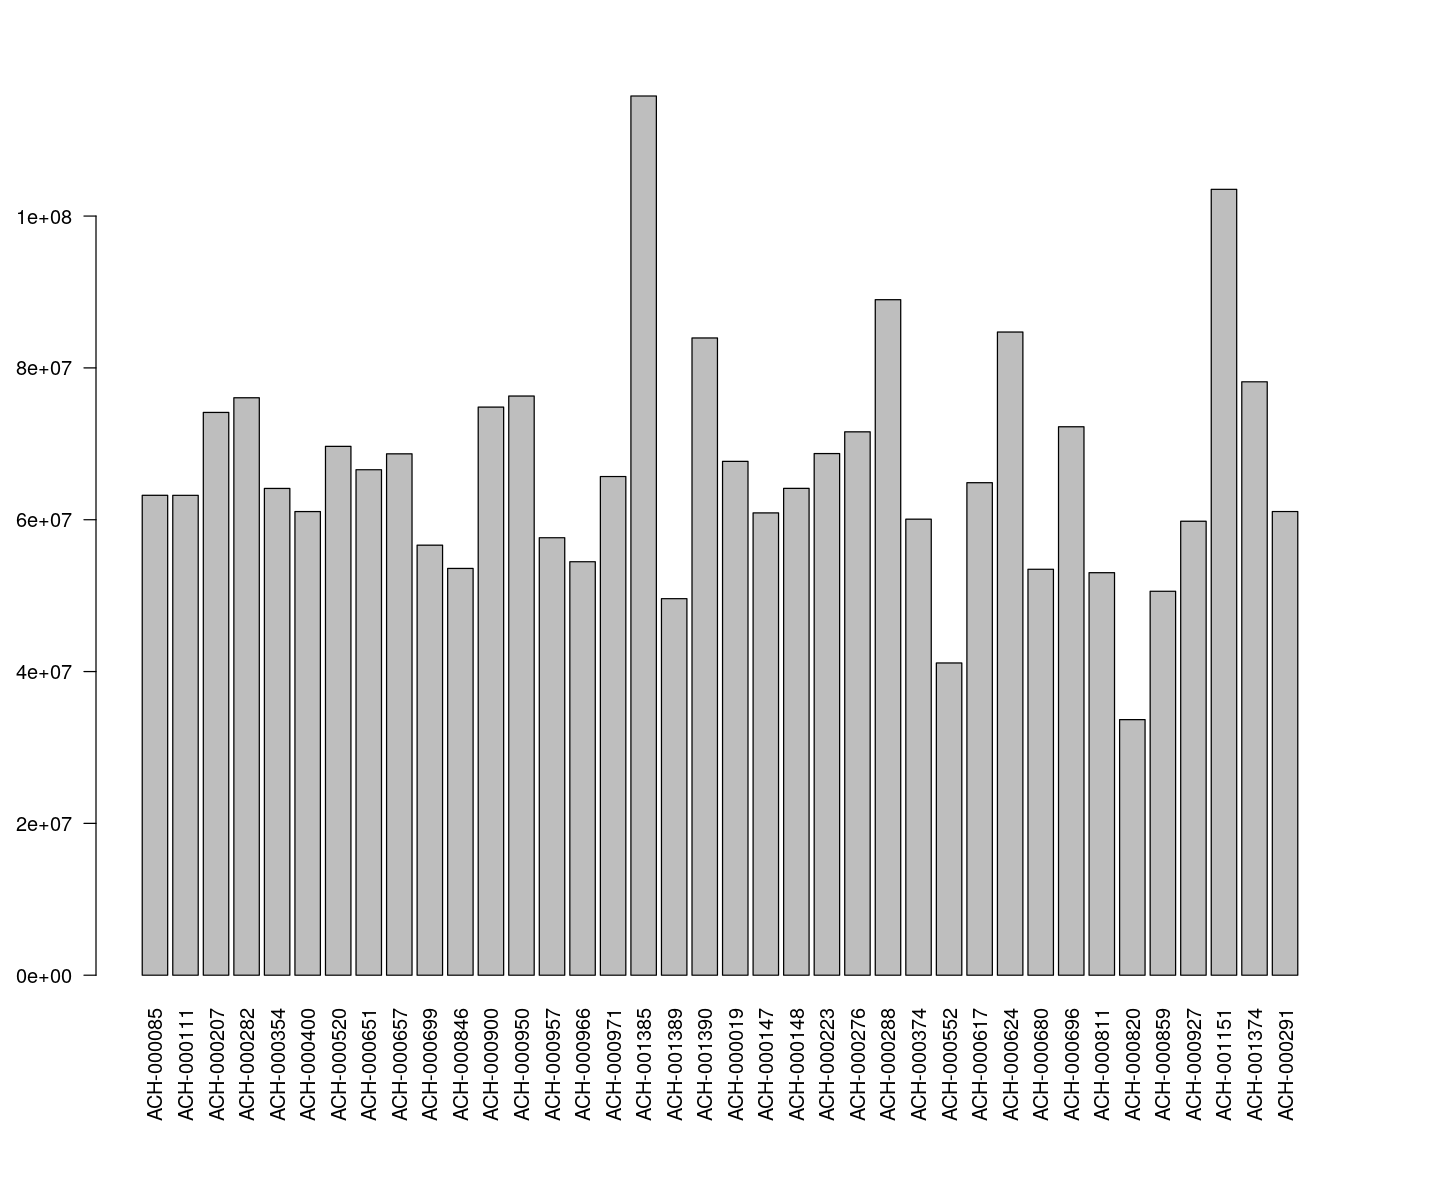

In [12]:
#Read counts
#pdf('Olaparib.fig.gene_exp.read_counts.pdf')
options(repr.plot.width=12, repr.plot.height=10)
par(mar=c(9,4,4,4))
barplot(y$samples$lib.size, names = colnames(y), las = 2)
#dev.off()

In [4]:
mean(y$samples$lib.size)

[1] 66674499

In [13]:
write.csv(y$samples['lib.size'],'Olaparib.refractory.exp.read_counts.csv', quote = FALSE)

In [14]:
res_color = rep('black', dim(y$samples[y$samples$group == 'responders',])[1])
nres_color = rep('red', dim(y$samples[y$samples$group == 'non_responders',])[1])
y$samples$colors = c(res_color, nres_color)

### Coordination analysis
#### Black: Responders
#### Red: Non_responders

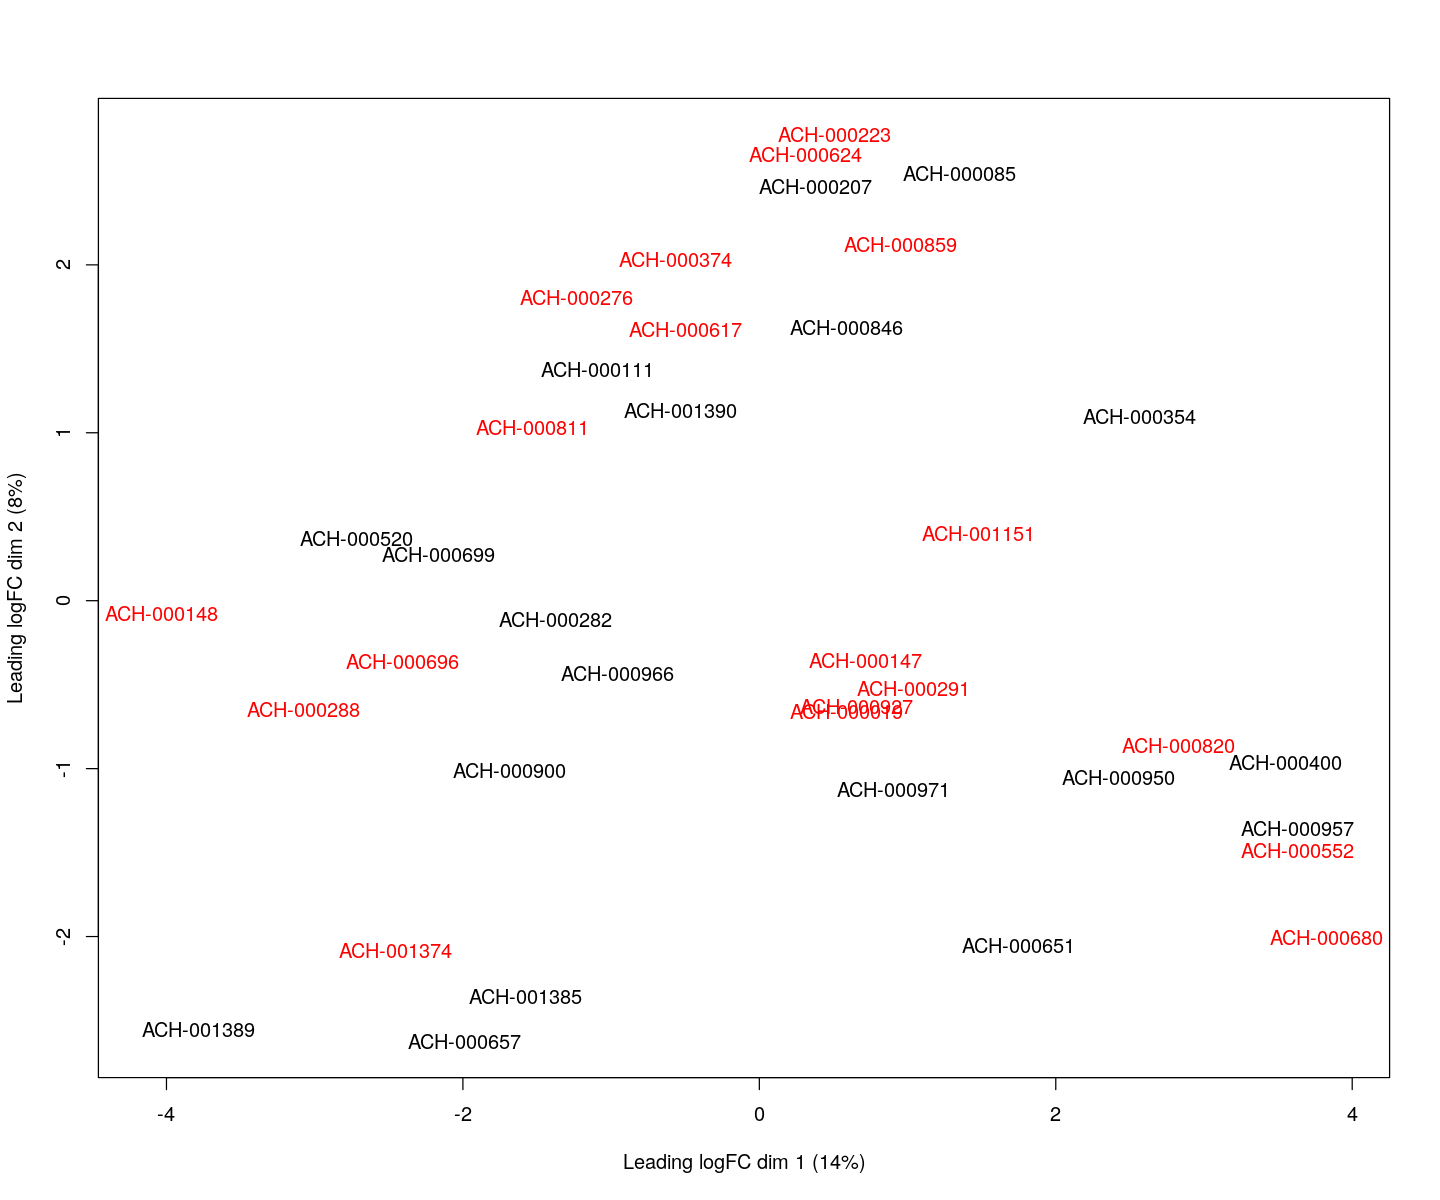

In [15]:
#pdf('Olaparib.fig.gene_exp.MDA.pdf', height = 12, width = 12)
plotMDS(y, col = y$samples$colors)
#dev.off()

In [16]:
#group
design = model.matrix(~0 + group)
colnames(design) = levels(group)

In [17]:
logcpm = cpm(y, log = TRUE)
fit = glmFit(y, group = group)
lrt = glmLRT(fit)
sig_table = topTags(lrt, n = 50000)

In [18]:
summa.fit = decideTests(lrt)
summary(summa.fit)

       y$samples$groupresponders
Down                         178
NotSig                     18408
Up                            95

In [19]:
exp_diff_table = sig_table$table[sig_table$table$PValue <= 0.1,]
dim(exp_diff_table)

[1] 3621    5

In [20]:
degs = rownames(exp_diff_table)

### Transform the Ensembl gene IDs to gene symbols

In [21]:
en_gi = colnames(mRNA)

In [22]:
en_gi = colnames(mRNA)
ensembl = useEnsembl(biomart = 'ensembl', dataset = 'hsapiens_gene_ensembl')
exp_gs = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
     filters = 'ensembl_gene_id',
      values = en_gi,
      mart = ensembl,
      uniqueRows = TRUE
     )

In [23]:
exp_gs$nstring = 0
exp_gs$nstring = nchar(exp_gs$hgnc_symbol)
exp_gs = exp_gs[exp_gs$nstring > 0,]


In [24]:
degs_gs_hgnc = exp_gs$hgnc_symbol[exp_gs$ensembl_gene_id %in% degs]
#degs_gs_hgnc

### Amuzu et al., 2021
#### evaluation from the suggested biomarkers

In [3]:
biomarker = c('PUM3', 'EEF1A1', 'ELP4')
indicators_up = c('SLFN11', 'TNFRSF10B', 'PUM3', 'C19orf44', 'CAPRIN1', 'SORCS2', 'PORLMT', 'RFX1', 'YWHAE', 'TRERF1')
indicators_down = c('DDTL', 'FCRL3', 'GPR19', 'SMIM4', 'CREG2', 'CCDC115', 'SNTA1', 'NEURL2', 'MED29', 'GSTA1')

In [4]:
exp_gs.biomarker = exp_gs[exp_gs$hgnc_symbol %in% biomarker,]
exp_gs.biomarker

ensembl_gene_id hgnc_symbol nstring
1501 ENSG00000080608 PUM3        4      
3716 ENSG00000109911 ELP4        4      
9989 ENSG00000156508 EEF1A1      6

In [5]:
biomarker_exp = logcpm[rownames(logcpm) %in% exp_gs.biomarker$ensembl_gene_id,]
rownames(biomarker_exp) = exp_gs.biomarker$hgnc_symbol
biomarker_exp

ACH-000085 ACH-000111 ACH-000207 ACH-000282 ACH-000354 ACH-000400
PUM3    5.692932   5.971052   6.483082   4.542391   5.625349   6.927728 
ELP4    4.638665   3.462184   4.660963   3.762203   3.851242   2.715198 
EEF1A1 12.810187  13.293284  13.007857  13.194341  12.761002  14.220842 
       ACH-000520 ACH-000651 ACH-000657 ACH-000699 ⋯ ACH-000624 ACH-000680
PUM3    4.758218   6.017566   6.234418   6.661745  ⋯  3.676491   5.175622 
ELP4    3.729436   4.695866   3.710459   3.457009  ⋯  4.787083   4.543838 
EEF1A1 15.128107  13.783057  13.672566  13.149898  ⋯ 13.257220  13.567861 
       ACH-000696 ACH-000811 ACH-000820 ACH-000859 ACH-000927 ACH-001151
PUM3    6.051547   4.420797   5.382211   7.625793   3.838223   6.315591 
ELP4    4.001425   3.680509   4.158390   3.701548   3.879573   5.229870 
EEF1A1 14.408484  13.482125  13.002168  12.364932  12.903606  13.326186 
       ACH-001374 ACH-000291
PUM3    6.229365   4.330135 
ELP4    4.644590   4.713328 
EEF1A1 13.736318  12.944444

In [6]:
res_bio_exp = biomarker_exp[,colnames(biomarker_exp) %in% res_id]
nres_bio_exp = biomarker_exp[,colnames(biomarker_exp) %in% nres_id]
res_bio_exp

ACH-000085 ACH-000111 ACH-000207 ACH-000282 ACH-000354 ACH-000400
PUM3    5.692932   5.971052   6.483082   4.542391   5.625349   6.927728 
ELP4    4.638665   3.462184   4.660963   3.762203   3.851242   2.715198 
EEF1A1 12.810187  13.293284  13.007857  13.194341  12.761002  14.220842 
       ACH-000520 ACH-000651 ACH-000657 ACH-000699 ACH-000846 ACH-000900
PUM3    4.758218   6.017566   6.234418   6.661745   5.583502   5.828078 
ELP4    3.729436   4.695866   3.710459   3.457009   4.172055   3.445381 
EEF1A1 15.128107  13.783057  13.672566  13.149898  13.449759  13.560965 
       ACH-000950 ACH-000957 ACH-000966 ACH-000971 ACH-001385 ACH-001389
PUM3    5.809067   5.730401   6.282661   6.213679   5.224201   5.636543 
ELP4    3.407910   3.946152   3.617193   4.230264   4.886130   4.687918 
EEF1A1 14.190869  13.809580  13.566632  13.470050  14.457542  13.772956 
       ACH-001390
PUM3    6.614749 
ELP4    5.239093 
EEF1A1 13.709870

In [7]:
nres_bio_exp

ACH-000019 ACH-000147 ACH-000148 ACH-000223 ACH-000276 ACH-000288
PUM3    5.048000   4.238600   5.897207   5.176405   5.932393   6.764925 
ELP4    3.902027   4.665374   4.098096   3.941489   3.325233   3.749802 
EEF1A1 13.533511  12.623315  13.070231  12.305631  12.813204  13.349708 
       ACH-000374 ACH-000552 ACH-000617 ACH-000624 ACH-000680 ACH-000696
PUM3    4.403706   6.029772   6.409749   3.676491   5.175622   6.051547 
ELP4    4.020959   4.592985   3.381781   4.787083   4.543838   4.001425 
EEF1A1 12.275038  13.752492  13.217911  13.257220  13.567861  14.408484 
       ACH-000811 ACH-000820 ACH-000859 ACH-000927 ACH-001151 ACH-001374
PUM3    4.420797   5.382211   7.625793   3.838223   6.315591   6.229365 
ELP4    3.680509   4.158390   3.701548   3.879573   5.229870   4.644590 
EEF1A1 13.482125  13.002168  12.364932  12.903606  13.326186  13.736318 
       ACH-000291
PUM3    4.330135 
ELP4    4.713328 
EEF1A1 12.944444

In [8]:
biomarker.sig_table = as.data.frame(sig_table[rownames(sig_table) %in% exp_gs.biomarker$ensembl_gene_id, ])
rownames(biomarker.sig_table) = c('EEF1A1', 'PUM3', 'ELP4')
biomarker.sig_table

logFC       logCPM    LR        PValue     FDR      
EEF1A1  0.49915530 13.526647 5.9542984 0.01468144 0.2391097
PUM3    0.20844493  5.901742 0.5576970 0.45518964 0.8321164
ELP4   -0.09538622  4.201985 0.1844514 0.66757539 0.9172589

In [9]:
res_bio_exp.melt = melt(as.matrix(res_bio_exp))
res_bio_exp.melt['response'] = 'responders'
nres_bio_exp.melt = melt(as.matrix(nres_bio_exp))
nres_bio_exp.melt['response'] = 'non_responders'
bio_exp.melt = rbind(res_bio_exp.melt, nres_bio_exp.melt)
colnames(bio_exp.melt) = c('biomarkers', 'DepMap_ID','logcpm', 'response')
head(bio_exp.melt)

biomarkers DepMap_ID  logcpm    response  
1 PUM3       ACH-000085  5.692932 responders
2 ELP4       ACH-000085  4.638665 responders
3 EEF1A1     ACH-000085 12.810187 responders
4 PUM3       ACH-000111  5.971052 responders
5 ELP4       ACH-000111  3.462184 responders
6 EEF1A1     ACH-000111 13.293284 responders

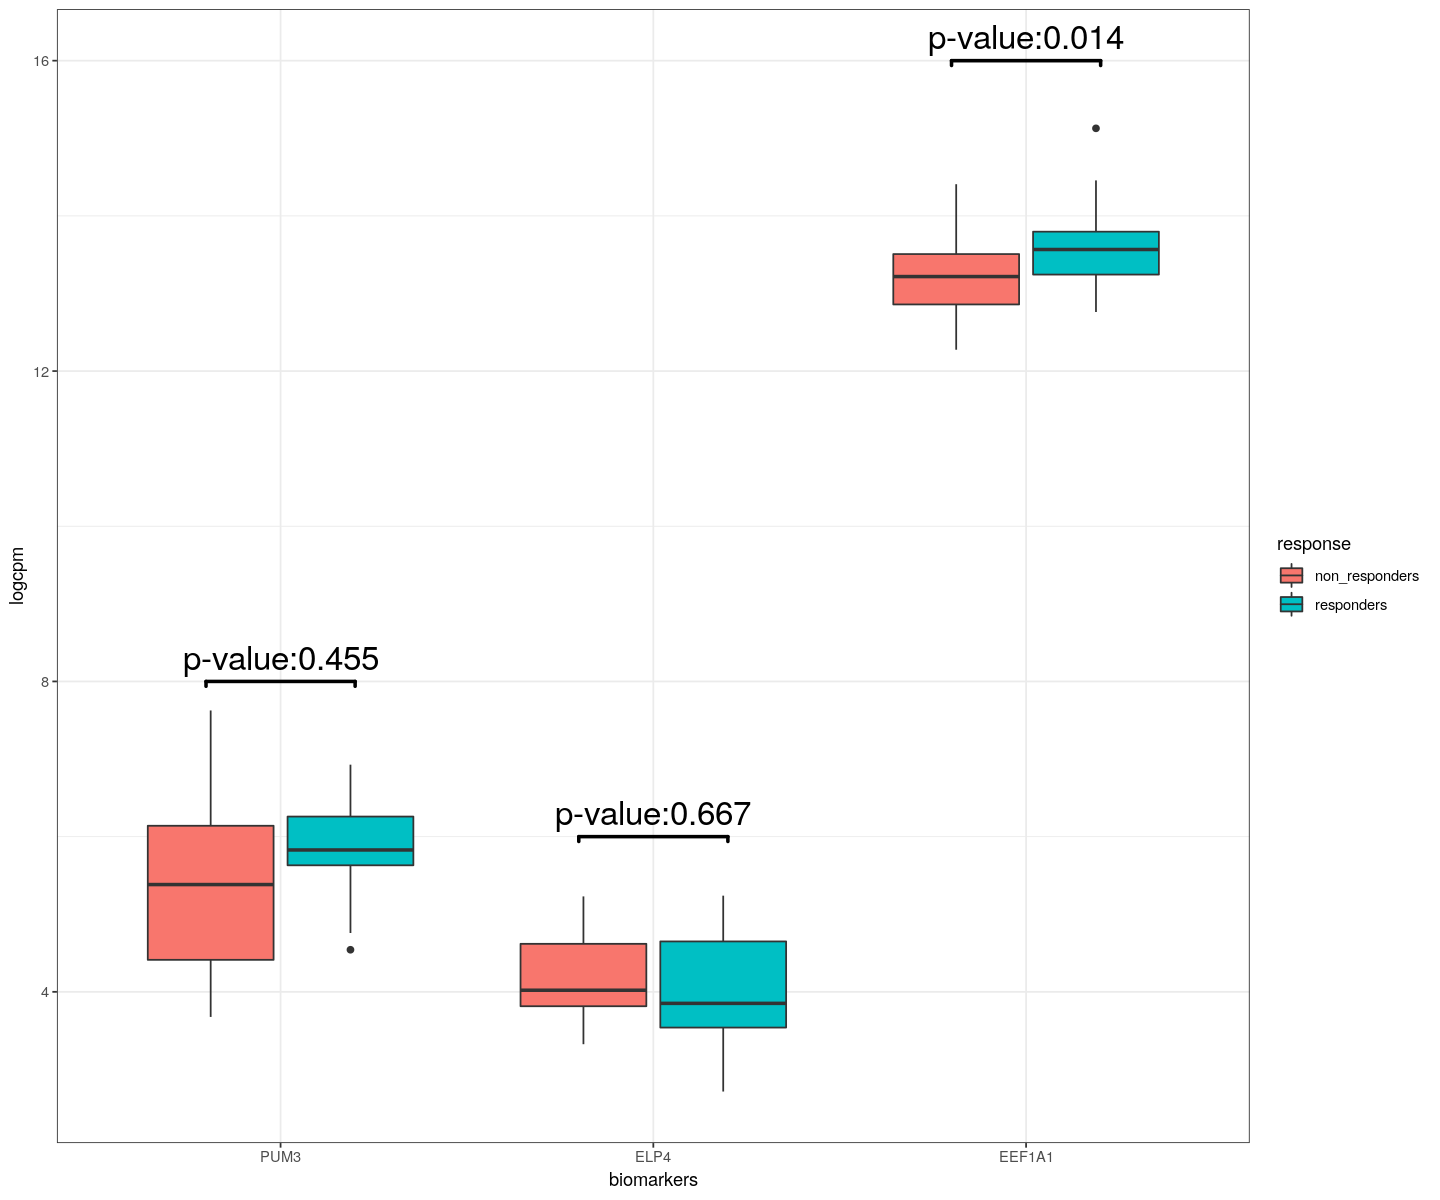

In [10]:
p = ggplot(bio_exp.melt, aes(x = `biomarkers`, y = `logcpm`, fill = `response`)) +
    geom_boxplot() +
    geom_signif(
        y_position = c(8, 6, 16),
        xmin = c(0.8,1.8,2.8),
        xmax = c(1.2,2.2,3.2),
        annotation = c('p-value:0.455','p-value:0.667','p-value:0.014'),
        tip_length = 0.005,
        textsize = 7,
        size = 1
    )
p + theme_bw()
#p + geom_signif(data = biomarker.sig_table, aes( annotations = PValue, group = response), manual = TRUE, tip_length = 0)

In [52]:
inter_BM = vector()
inter_BM = c(inter_BM, degs_gs_hgnc[degs_gs_hgnc %in% biomarker])
inter_BM = c(inter_BM, degs_gs_hgnc[degs_gs_hgnc %in% indicators_up])
inter_BM = c(inter_BM, degs_gs_hgnc[degs_gs_hgnc %in% indicators_down])
inter_BM

[1] "EEF1A1"    "TNFRSF10B" "CAPRIN1"   "MED29"     "CREG2"

Warning message in plot.window(...):
“"coef" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"coef" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"coef" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"coef" is not a graphical parameter”
Warning message in box(...):
“"coef" is not a graphical parameter”
Warning message in title(...):
“"coef" is not a graphical parameter”


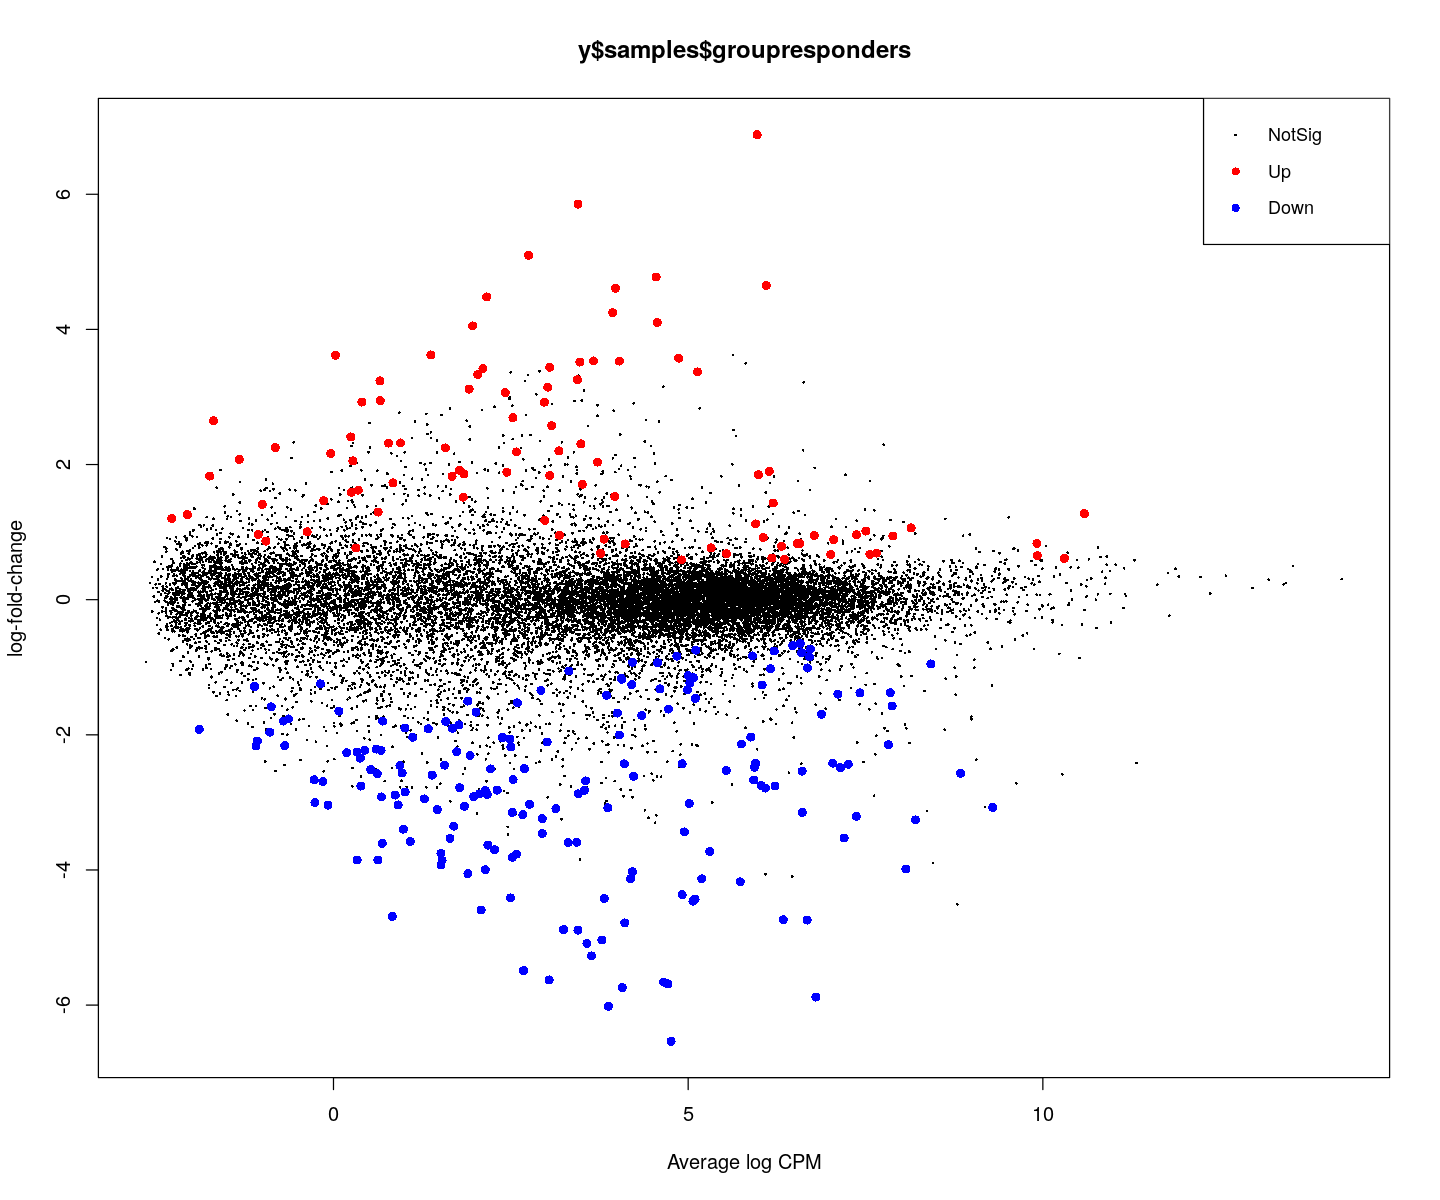

In [19]:
#pdf('Olaparib.fig.gene_exp.MAplot.pdf')
plotMD(lrt, coef = 1, status = summa.fit[,'y$samples$groupresponders'],hl.col = c('red','blue'))
#abline(h=c(-1, 1), col="blue")
#dev.off()

## TF activity inference
https://saezlab.github.io/dorothea/articles/bulk_vignette.html
## Pathway activity inference
https://saezlab.github.io/progeny/

In [54]:
mRNA.count = t(mRNA)
en_gi = rownames(mRNA.count)
exp.count_gs = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
     filters = 'ensembl_gene_id',
      values = en_gi,
      mart = ensembl,
      uniqueRows = TRUE
     )

In [55]:
mRNA.count = cbind(mRNA.count[exp.count_gs[['ensembl_gene_id']], ], exp.count_gs['hgnc_symbol'])
mRNA.count = mRNA.count[nchar(mRNA.count[['hgnc_symbol']])>0, ]
mRNA.count = mRNA.count[!duplicated(mRNA.count['hgnc_symbol']),]

In [56]:
rownames(mRNA.count) = mRNA.count[['hgnc_symbol']]
mRNA.count = mRNA.count[,1:dim(mRNA.count)[2]-1]
#mRNA.count

In [57]:
load('/home/jupyter/Cell-death-signatures/data/Functional/DoRothEA.rdata')
regulon=viper_regulon
activities = viper(eset = mRNA.count, regulon = regulon, nes = T, 
                   method = 'none' ,minsize = 4, eset.filter = F,cores = 6)
rownames(activities) = sapply(strsplit(rownames(activities)," -"), `[`, 1)
pathway = progeny(as.matrix(mRNA.count), scale = TRUE, organism = 'Human')


Computing the association scores



In [58]:
un_filt = c(un_filt, 1396)
un_filt

[1] 51611 17313 51845  1396

In [59]:
activities.zscore = (activities - rowMeans(activities))/(rowSds(as.matrix(activities)))[row(activities)]
activities.zscore = activities.zscore[grepl('_A|_B|_C', rownames(activities.zscore)),]

In [60]:
pathway = pathway[sample_id,]
activities = t(activities.zscore[,sample_id])

## Feature selection
### wilcox test

In [61]:
my_wilcox = function(x){
    my_p_values = vector()
    for(i in seq(dim(x)[2])){
        gene_idx = i
        a = t(x[,gene_idx])[1:19]
        b = t(x[,gene_idx])[20:length(t(x[,2]))]
        out = tryCatch(wilcox.test(a,b, exact = FALSE)$p.value, error = function(e) 0)
        my_p_values = c(my_p_values, out)
    }
    return(my_p_values)
}

In [62]:
Mutations = Mutations[,colSums(Mutations)>1]
dim(Mutations)

[1]  38 635

In [ ]:
Meth_p = my_wilcox(Methylation)
length(Meth_p)
Meth_p = Meth_p[!is.na(Meth_p)]
length(Meth_p)
Methylation = Methylation[,Meth_p<0.05]
dim(Methylation)

In [ ]:
mRNA.diff = logcpm[rownames(exp_diff_table),]
dim(mRNA.diff)
en_gi = rownames(mRNA.diff)
mRNA.diff_gs = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
     filters = 'ensembl_gene_id',
      values = en_gi,
      mart = ensembl
     )


In [ ]:
mRNA.diff = cbind(mRNA.diff[mRNA.diff_gs[['ensembl_gene_id']],], mRNA.diff_gs['hgnc_symbol'])

In [ ]:
mRNA.diff = mRNA.diff[nchar(mRNA.diff[['hgnc_symbol']])>0,]
mRNA.diff = mRNA.diff[mRNA.diff['hgnc_symbol'] != 'LINC01238',]
#rownames(mRNA.diff) = mRNA.diff['hgnc_symbol']
rownames(mRNA.diff) = mRNA.diff[['hgnc_symbol']]
mRNA.diff = mRNA.diff[,1:dim(mRNA.diff)[2]-1]

In [ ]:
mRNA.diff = data.frame(t(mRNA.diff))
#mRNA.diff

## MOFA+ analysis

In [ ]:
#my_data = list(t(mRNA),t(Methylation),t(Mutations), t(activities), t(CNVs))
#names(my_data) = c('mRNA', 'Methylations', 'Mutations', 'Activities', 'CNVs')
colnames(Mutations) = paste0(colnames(Mutations),'_mut')
my_data = list(t(mRNA.diff),t(Methylation),t(Mutations), t(activities))#, t(pathway))
names(my_data) = c('mRNA', 'Methylations', 'Mutations', 'Activities')#, 'Pathway')
lapply(my_data, dim)

In [ ]:
filt = c(3295, 635, 2361, 289)

In [ ]:
data_filt = data.frame(un_filt = un_filt, filt = filt)
rownames(data_filt) = c('Gene_expression','Muation','Methylation','Protein_Activity')
data_filt

In [ ]:
data_filt.melt = melt(as.matrix(data_filt))
colnames(data_filt.melt) = c('Features', 'Filt', 'counts')
data_filt.melt

In [ ]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(data_filt.melt, aes(x = `Features`, y = `counts`, fill = `Filt`)) +
    geom_bar(stat = 'identity', position = 'dodge') +
    theme_bw()

In [ ]:
write.csv(mRNA.diff, 'Olaparib.refractory.cpm.csv', quote = FALSE)

In [ ]:
write.csv(Methylation, 'Olaparib.refractory.meth.csv', quote = FALSE)

In [ ]:
write.csv(Mutations, 'Olaparib.refractory.mut.csv', quote = FALSE)

In [ ]:
write.csv(activities, 'Olaparib.refractory.act.csv', quote = FALSE)

In [ ]:
#MOFAobject <- create_mofa(my_data, groups = sample_info$group)
MOFAobject = create_mofa(my_data)

In [ ]:
MOFAobject

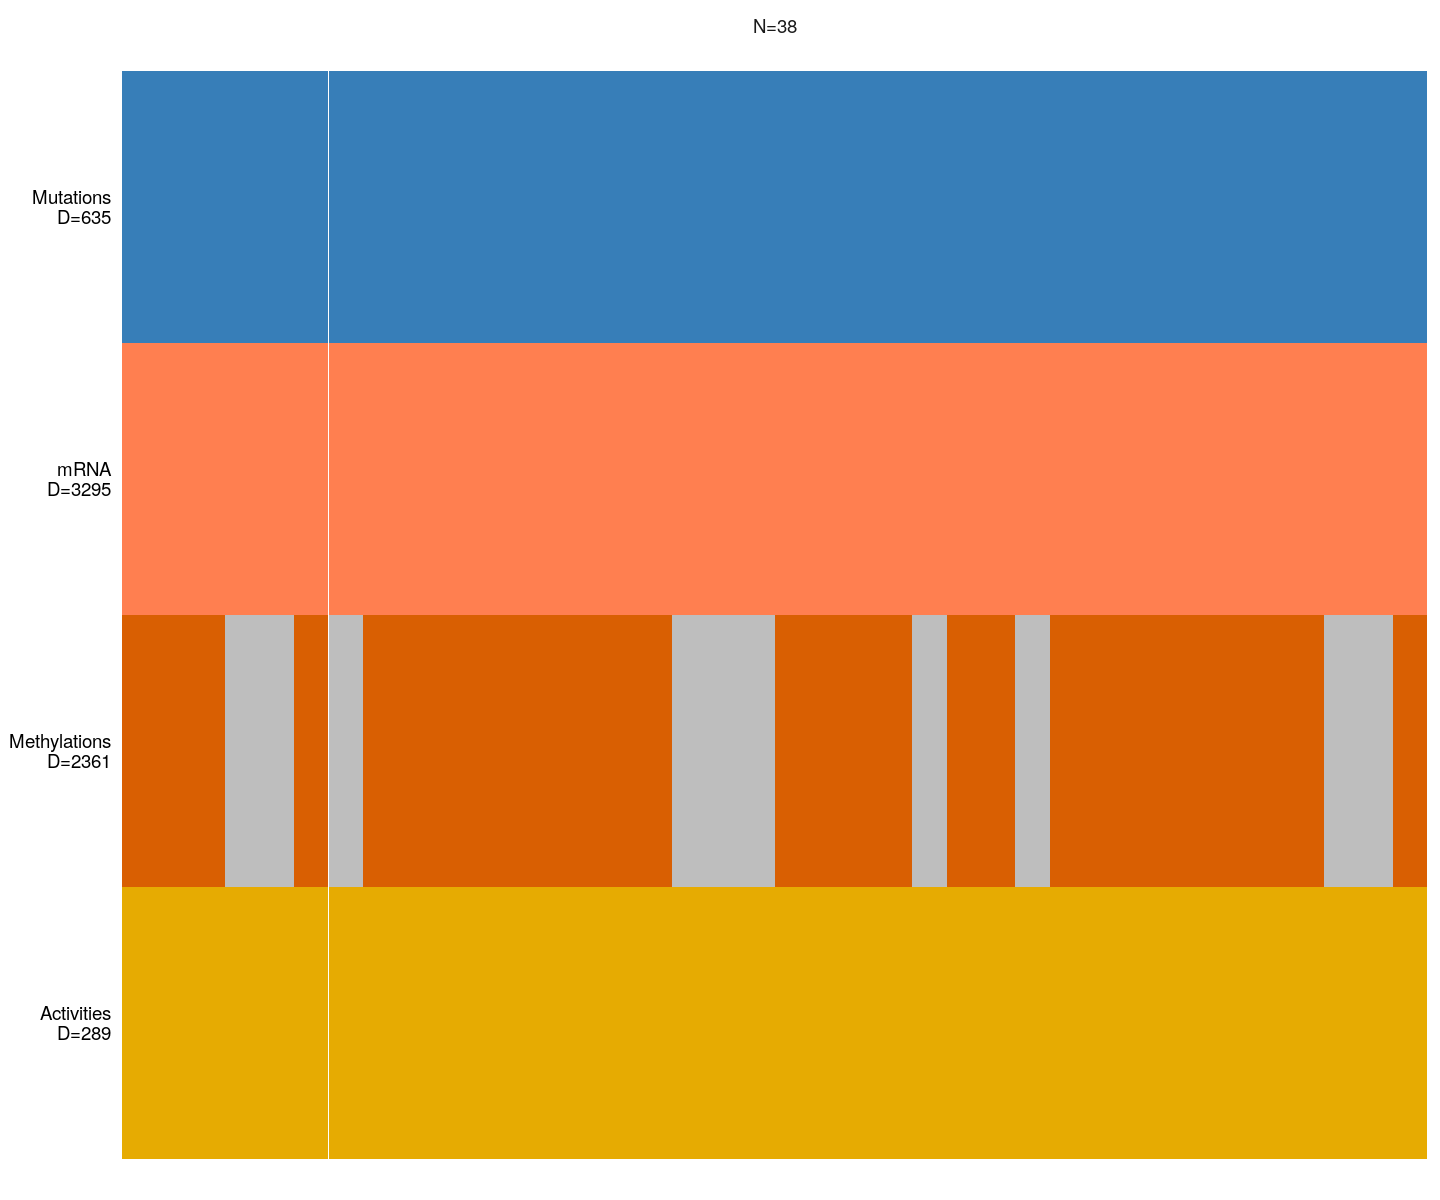

In [4]:
#pdf('Olaparib.fig.MOFA.overview.pdf')
plot_data_overview(MOFAobject)
#dev.off()

In [ ]:
# Default data options
data_opts <- get_default_data_options(MOFAobject)
#data_opts$scale_views = F


# Default model options
model_opts <- get_default_model_options(MOFAobject)
model_opts$num_factors <- 9
#c('mRNA', 'Methylations', 'Mutations', 'Activities', 'Pathway')


# Training options
train_opts <- get_default_training_options(MOFAobject)
train_opts$convergence_mode <- "fast"
train_opts$seed <- 42

In [ ]:
MOFAobject <- prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
)

In [ ]:
n_inits = 5
MOFAlist = lapply(seq_len(n_inits), function(i) run_mofa(MOFAobject, outfile = tempfile()))
#compare_factors(MOFAobject)

#run_mofa(MOFAobject, outfile = tempfile())

In [ ]:
#pdf('Olaparib.fig.factor_corr.pdf')
all_compare = compare_factors(MOFAlist, comparison = 'all')
#dev.off()
#pair_compare = compare_factors(MOFAlist, comparison = 'pairwise')

In [ ]:
MOFAlist

In [ ]:
names(sample_info)[names(sample_info) == 'group'] = 'response'
colnames(sample_info)

In [ ]:
MOFAobject = MOFAlist[[1]]#<- run_mofa(MOFAobject, outfile = 'Olaparib.mofa.model.v6.hdf5', use_basilisk = FALSE)
#groups_names(MOFAobject) = 'group'
sample_info['sample'] = rownames(sample_info)
samples_metadata(MOFAobject) <- sample_info

In [7]:
MOFAobject@dimensions

$M
[1] 4

$G
[1] 1

$N
group1 
    38 

$D
        mRNA Methylations    Mutations   Activities 
        3295         2361          635          289 

$K
[1] 9

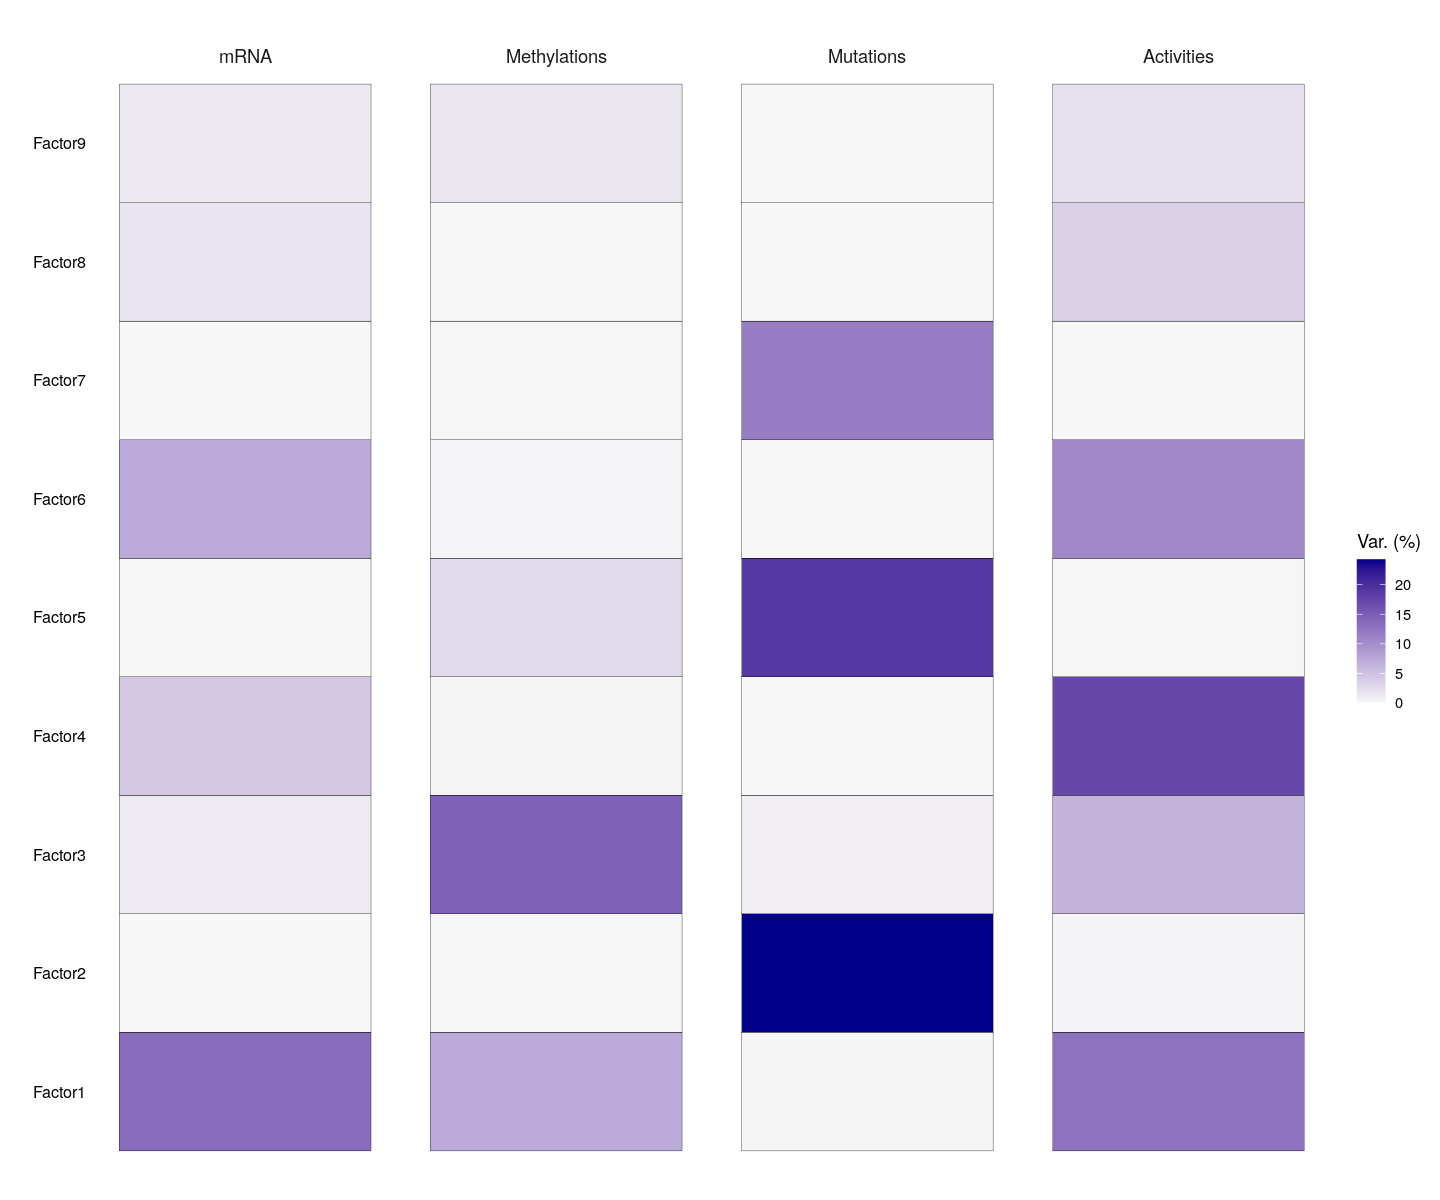

In [5]:
#options(repr.plot.width=10, repr.plot.height=8)
#pdf('Olaparib.fig.MOFA.factor_variance.overview.pdf')
p = plot_variance_explained(MOFAobject, x="group", y="factor") 
p + theme(axis.text.x = element_blank())
#p$data
#dev.off()

In [ ]:
write.csv(dcast(p$data, factor ~ view), 'Olaparib.refractory.factor.variance.csv', quote = FALSE)

## Figuring out the important factors

In [ ]:
mRNA.f = 1
Methyl.f = 3
Mut.f = 2
Act.f = 4

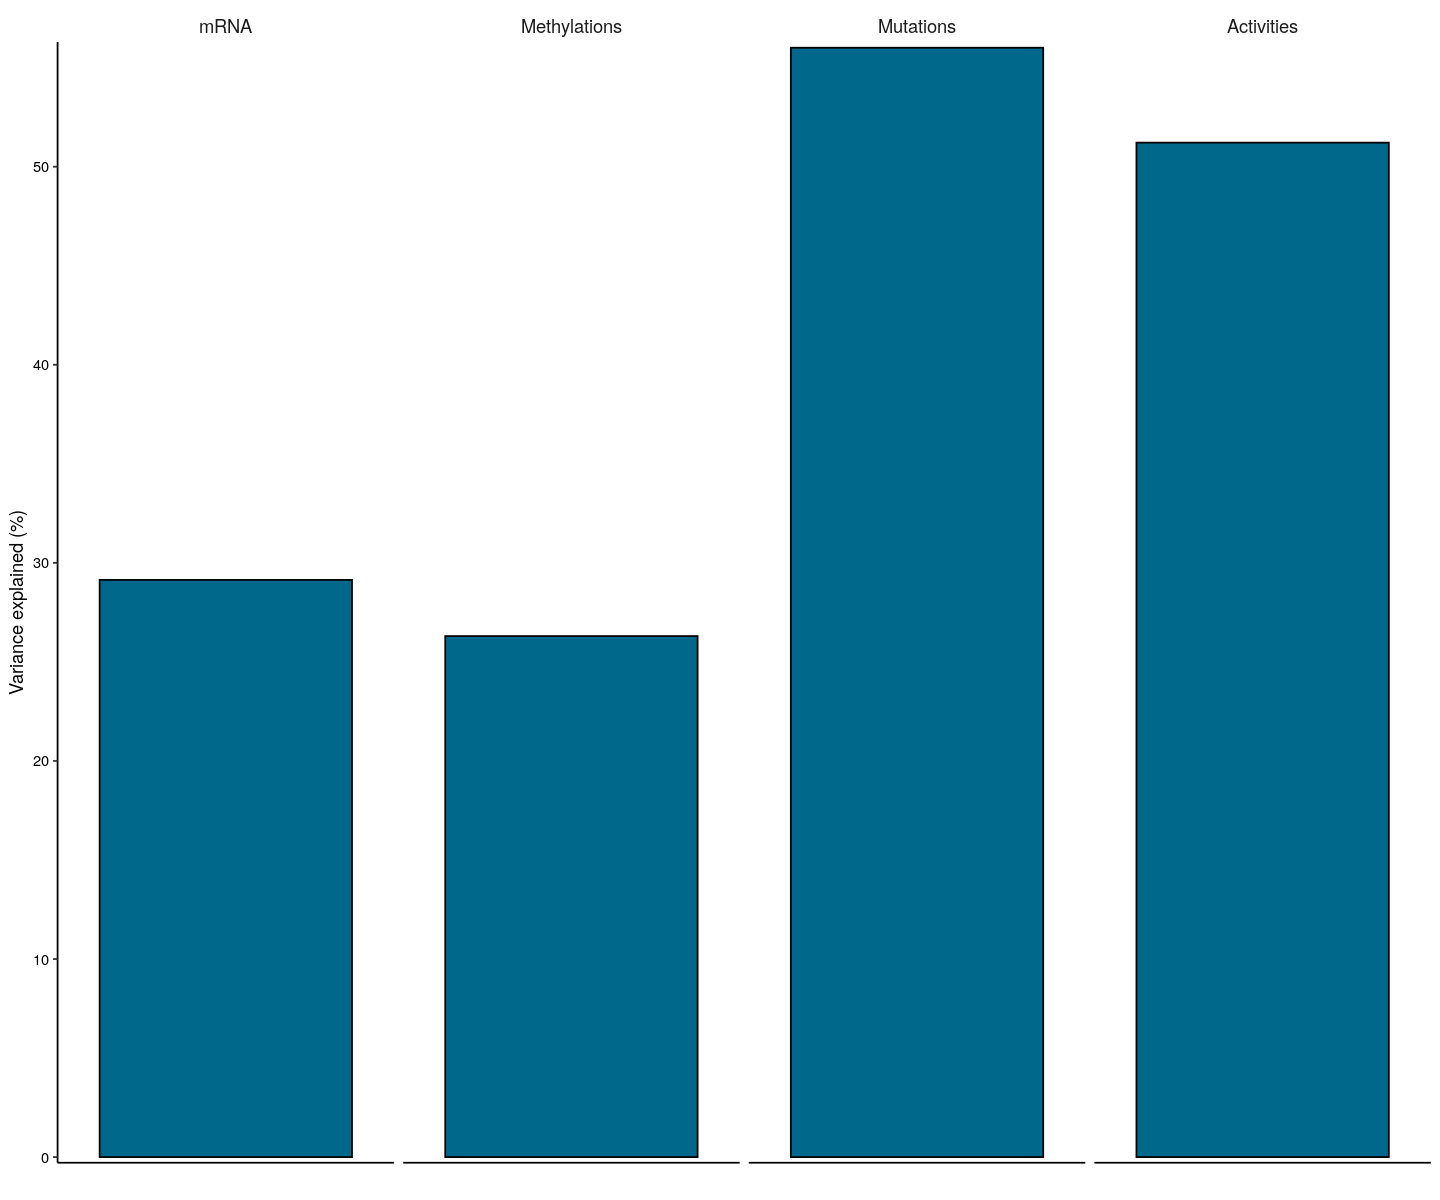

In [6]:
#pdf('Olaparib.fig.MOFA.factor_variance.explained.pdf')
p = plot_variance_explained(
  MOFAobject, 
  x = "group", 
  y = "factor", 
  plot_total = T
)[[2]]
p + theme(axis.text.x = element_blank())
#dev.off()

In [ ]:
write.csv(p$data, 'Olaparib.refractory.factor.variance.explained.csv', quote = FALSE)

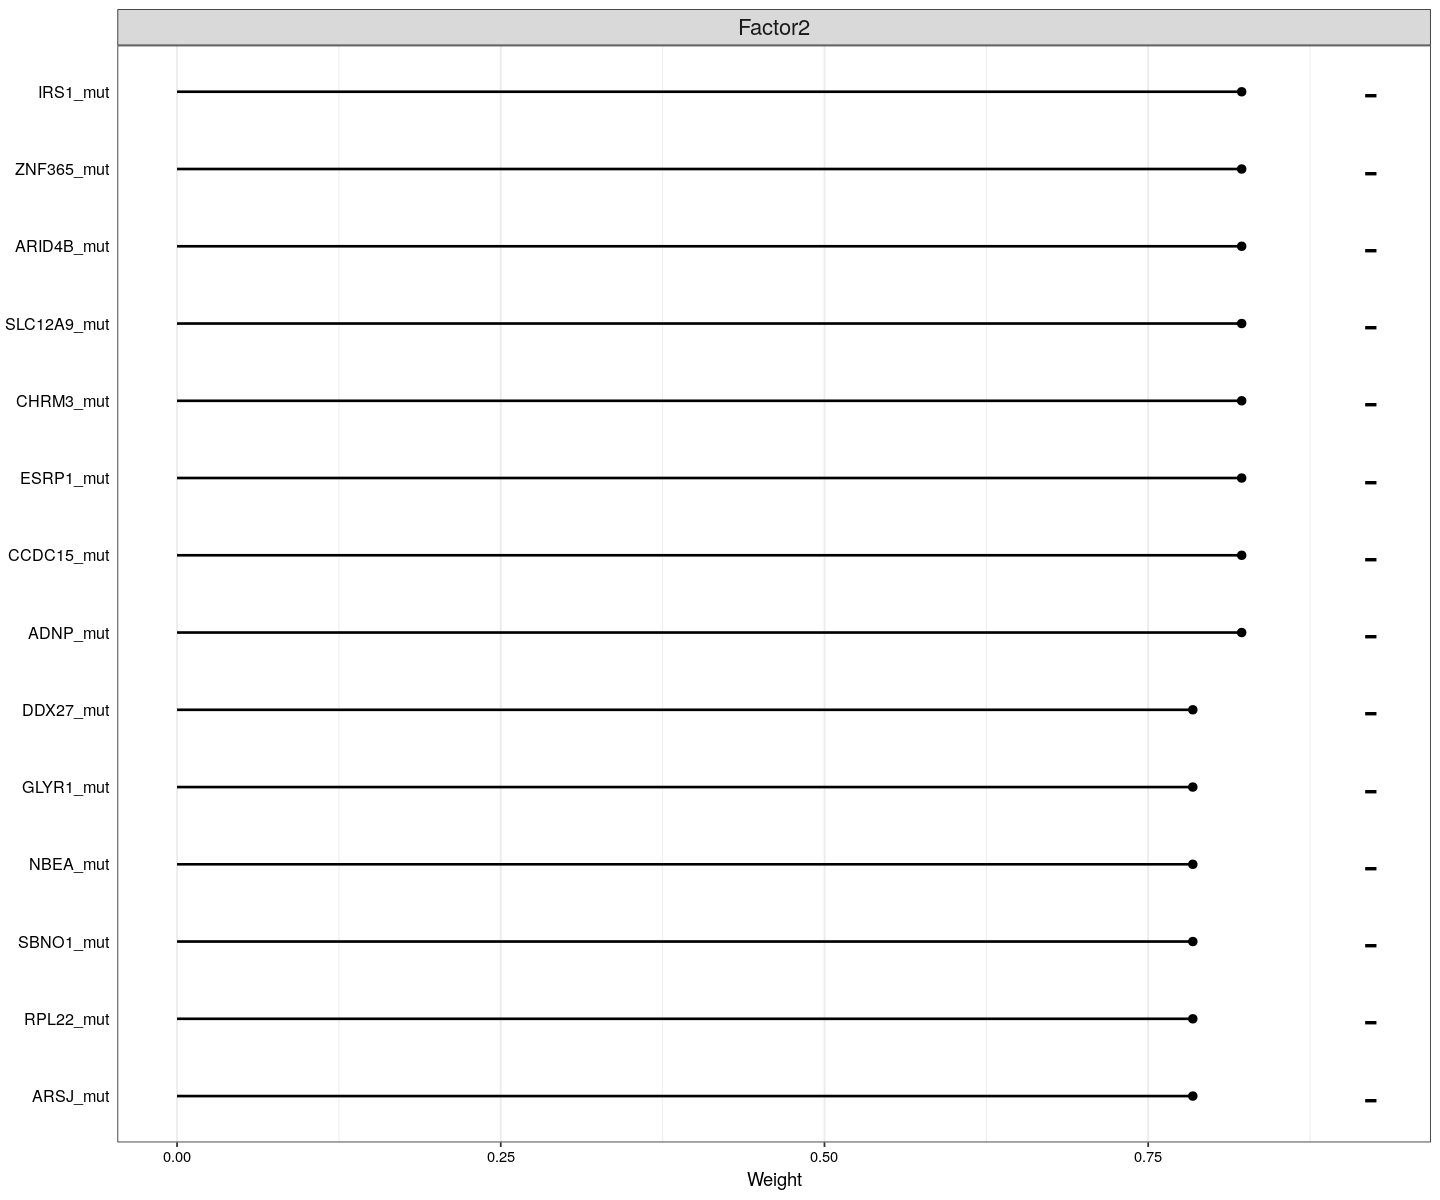

In [7]:
#pdf('Olaparib.fig.MOFA.top_weights.mut.pdf')
p = plot_top_weights(MOFAobject, 
  view = "Mutations", 
  factor = Mut.f,
  nfeatures = 10,
  scale = F,
  abs = F
)
p
#dev.off()

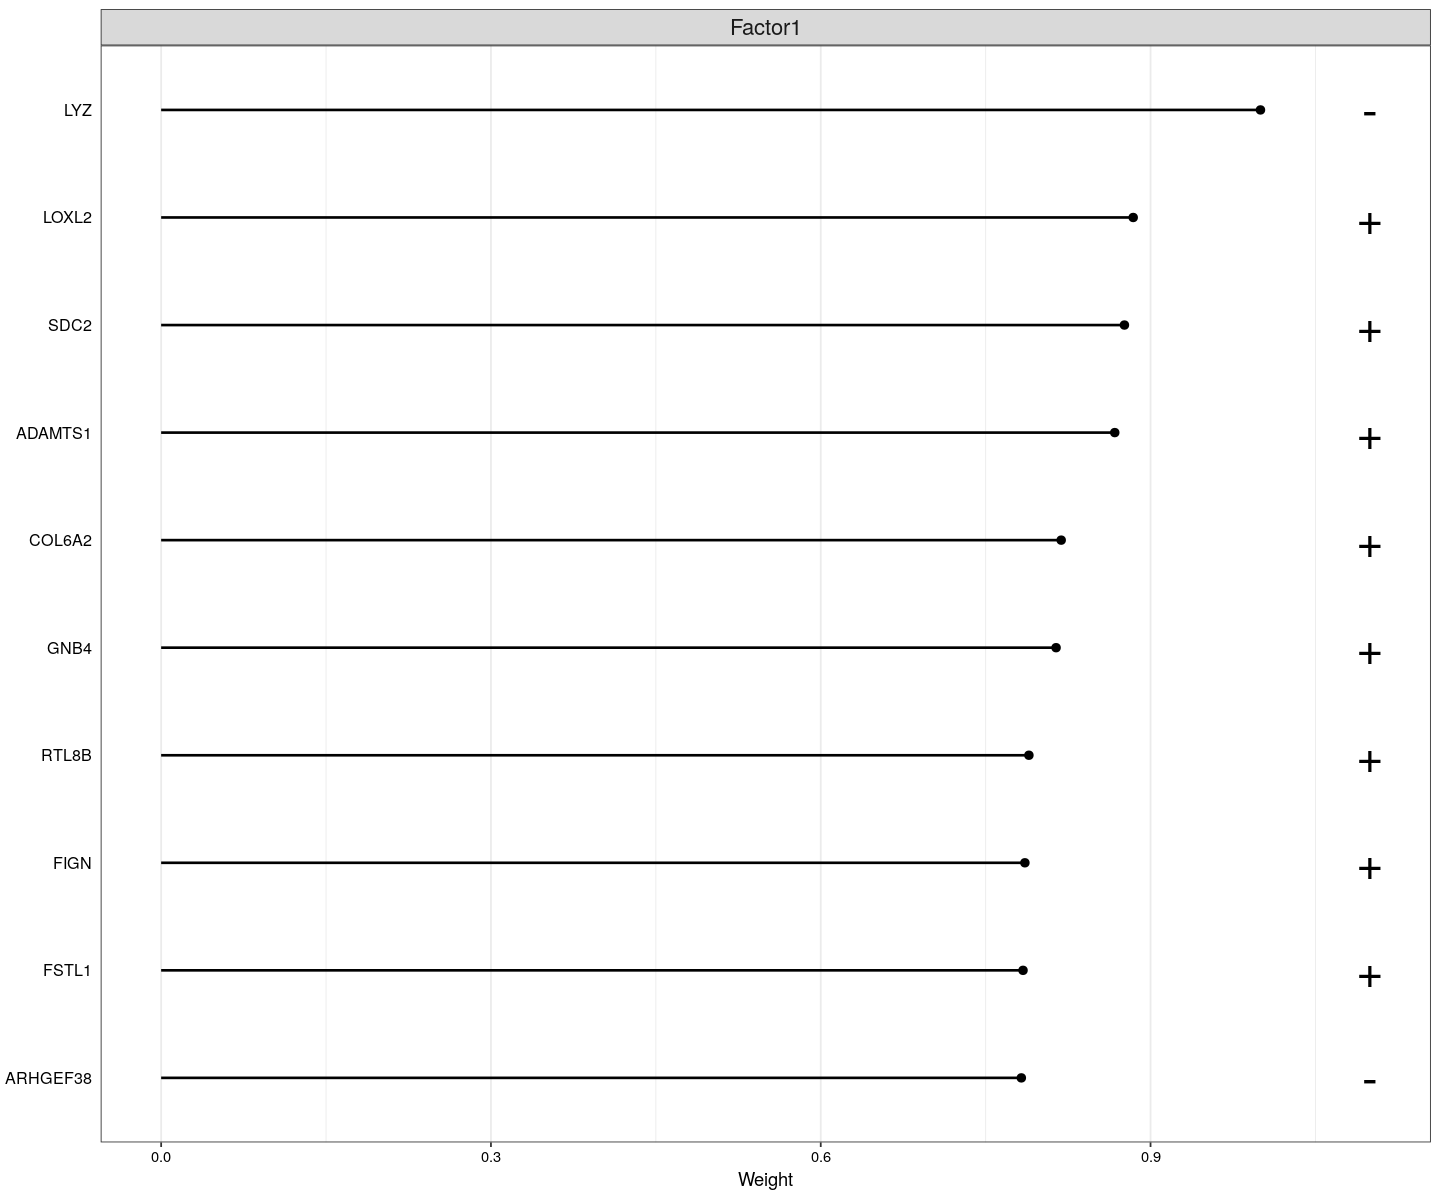

In [8]:
#pdf('Olaparib.fig.MOFA.top_weights.exp.pdf')
p = plot_top_weights(MOFAobject, 
  view = "mRNA", 
  factor = mRNA.f, 
  nfeatures = 10,
  scale = T, 
  abs = T
)
p
#dev.off()

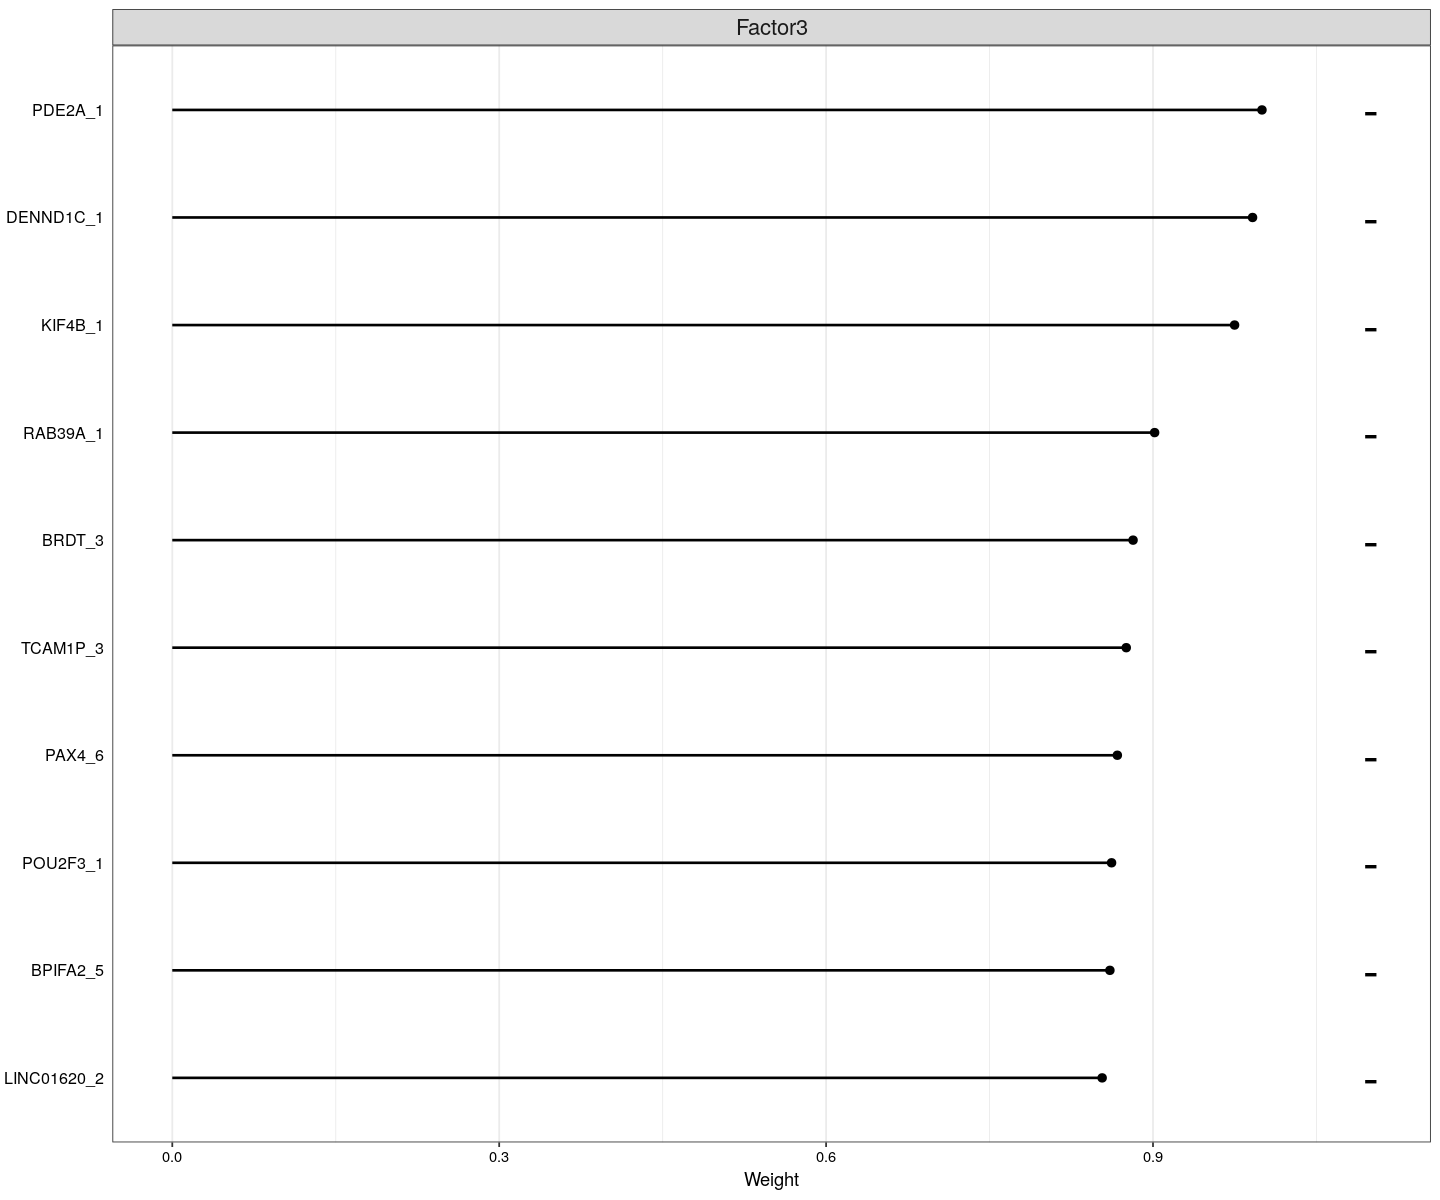

In [9]:
#pdf('Olaparib.fig.MOFA.top_weights.cpg.pdf')
p = plot_top_weights(MOFAobject, 
  view = "Methylations", 
  factor = Methyl.f, 
  nfeatures = 10,
  scale = T, 
  abs = T
)
p
#dev.off()

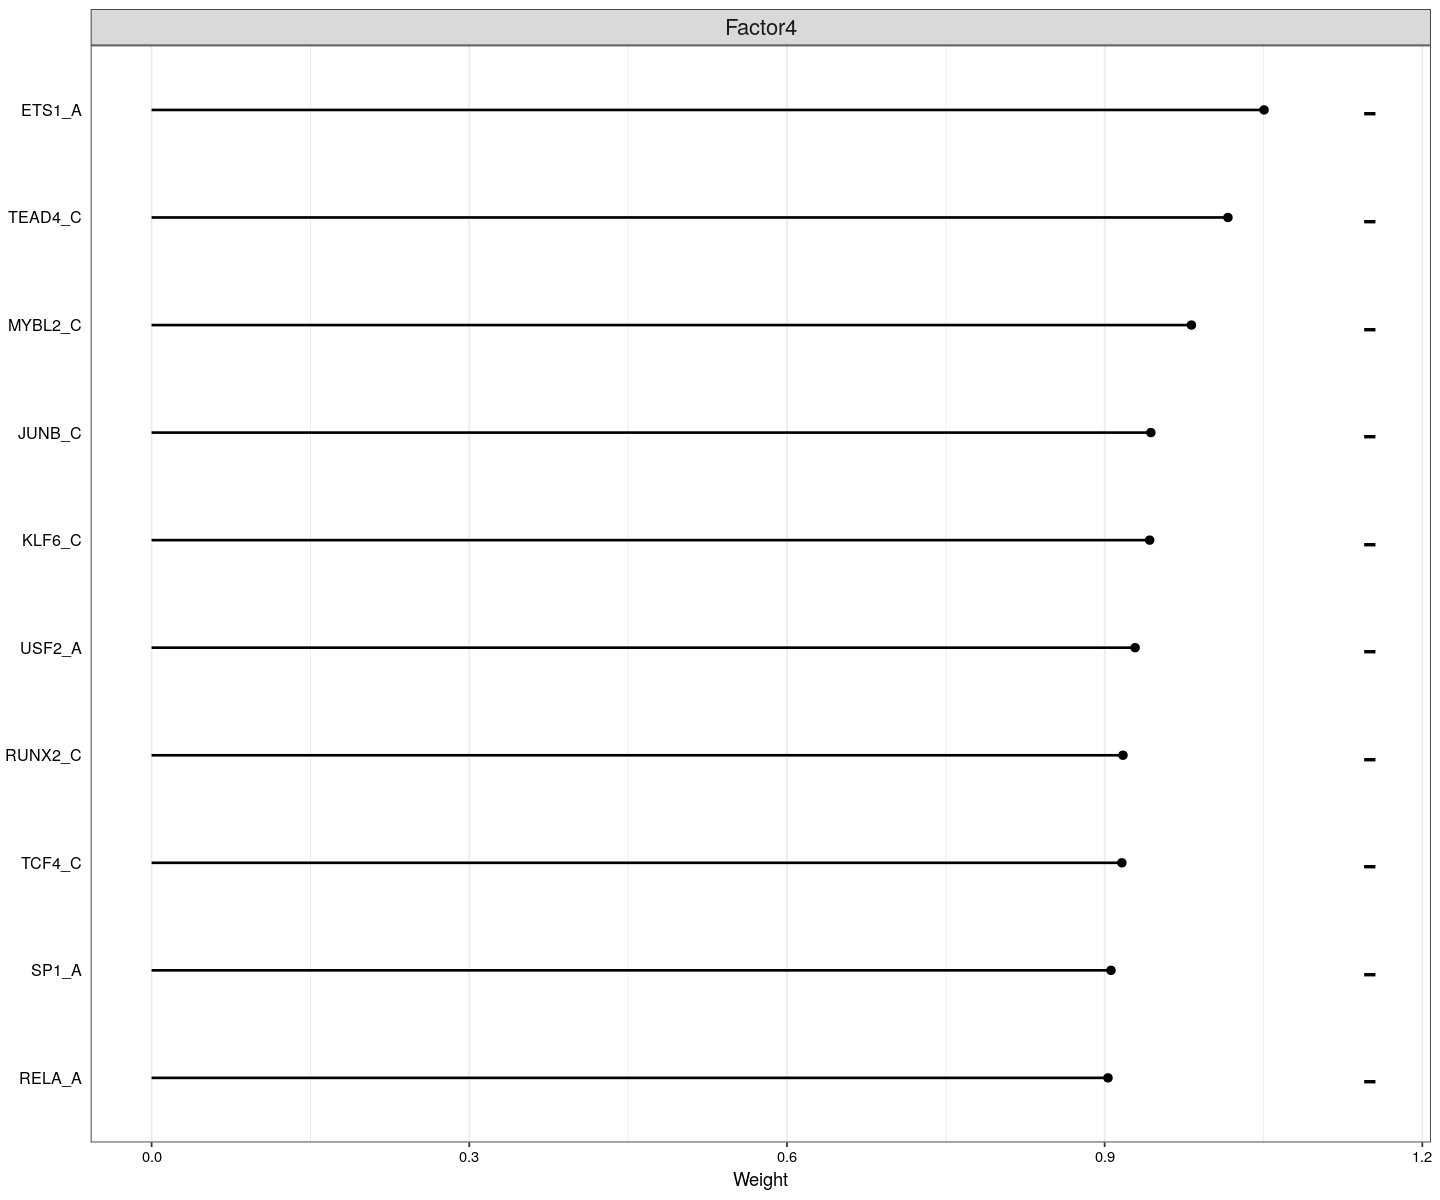

In [10]:
#pdf('Olaparib.fig.MOFA.top_weights.act.pdf')
p = plot_top_weights(MOFAobject, 
  view = "Activities", 
  factor = Act.f, 
  nfeatures = 10,
  scale = F, 
  abs = T
)
p
#dev.off()

options(repr.plot.width=12, repr.plot.height=10)
features <- c(biomarker)

plot_variance_explained_per_feature(
  MOFAobject, 
  view = "mRNA",
  features = 'EEF1A1'
)

## REACTOME analysis

In [ ]:
utils::data(reactomeGS)

head(colnames(reactomeGS))

In [ ]:
#en_gs = colnames(reactomeGS)
#ensembl = useEnsembl(biomart = 'ensembl', dataset = 'hsapiens_gene_ensembl')
#reactome_gs = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
#     filters = 'ensembl_gene_id',
#      values = en_gs,
#      mart = ensembl,
#      uniqueRows = TRUE
#     )

#reactomeGS = reactomeGS[,colnames(reactomeGS)[colnames(reactomeGS) %in% reactome_gs[['ensembl_gene_id']]]]


In [ ]:
#inter_gs = rownames(reactomeGS)[rownames(reactomeGS) %in% reactome_gs[['ensembl_gene_id']]]
#inter_gs = inter_gs[!inter_gs %in% 'ENSG00000276085']
#length(inter_gs)

In [ ]:
#reactomeGS = reactomeGS[inter_gs,]
#reactome_gs = reactome_gs[reactome_gs[['ensembl_gene_id']] %in% inter_gs, ]
#reactome = cbind(reactomeGS, reactome_gs)
#dim(reactome)

In [ ]:
#reactome = reactome[nchar(reactome[['hgnc_symbol']]) > 1,]
#dim(reactome)

In [ ]:
#rownames(reactome) = reactome[['hgnc_symbol']]

In [ ]:
#reactome = reactome[, seq(dim(reactome)[2] - 2)]
#reactome =  t(reactome)

In [ ]:
#write.csv(reactome, 'reactome.csv', quote = FALSE)

In [ ]:
reactome = read.csv('reactome.csv', row.names = 1, check.names = FALSE)
reactome = t(reactome)

In [7]:
res_pos = run_enrichment(MOFAobject, feature.sets = as.matrix(reactome), view = 'mRNA', sign = 'positive')
res_neg = run_enrichment(MOFAobject, feature.sets = as.matrix(reactome), view = 'mRNA', sign = 'negative')
res_all = run_enrichment(MOFAobject, feature.sets = as.matrix(reactome), view = 'mRNA', sign = 'all')

Intersecting features names in the model and the gene set annotation results in a total of 2863 features.


Running feature set Enrichment Analysis with the following options...
View: mRNA 
Number of feature sets: 494 
Set statistic: mean.diff 
Statistical test: parametric 


Subsetting weights with positive sign




Intersecting features names in the model and the gene set annotation results in a total of 2863 features.


Running feature set Enrichment Analysis with the following options...
View: mRNA 
Number of feature sets: 494 
Set statistic: mean.diff 
Statistical test: parametric 


Subsetting weights with negative sign




Intersecting features names in the model and the gene set annotation results in a total of 2863 features.


Running feature set Enrichment Analysis with the following options...
View: mRNA 
Number of feature sets: 494 
Set statistic: mean.diff 
Statistical test: parametric 







In [ ]:
res_neg_pval = as.data.frame(res_neg$pval)
##res_neg_pval
res_neg_pval[res_neg_pval['Factor1'] < 0.05,]

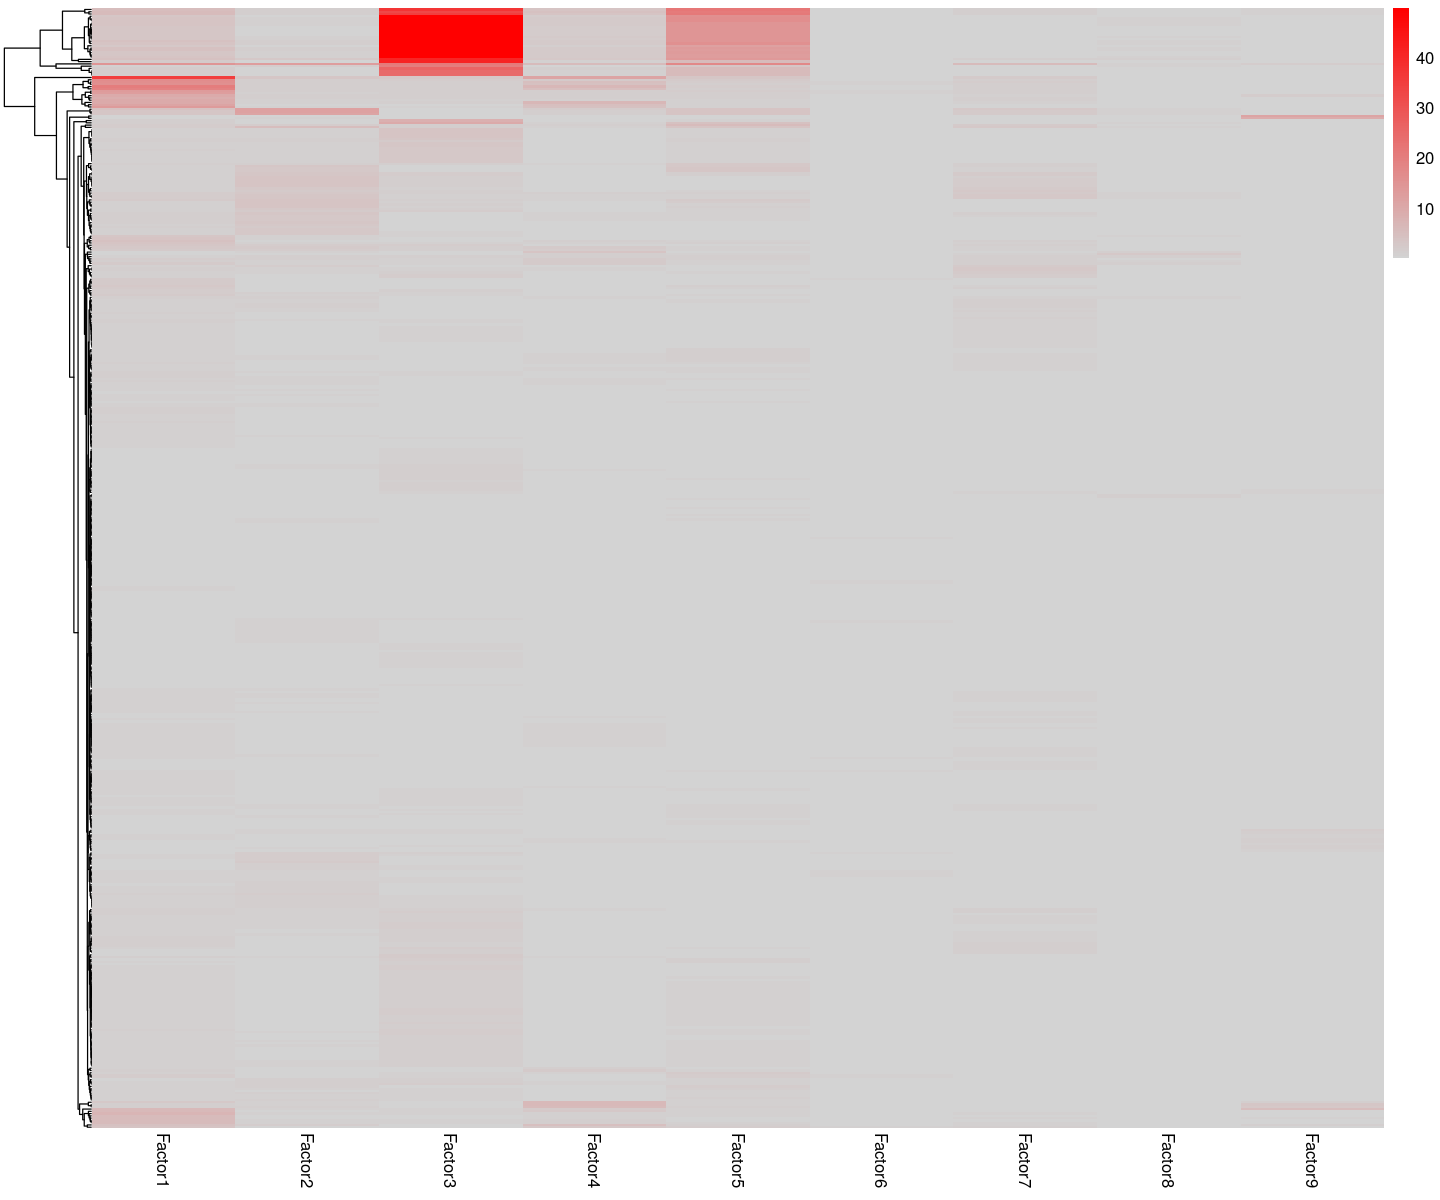

In [8]:
plot_enrichment_heatmap(res_all)

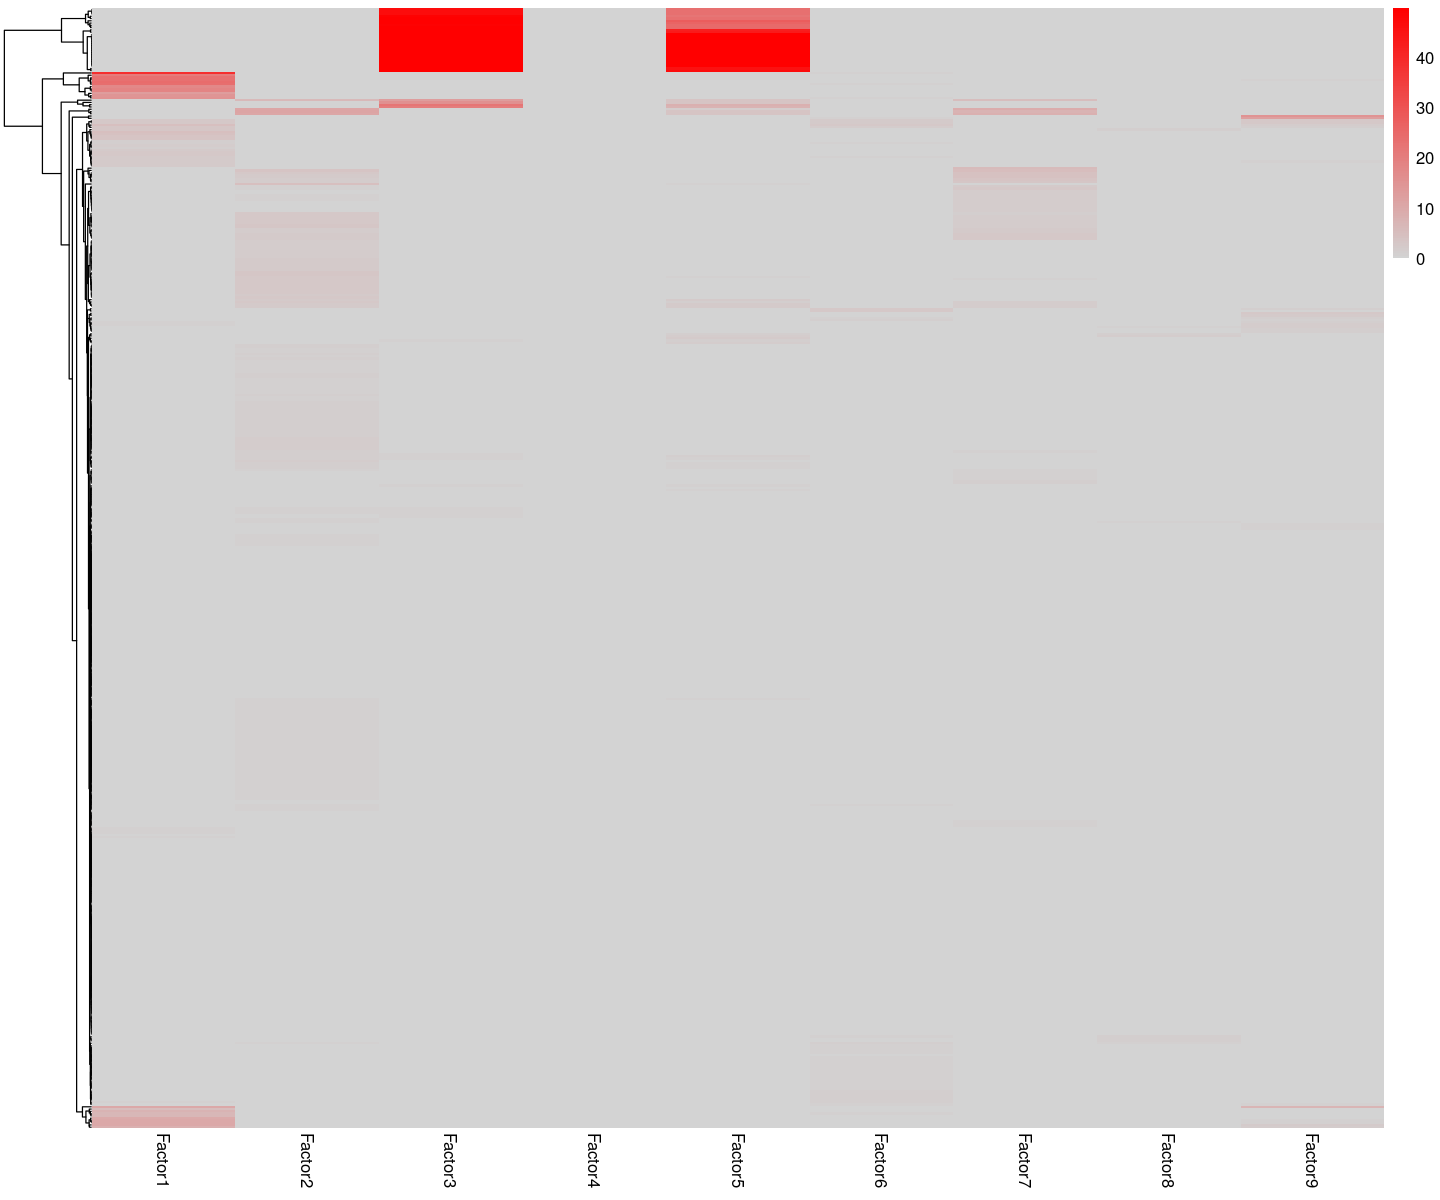

In [11]:
p = plot_enrichment_heatmap(res_pos)

In [ ]:
plot_enrichment()

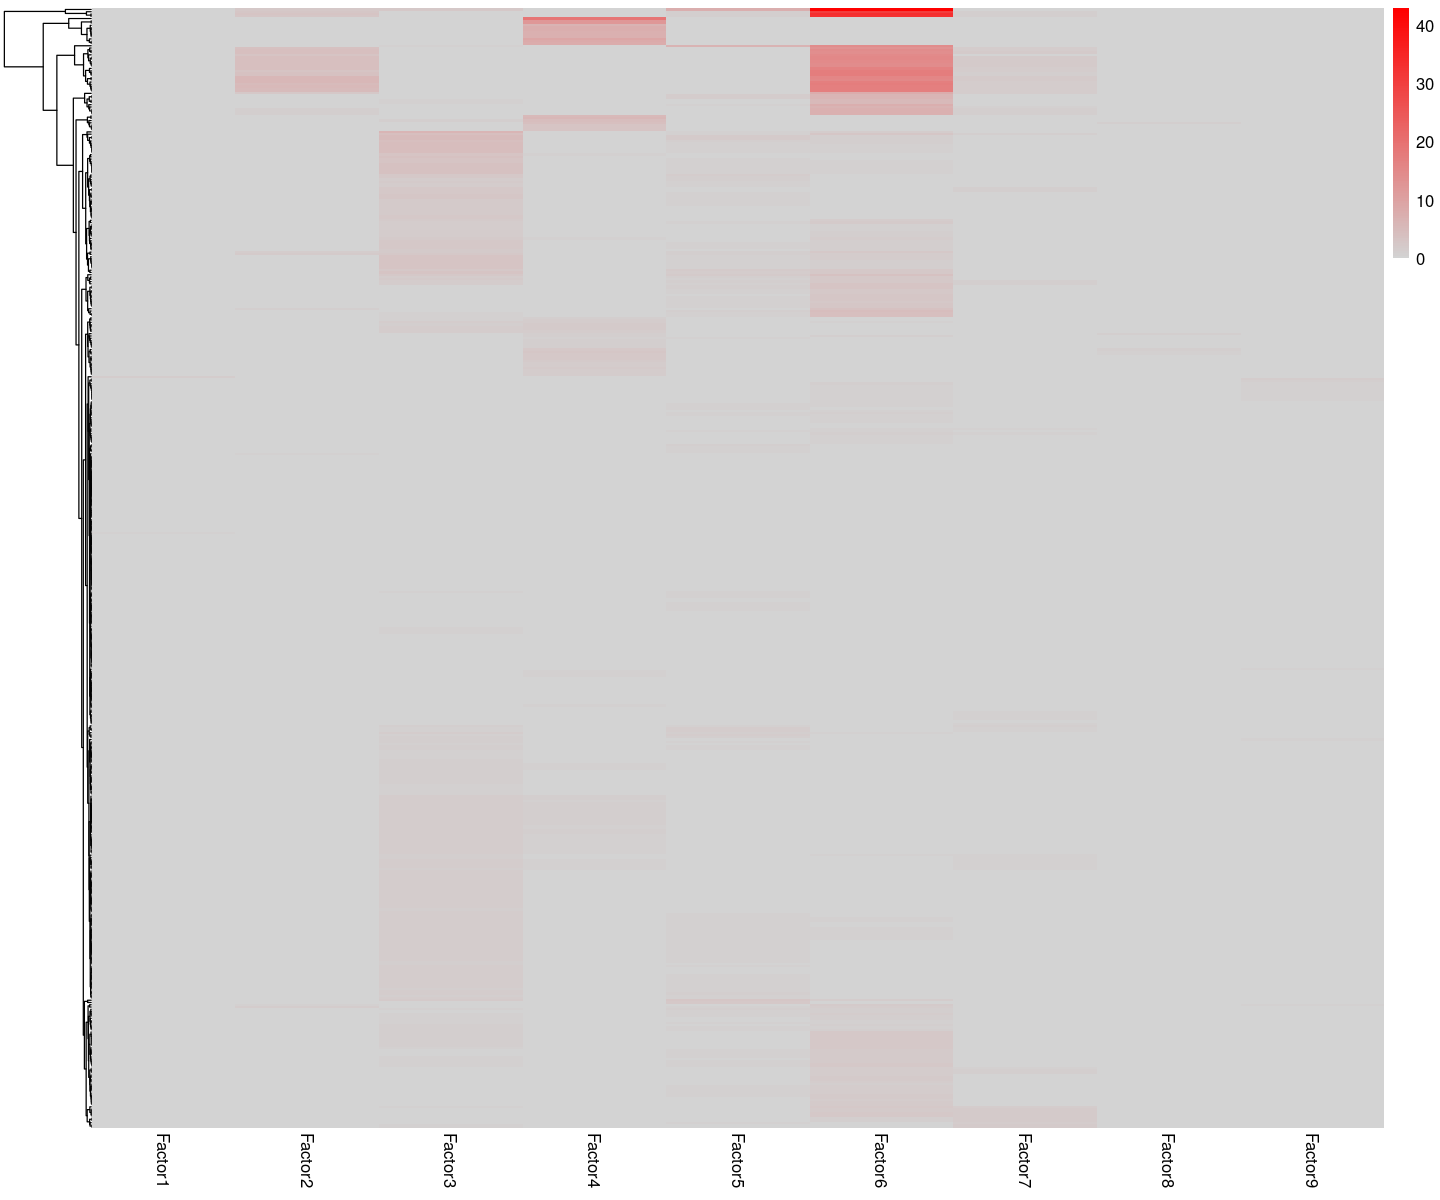

In [12]:
plot_enrichment_heatmap(res_neg)

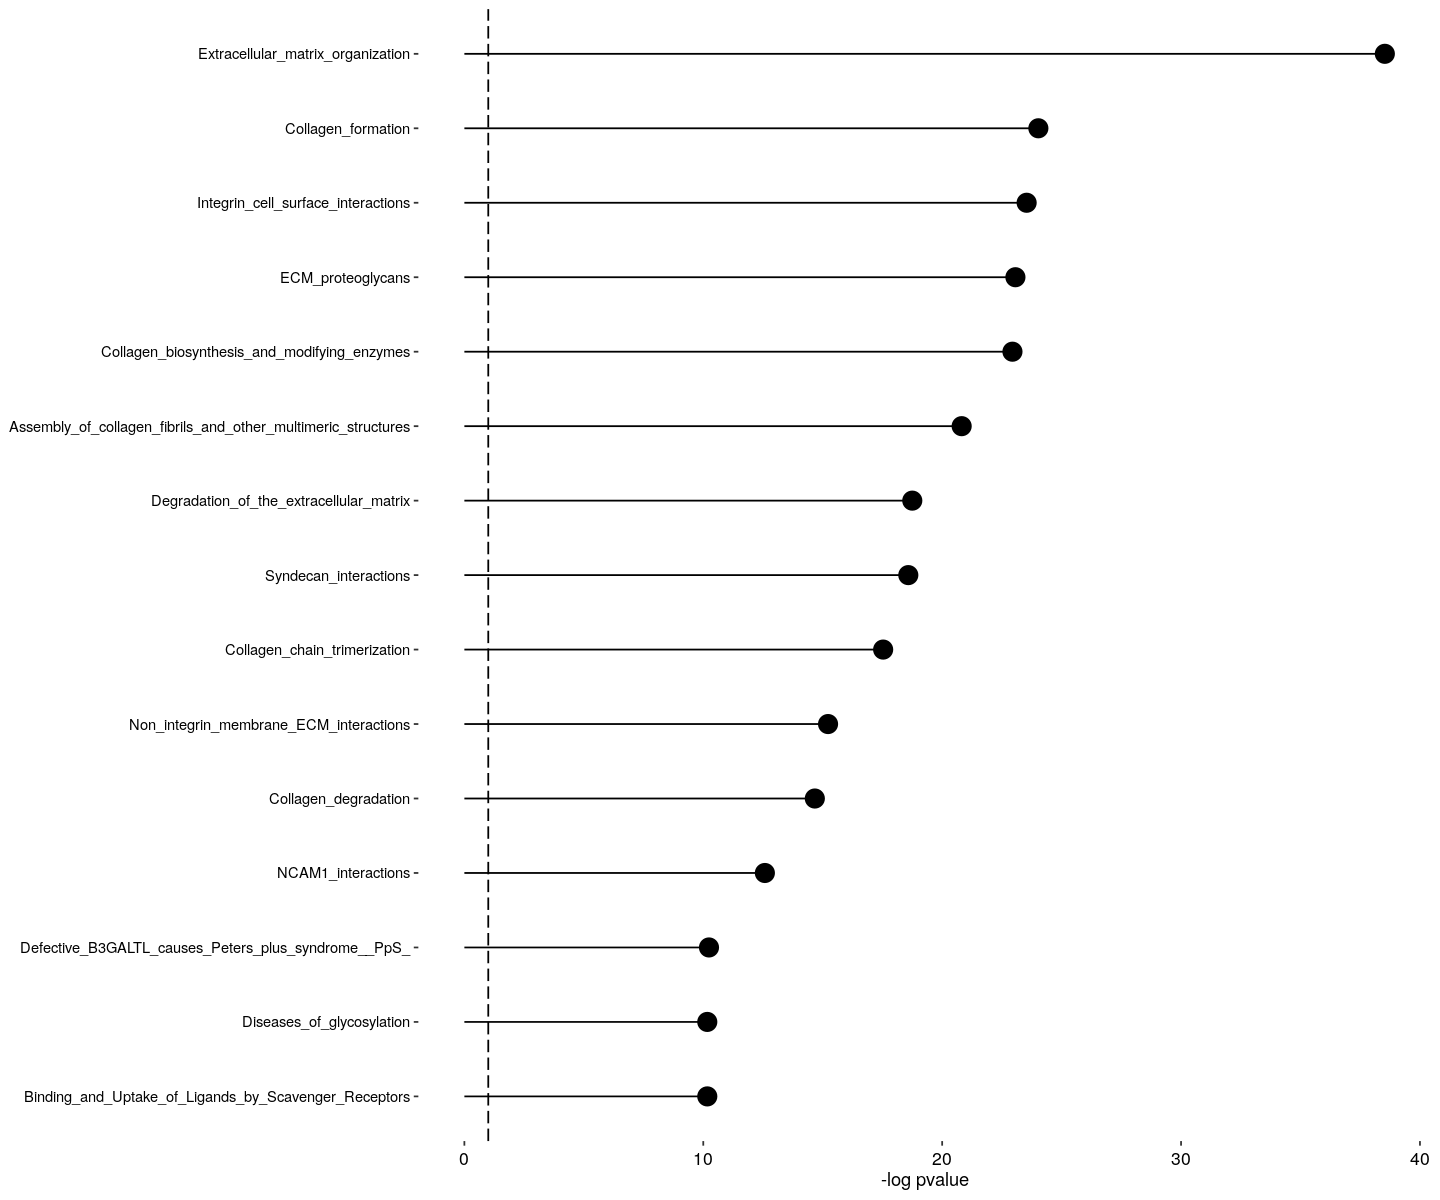

In [13]:
#pdf('Olaparib.fig.MOFA.reactome.pos.pathway.pdf', width = 10)
plot_enrichment(res_pos, factor = 1, max.pathways = 15)
#dev.off()

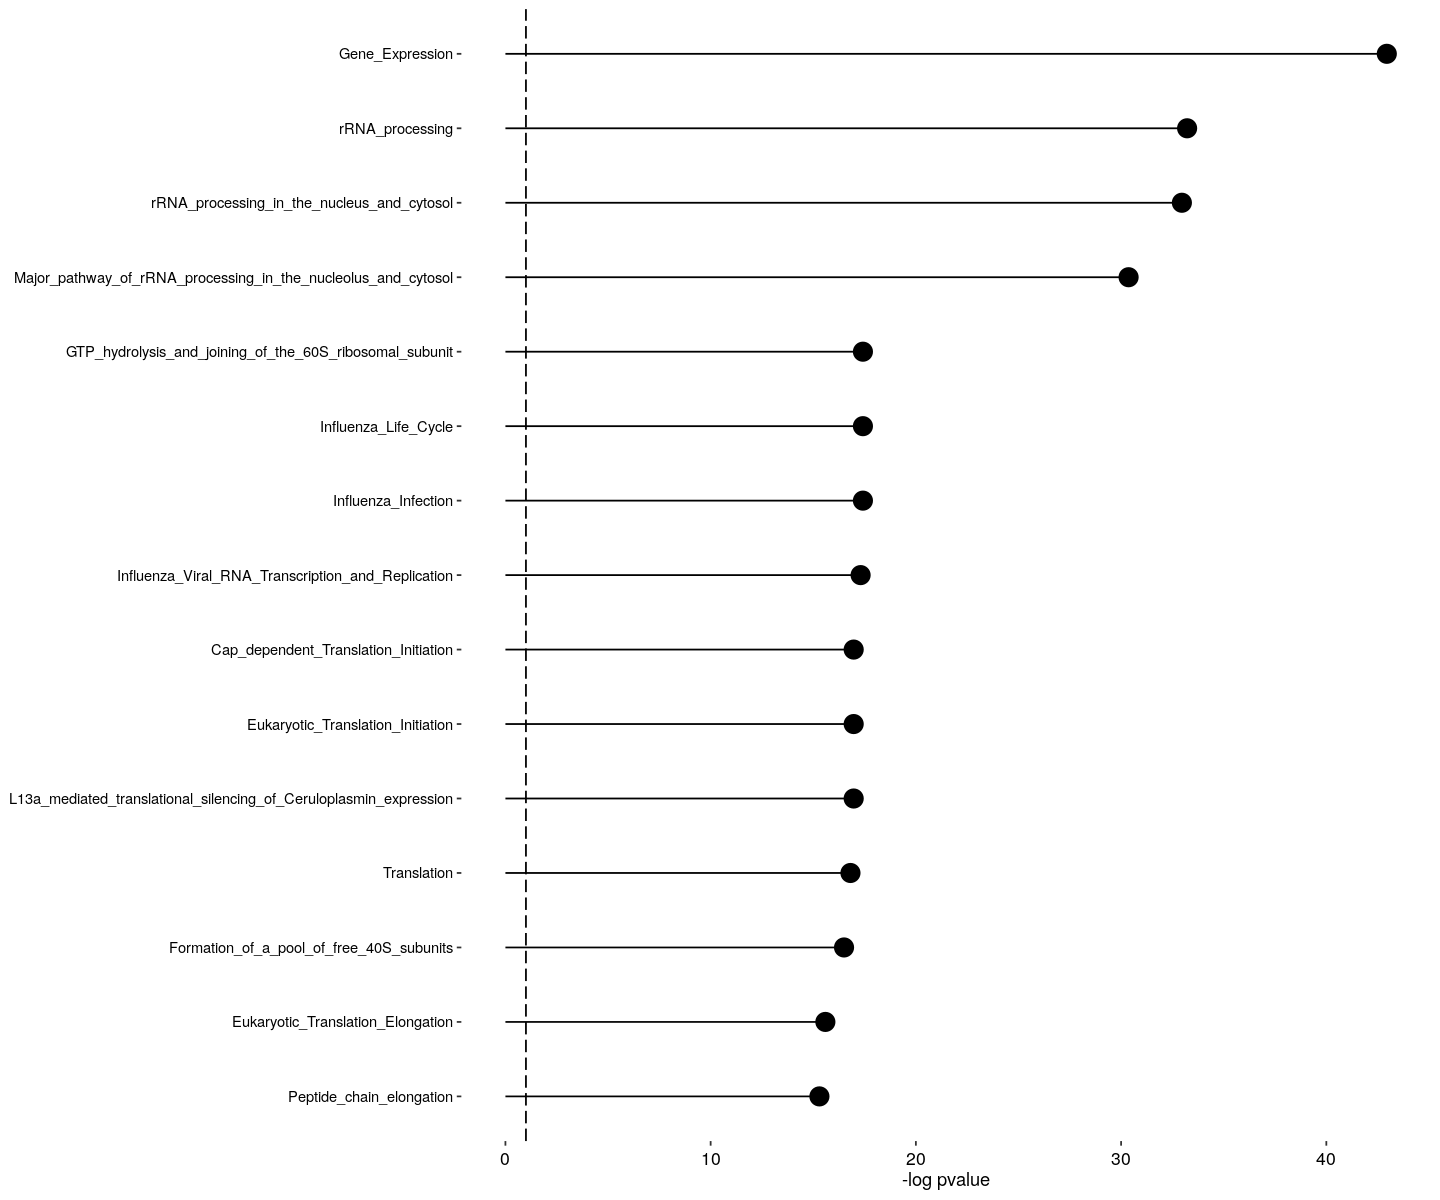

In [14]:
#pdf('Olaparib.fig.MOFA.reactome.neg.pathway.pdf', width = 10)
plot_enrichment(res_neg, factor = 6, max.pathways = 15)
#dev.off()

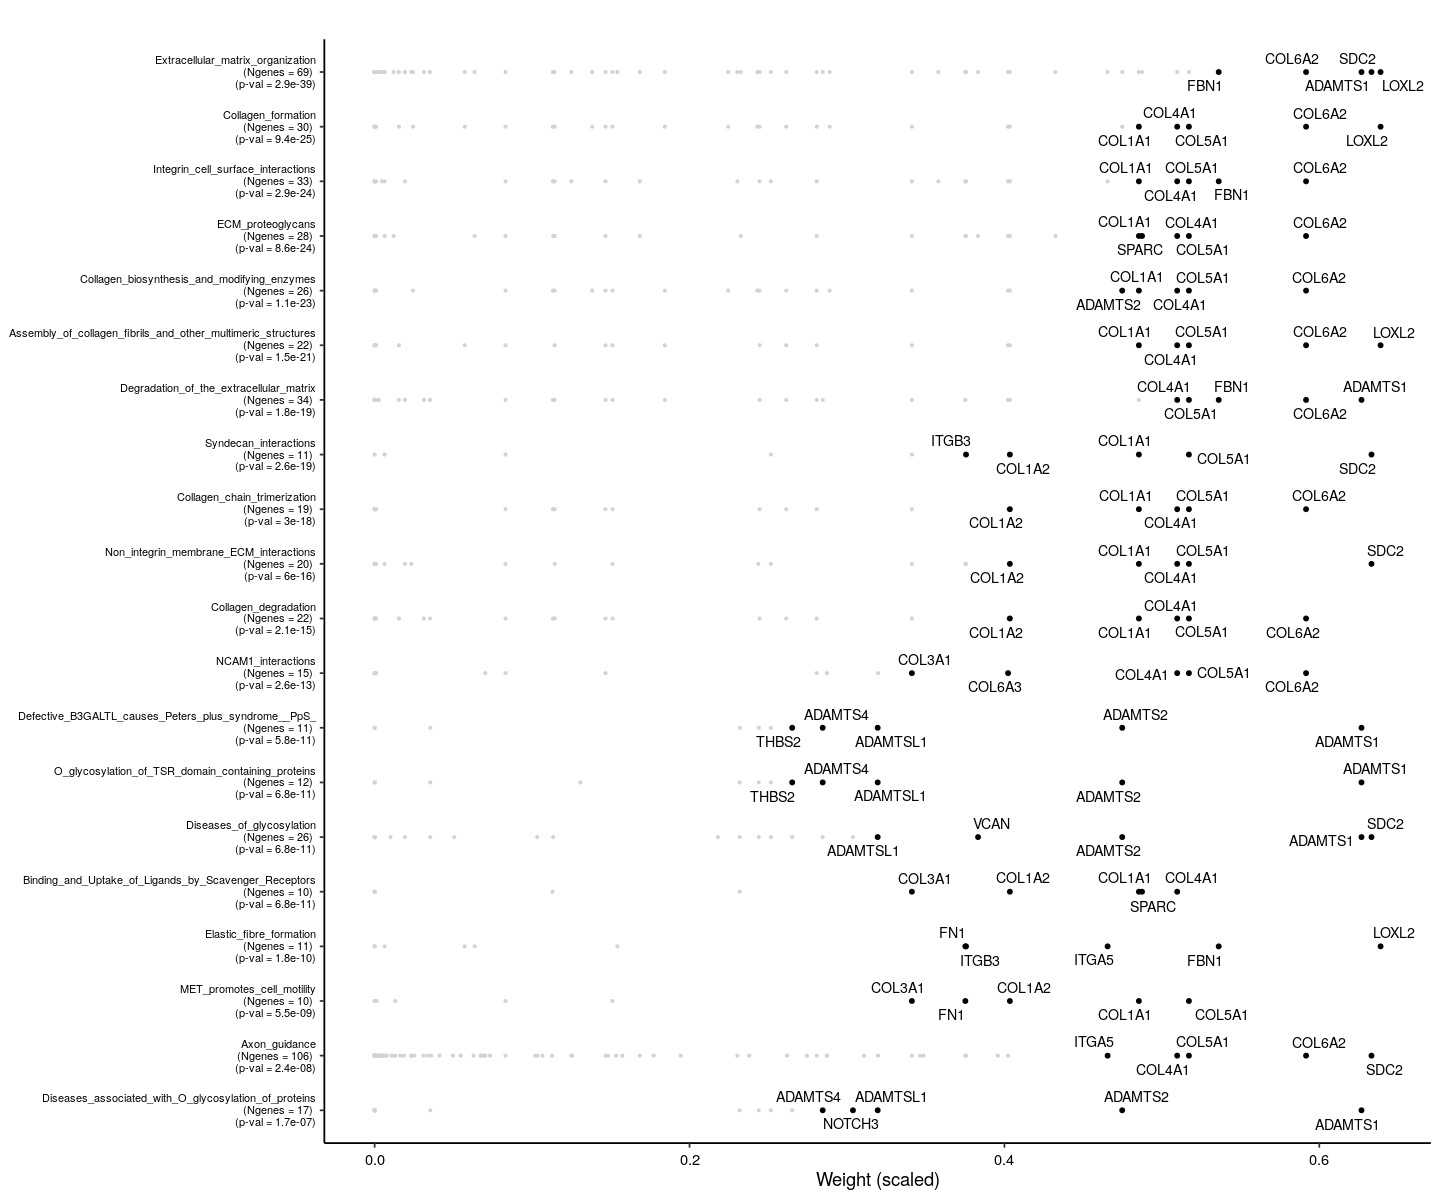

In [15]:
#pdf('Olaparib.fig.MOFA.reactome.pos.pathway.detailed.pdf', width = 10)
plot_enrichment_detailed(
  enrichment.results = res_pos,
  factor = 1, 
  max.pathways =20
)
#dev.off()

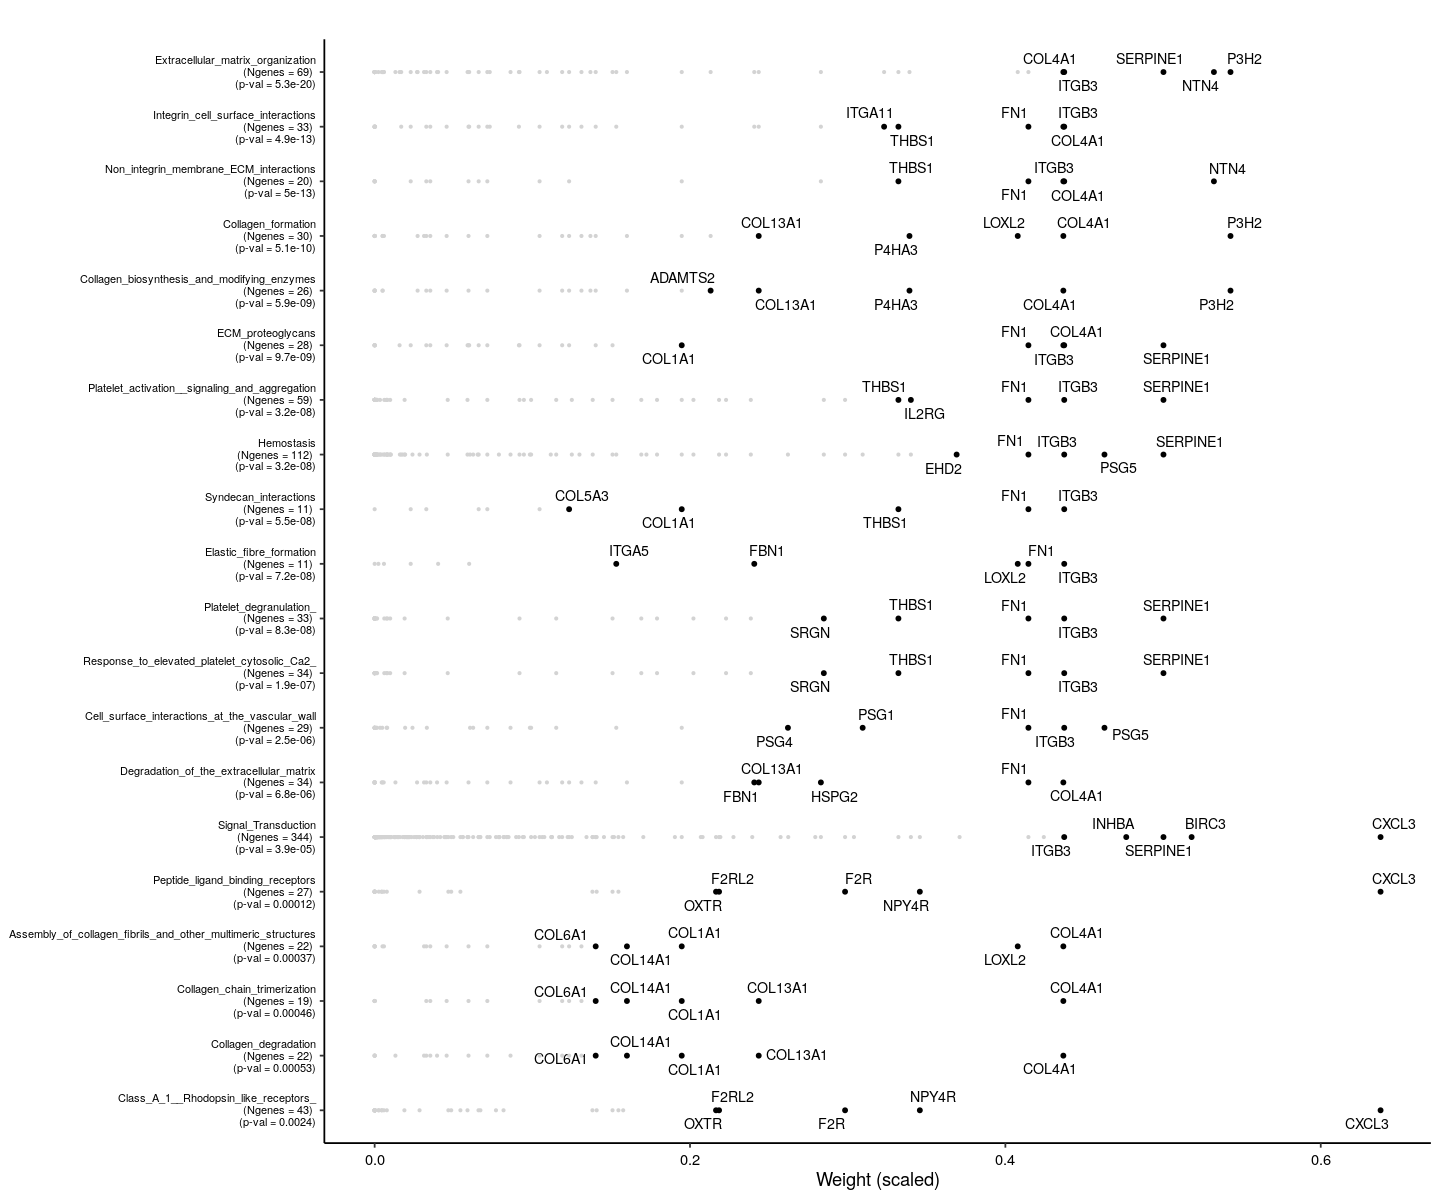

In [16]:
#pdf('Olaparib.fig.MOFA.reactome.neg.pathway.detailed.pdf', width = 10)
plot_enrichment_detailed(
  enrichment.results = res_neg,
  factor = 4, 
  max.pathways = 20
)
#dev.off()

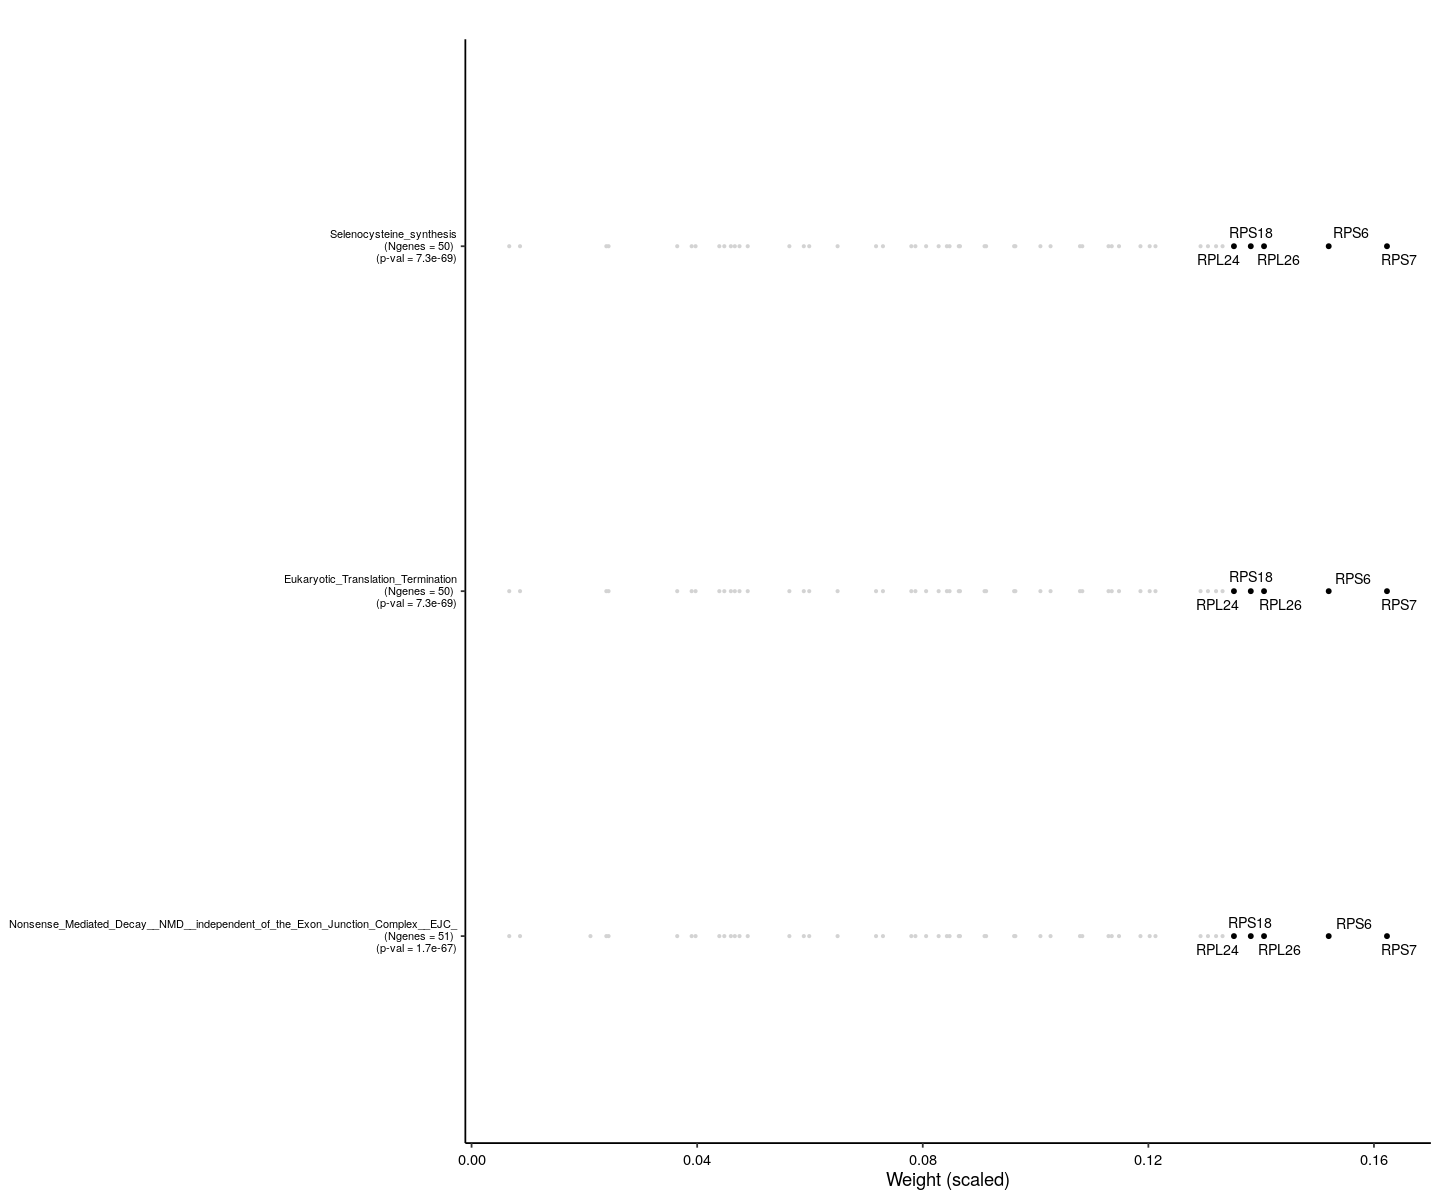

In [10]:
#pdf('Olaparib.fig.MOFA.reactome.neg.pathway.detailed.pdf', width = 10)
plot_enrichment_detailed(
  enrichment.results = res_all,
  factor = 3, 
  max.pathways = 3
)
#dev.off()

## cordination analysis

In [ ]:
set.seed(87)
MOFAobject = run_umap(MOFAobject)

In [ ]:
write.table(MOFAobject@dim_red$UMAP, 'Olaparib.refractory.UMAP.vector.csv', quote = FALSE)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


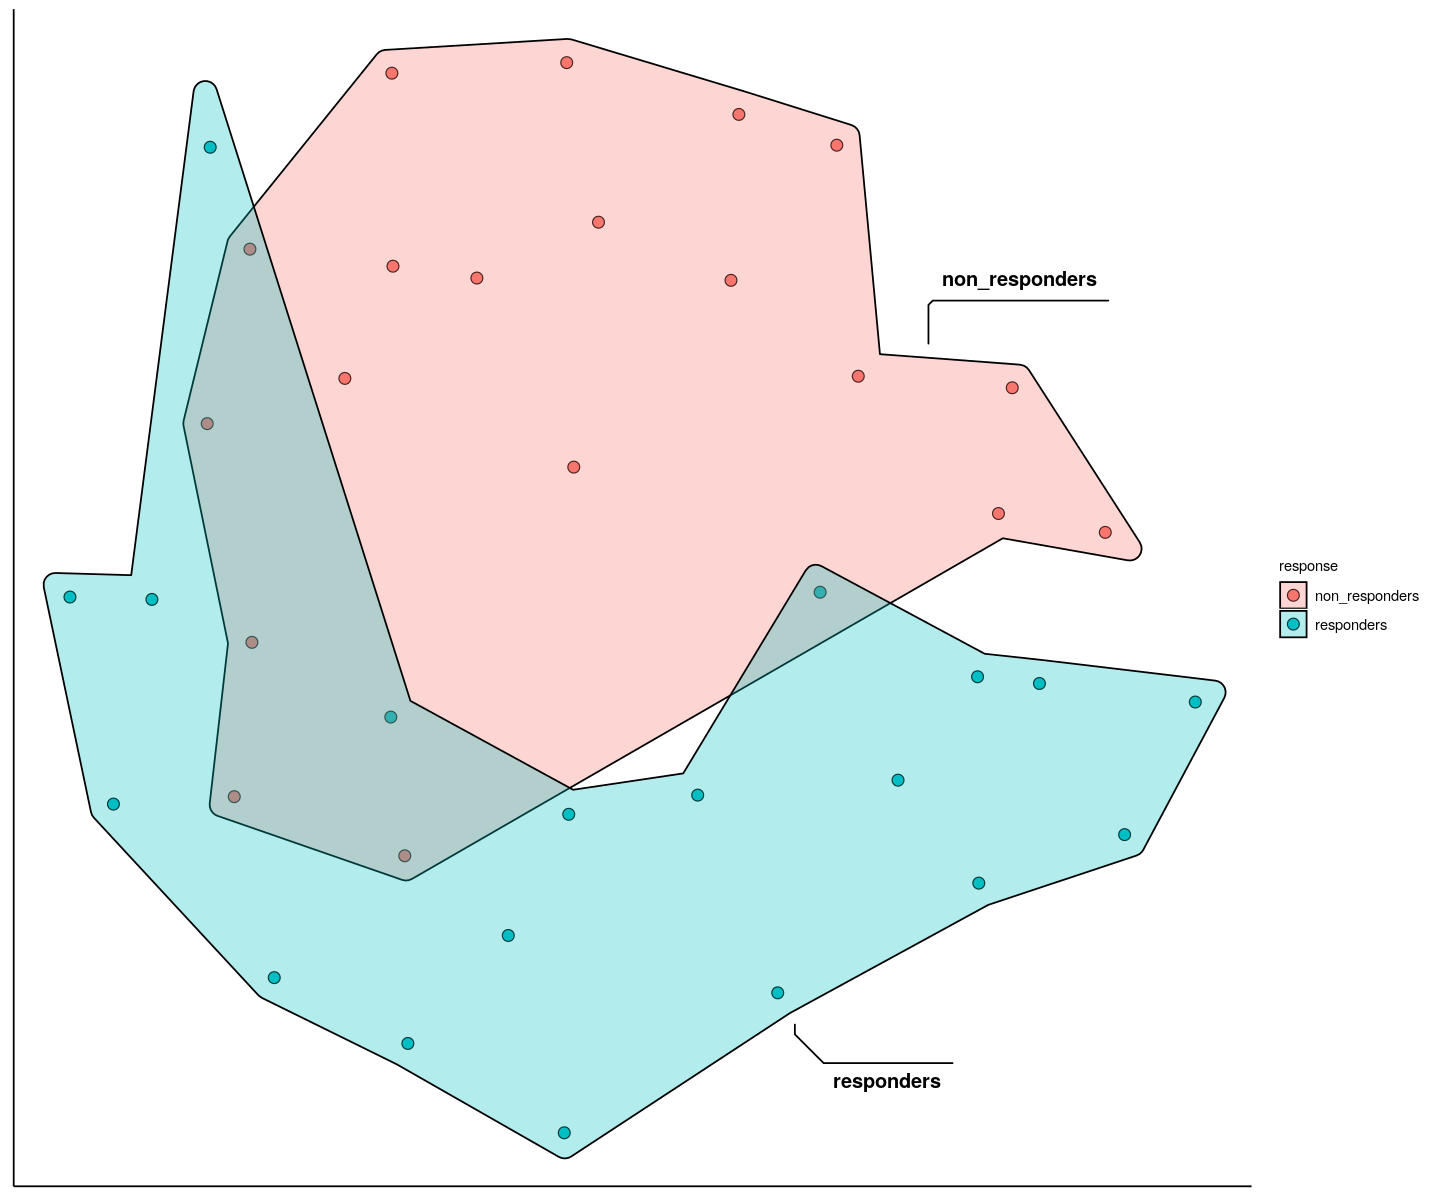

In [17]:
#pdf('Olaparib.fig.MOFA.umap.response.pdf', width = 10)
plot_dimred(MOFAobject, method = 'UMAP', dot_size = 3, color_by = 'response') +
    geom_mark_hull(aes(label = color_by, fill = color_by) ,concavity = 1.8)
#dev.off()

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


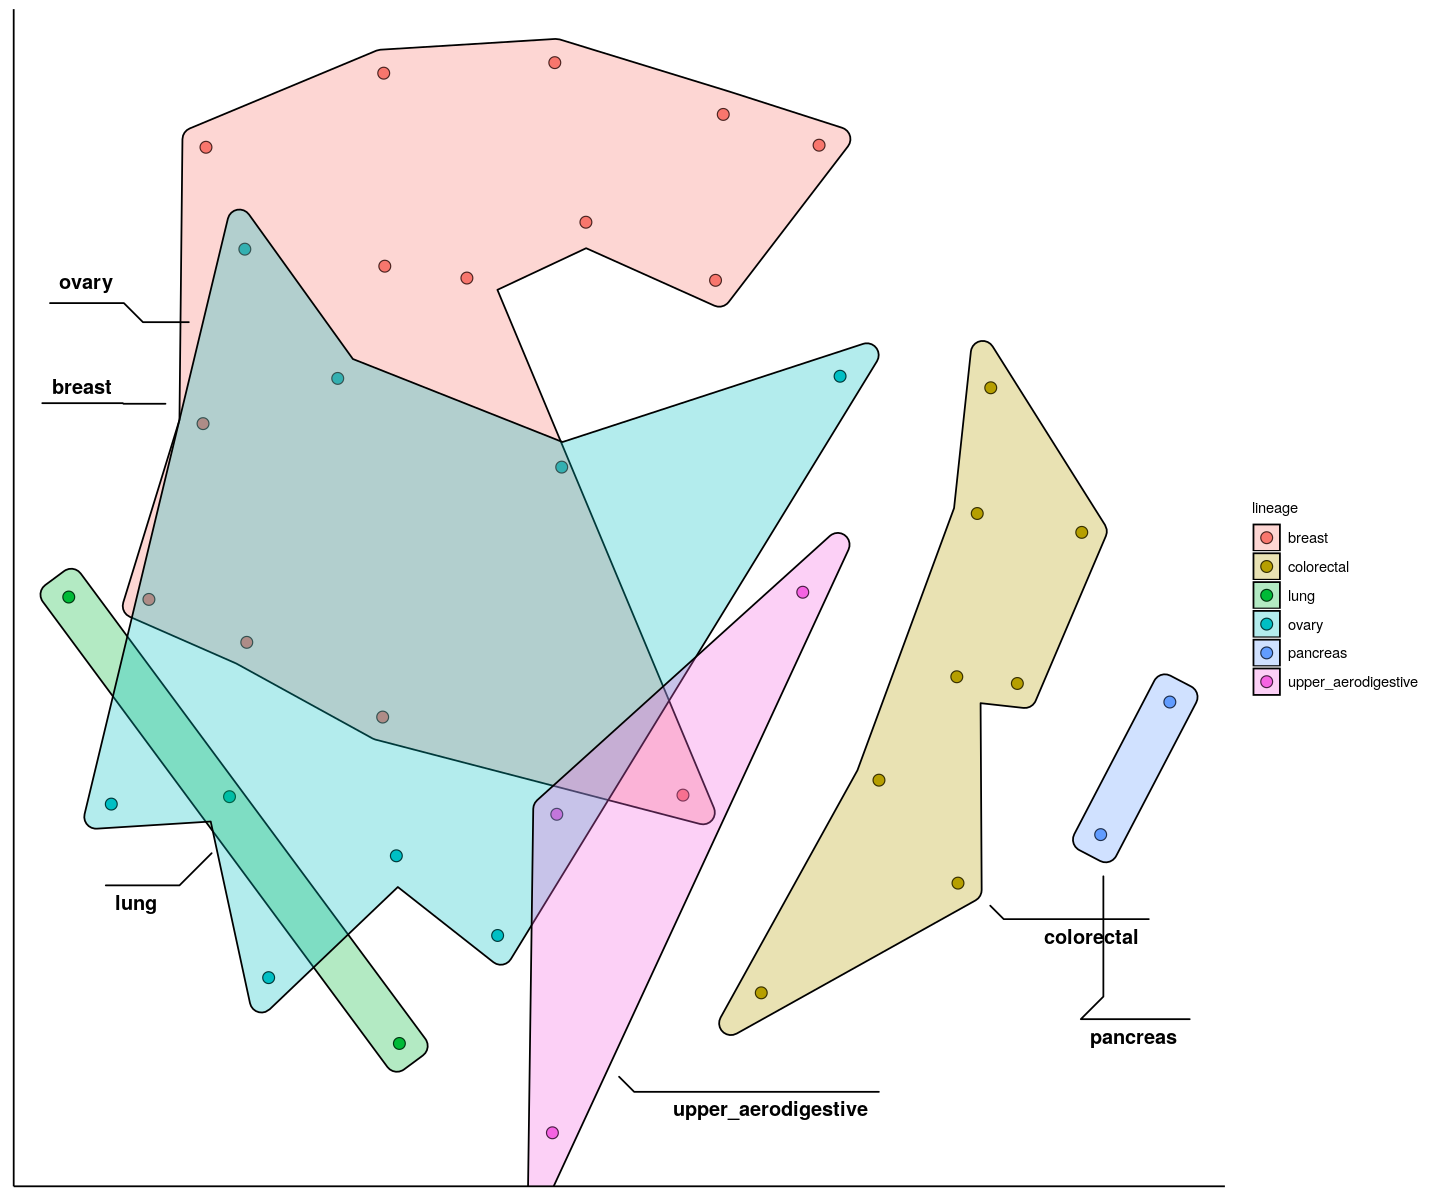

In [18]:
#pdf('Olaparib.fig.MOFA.umap.lineage.pdf', width = 10)
plot_dimred(MOFAobject, method = 'UMAP', dot_size = 3, color_by = 'lineage') +
    geom_mark_hull(aes(label = color_by, fill = color_by) ,concavity = 1.8)
#dev.off()

## Siamese network clssifier

In [121]:
#siamese_tsne = read.csv('MOFA.siamese.predict.out.csv', header = TRUE)
siamese_tsne = read.csv('MOFA.siamese.predict.out.csv', header = TRUE)
my_tsne_plot = function(siamese_tsne) {

    colnames(siamese_tsne) = c('id','x','y','label')
    siamese_tsne['response'] = ''
    siamese_tsne[siamese_tsne['label'] == 1,'response'] = 'responders'
    siamese_tsne[siamese_tsne['label'] == 0,'response'] = 'non_responders'
    siamese_tsne$response = as.factor(siamese_tsne$response)

    p <- ggplot(siamese_tsne, aes_string(x = "x", y = "y", color = 'response')) + 
        theme_classic() + 
        theme(axis.text = element_blank(),
              axis.title = element_blank(), 
              axis.line = element_line(color = "black", 
                size = 0.5), axis.ticks = element_blank()) +
        geom_point(aes(fill = response),
                   color = 'black', pch = 21,
                   size = 3, 
                stroke = 0.5) +
        guides(scale = 'none') +
        scale_alpha_manual(values = 1) +
        geom_mark_hull(aes(label = response, fill = response),
                       color = 'black',
                       pch = 21,
                       concavity = 1.8)
    return(p)
    }
siamese_tsne_p = my_tsne_plot(siamese_tsne)

Warning message:
“Ignoring unknown parameters: shape”


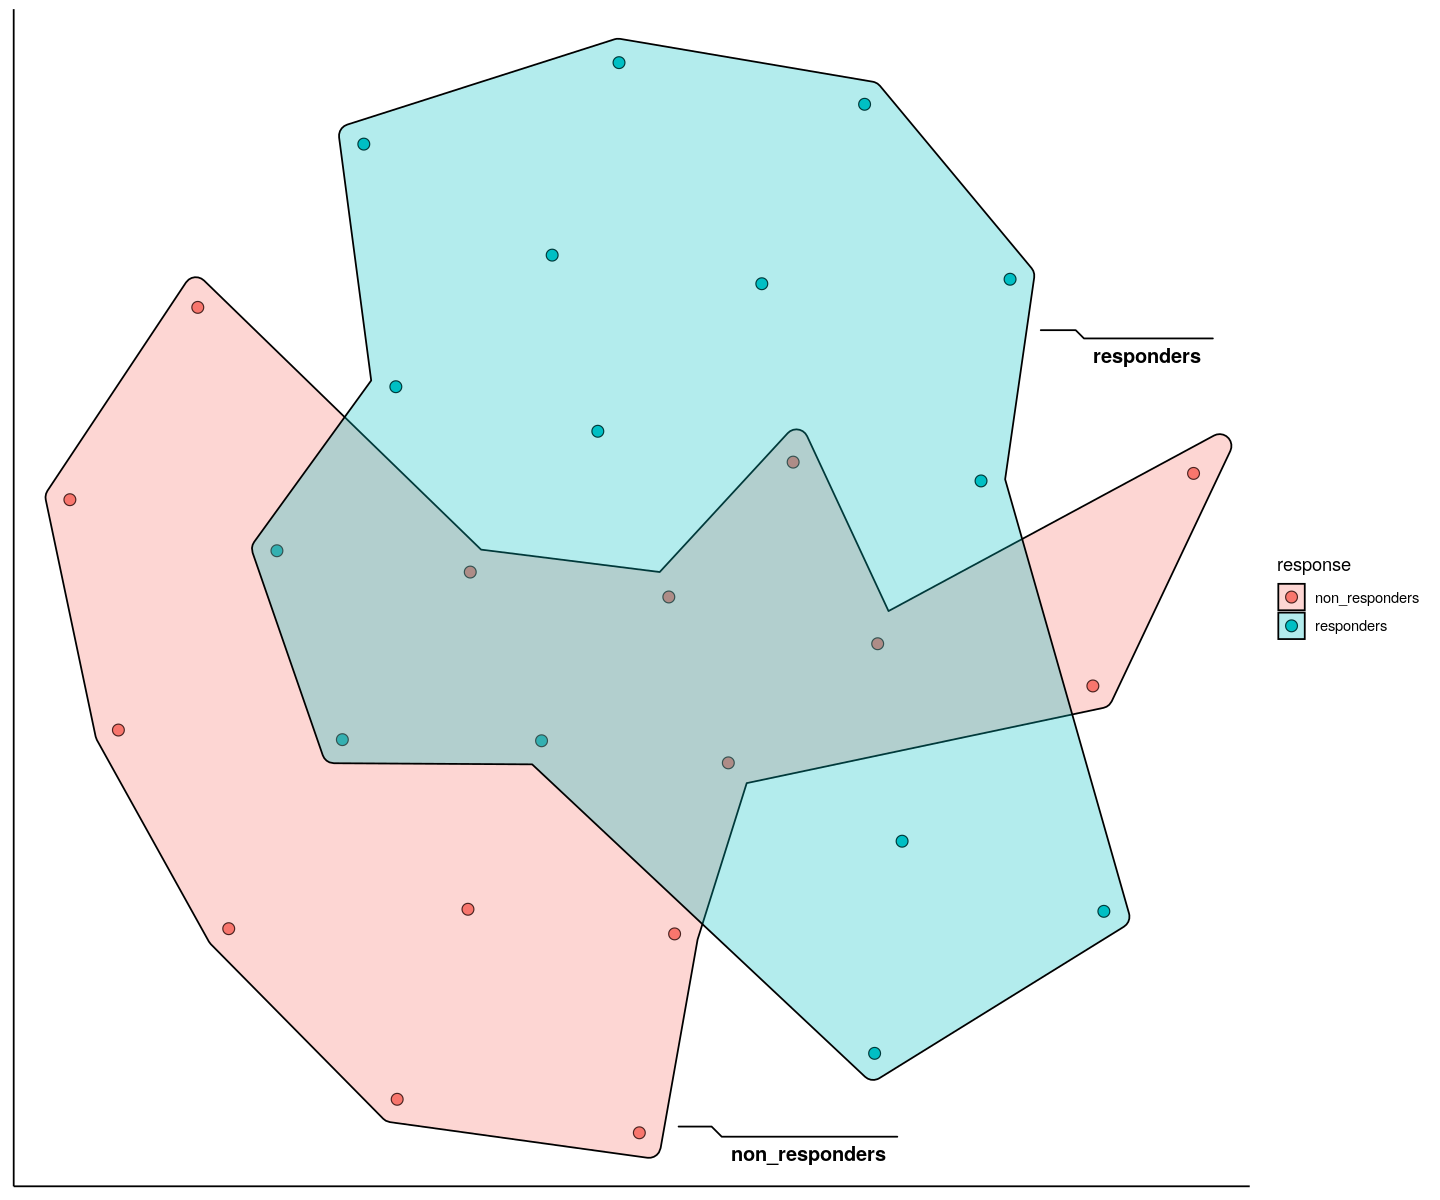

In [122]:
siamese_tsne_p

## Get Feature matrices

In [5]:
#sample_n = 60
cutoff = 0.8
#weights.mut.dt = get_weights(MOFAobject, views = 'Mutations', factors = Mut.f, as.data.frame = T)
#weights.mut.dt$value = abs(weights.mut.dt$value)
#weights.mut.dt = weights.mut.dt[order(-weights.mut.dt$value),]
#mut.features = as.vector(weights.mut.dt[seq(sample_n),]$feature)

weights.mut.dt = get_weights(MOFAobject, views = 'Mutations', factors = Mut.f, as.data.frame = T, abs = T, scale = T)
weights.mut.dt$value = abs(weights.mut.dt$value)
weights.mut.dt = weights.mut.dt[order(-weights.mut.dt$value),]
#mut.features = as.vector(weights.mut.dt[seq(sample_n),]$feature)
mut.features = as.vector(weights.mut.dt[weights.mut.dt$value>=cutoff,]$feature)

weights.exp.dt = get_weights(MOFAobject, views = 'mRNA', factors = mRNA.f, as.data.frame = T, abs = T, scale = T)
weights.exp.dt$value = abs(weights.exp.dt$value)
weights.exp.dt = weights.exp.dt[order(-weights.exp.dt$value),]
#exp.features = as.vector(weights.exp.dt[seq(sample_n),]$feature)
exp.features = as.vector(weights.exp.dt[weights.exp.dt$value>=cutoff,]$feature)

weights.CpG.dt = get_weights(MOFAobject, views = 'Methylations', factors = Methyl.f, as.data.frame = T, abs = T, scale = T)
weights.CpG.dt$value = abs(weights.CpG.dt$value)
weights.CpG.dt = weights.CpG.dt[order(-weights.CpG.dt$value),]
#cpg.features = as.vector(weights.CpG.dt[seq(sample_n),]$feature)
cpg.features = as.vector(weights.CpG.dt[weights.CpG.dt$value>=cutoff,]$feature)

weights.Act.dt = get_weights(MOFAobject, views = 'Activities', factors = Act.f, as.data.frame = T, abs = T, scale = T)
weights.Act.dt$value = abs(weights.Act.dt$value)
weights.Act.dt = weights.Act.dt[order(-weights.Act.dt$value),]
#Act.features = as.vector(weights.Act.dt[seq(sample_n),]$feature)
act.features = as.vector(weights.Act.dt[weights.Act.dt$value>=cutoff,]$feature)

#weights.Path.dt = get_weights(MOFAobject, views = 'Pathway', factors = Path.f, as.data.frame = T, abs = T, scale = T)
#weights.Path.dt$value = abs(weights.Path.dt$value)
#weights.Path.dt = weights.Path.dt[order(-weights.Path.dt$value),]
#Path.features = as.vector(weights.Path.dt[seq(10),]$feature)

In [14]:
write.csv(weights.mut.dt, 'Olaparib.refractory.MOFA.mut_factor.weights.csv', quote = FALSE)
write.csv(weights.exp.dt, 'Olaparib.refractory.MOFA.exp_factor.weights.csv', quote = FALSE)
write.csv(weights.CpG.dt, 'Olaparib.refractory.MOFA.cpg_factor.weights.csv', quote = FALSE)
write.csv(weights.Act.dt, 'Olaparib.refractory.MOFA.act_factor.weights.csv', quote = FALSE)

In [6]:
#rownames(activity) = sapply(strsplit(rownames(activity)," -"), `[`, 1)
cat(paste(sapply(strsplit(mut.features, '_'), `[`, 1),collapse = ', '),",",length(mut.features))
cat('\n')
cat('\n')
cat(paste(exp.features,collapse = ', '),",",length(exp.features))
cat('\n')
cat('\n')
cat(paste(sapply(strsplit(cpg.features, '_'), `[`, 1),collapse = ', '),",",length(cpg.features))
cat('\n')
cat('\n')
cat(paste(act.features,collapse = ', '),",",length(act.features))
cat('\n')
cat(paste(sapply(strsplit(act.features, '_'), `[`, 1),collapse = ', '),",",length(act.features))


IRS1, ZNF365, ARID4B, SLC12A9, CHRM3, ESRP1, CCDC15, ADNP, DDX27, GLYR1, NBEA, SBNO1, RPL22, ARSJ, ACACB, FSIP2, ACVR2A , 17

LYZ, LOXL2, SDC2, ADAMTS1, COL6A2, GNB4 , 6

PDE2A, DENND1C, KIF4B, RAB39A, BRDT, TCAM1P, PAX4, POU2F3, BPIFA2, LINC01620, MYL7, STAR, LTF, TEX36.AS1, ANKRD30A, MIR139, SEPT4.AS1 , 17

ETS1_A, TEAD4_C, MYBL2_C, JUNB_C, KLF6_C, USF2_A, RUNX2_C, TCF4_C, SP1_A, RELA_A, RELB_C, CEBPG_C, MEF2A_C, NFKB1_A, NFATC1_C, TEAD1_C, TCF7L2_A, EGR1_A, TCF12_C, ETV4_A, TCF7_C, MEIS1_C, MAF_C, ELK1_A, LYL1_C , 25
ETS1, TEAD4, MYBL2, JUNB, KLF6, USF2, RUNX2, TCF4, SP1, RELA, RELB, CEBPG, MEF2A, NFKB1, NFATC1, TEAD1, TCF7L2, EGR1, TCF12, ETV4, TCF7, MEIS1, MAF, ELK1, LYL1 , 25

In [25]:
marker.mut = sapply(strsplit(mut.features, '_'), `[`, 1)
marker.exp = exp.features
marker.cpg = sapply(strsplit(cpg.features, '_'), `[`, 1)
marker.act = sapply(strsplit(act.features, '_'), `[`, 1)

In [26]:
biomarker.updown = c(indicators_up, indicators_down)

In [27]:
options(repr.plot.width=30, repr.plot.height=10)

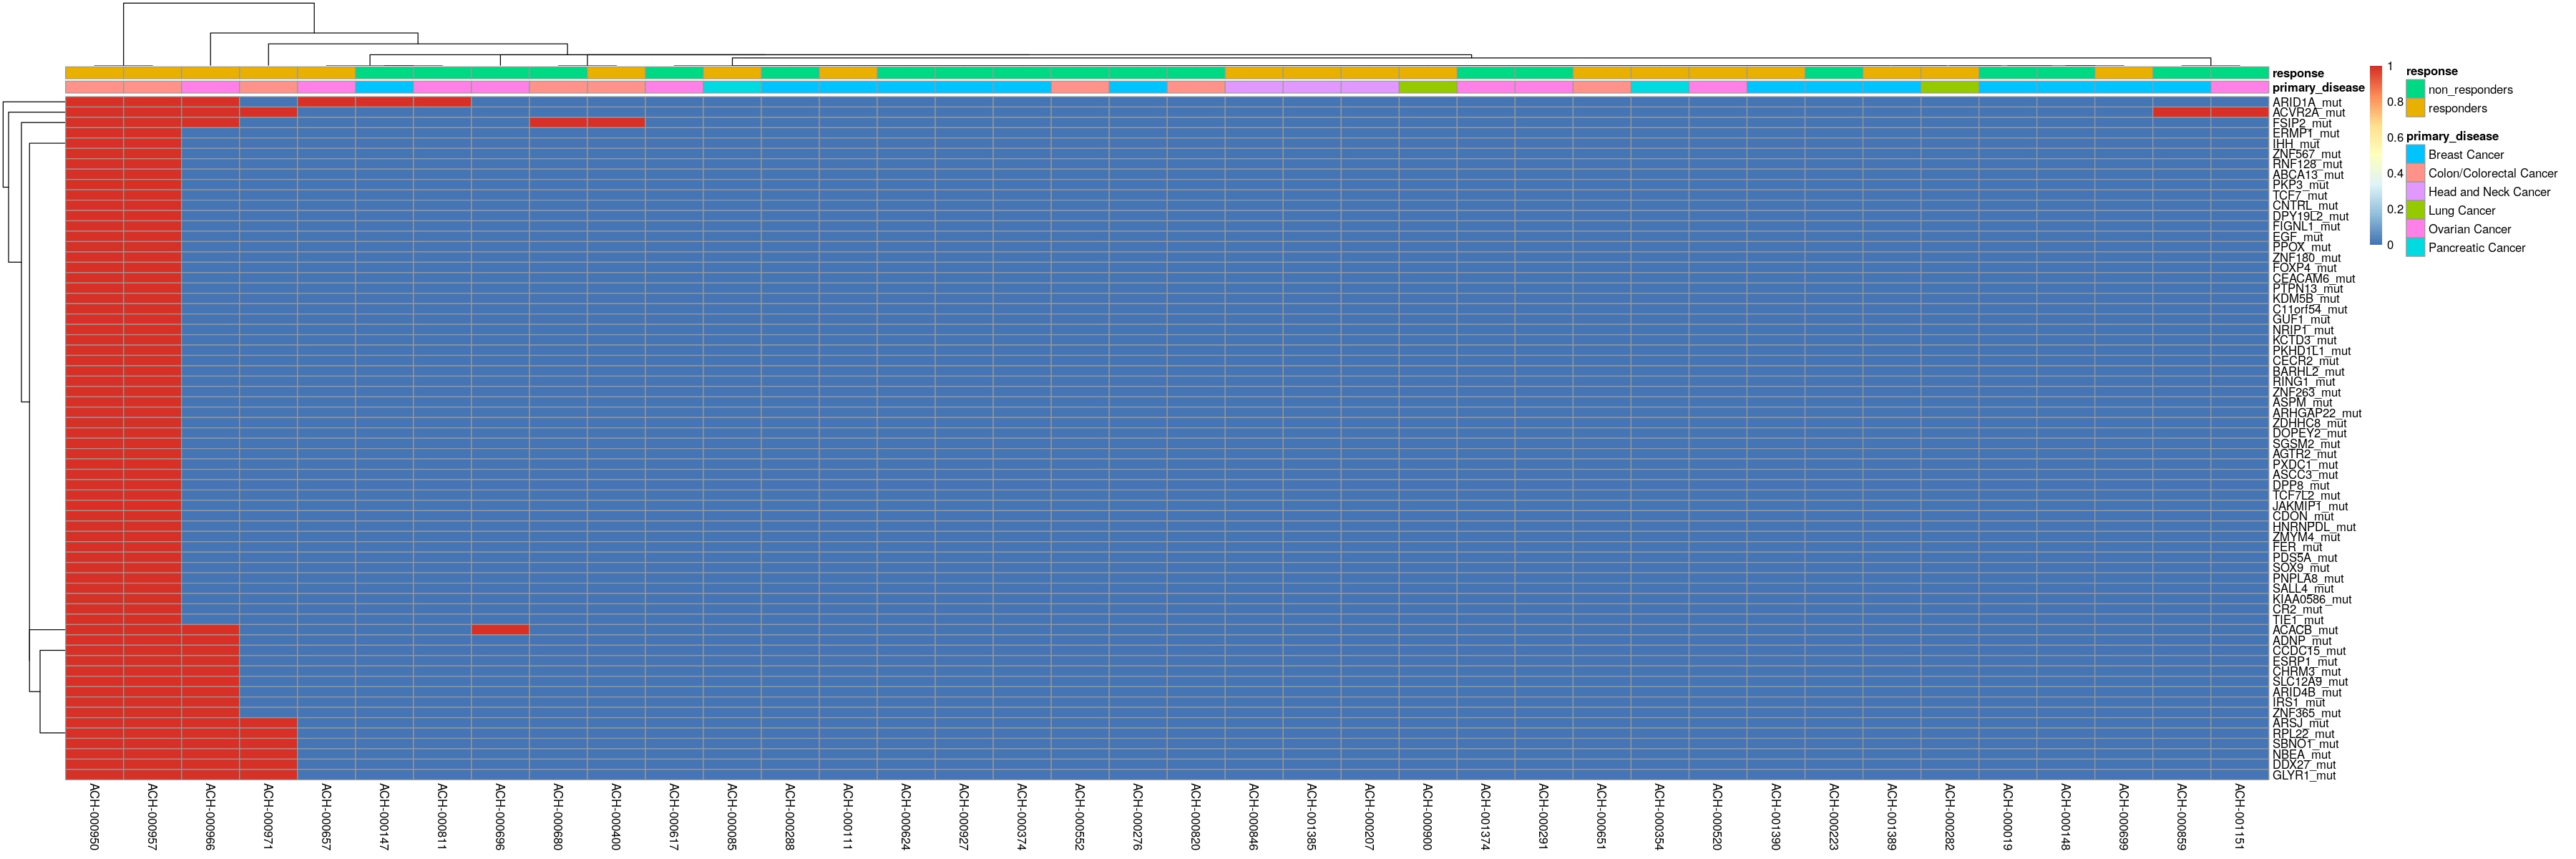

In [28]:

#pdf('Olaparib.fig.MOFA.important.data.mut.pdf', width = 10, height = 8)

ann_colors = list(group = c(responders = 'red', non_responders = 'green'))
plot_data_heatmap(MOFAobject,
                 view = 'Mutations',
                 features = mut.features,
                 factor = Mut.f,
                 annotation_samples = c('primary_disease','response'),
                 annotation_colors = ann_colors)
#dev.off()

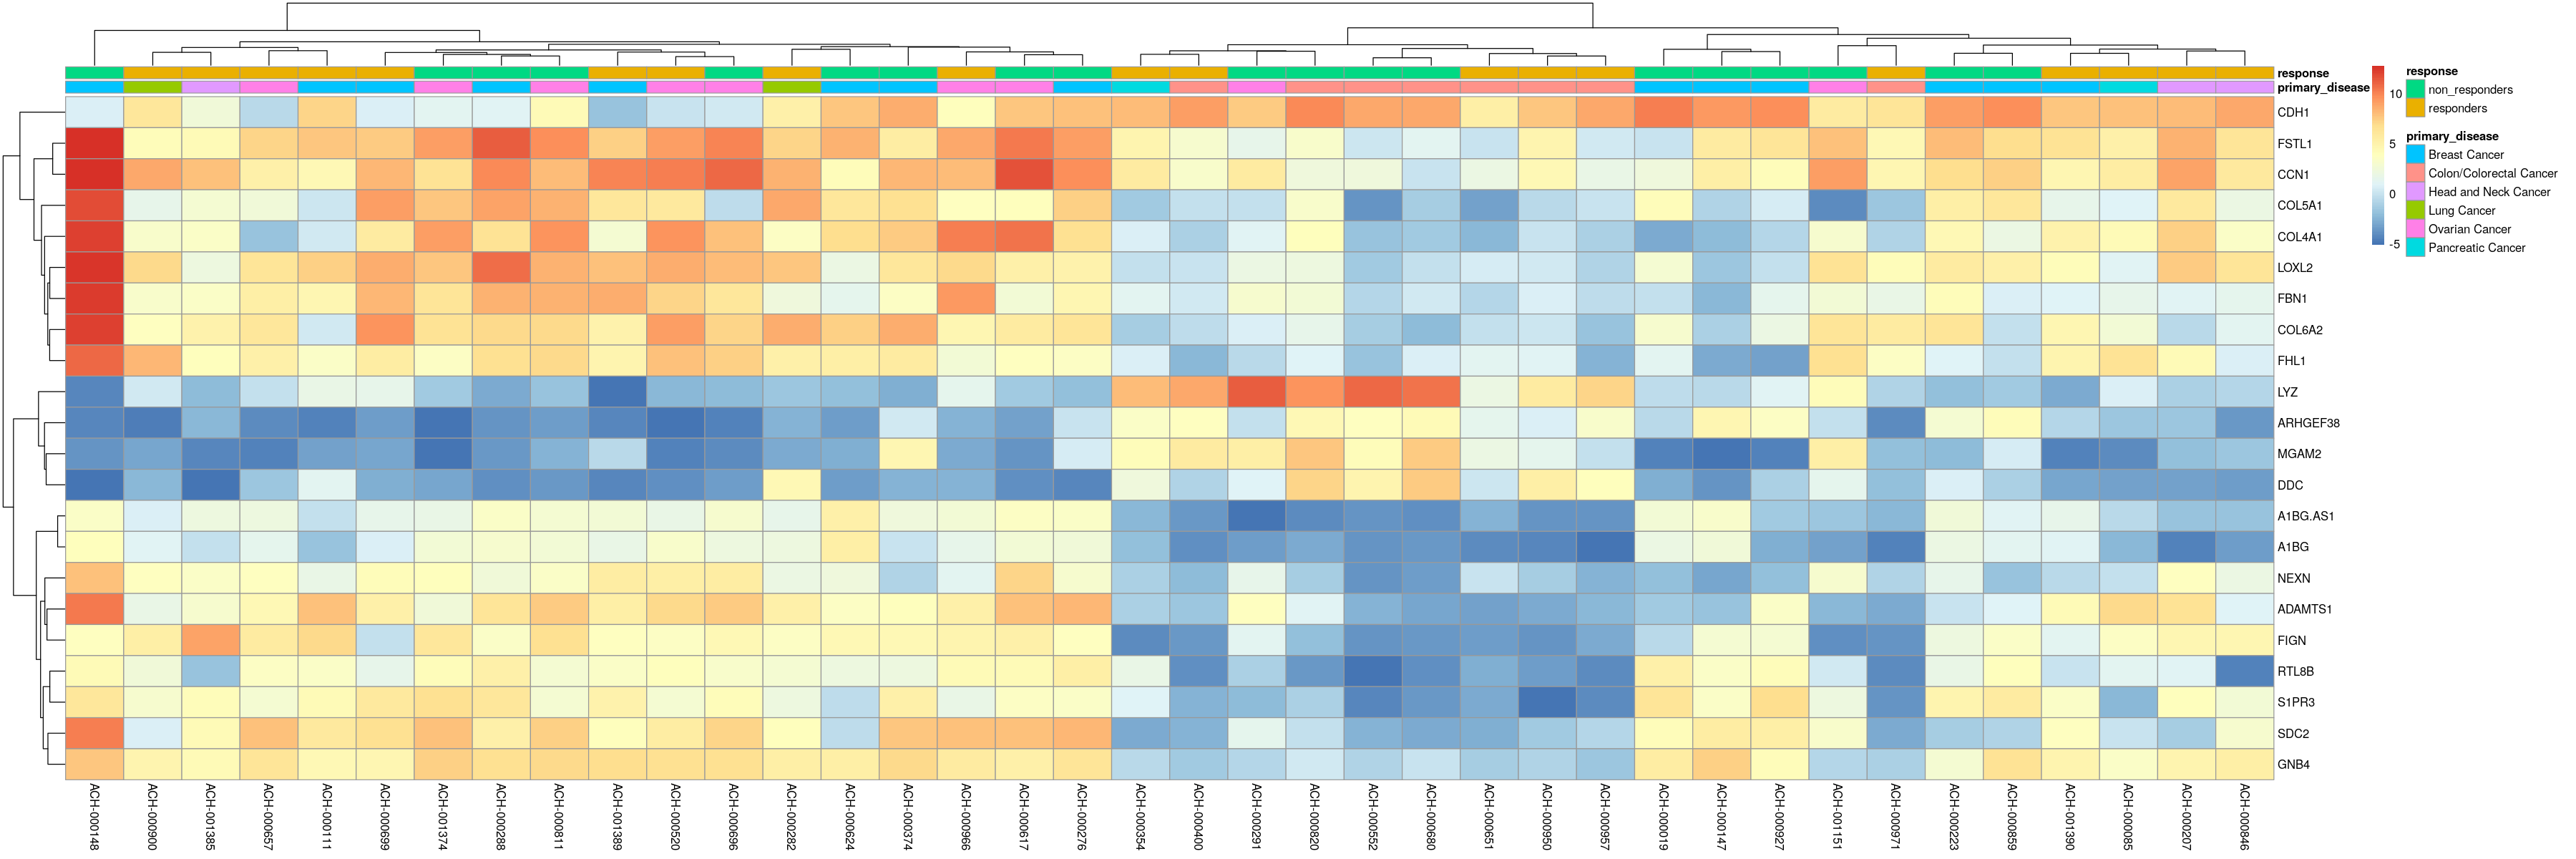

In [29]:
plot_data_heatmap(MOFAobject,
                 view = 'mRNA',
                 features = exp.features,
                 denoise = FALSE,
                 factor = mRNA.f,
                  annotation_colors = ann_colors,
                 annotation_samples = c('primary_disease', 'response'))

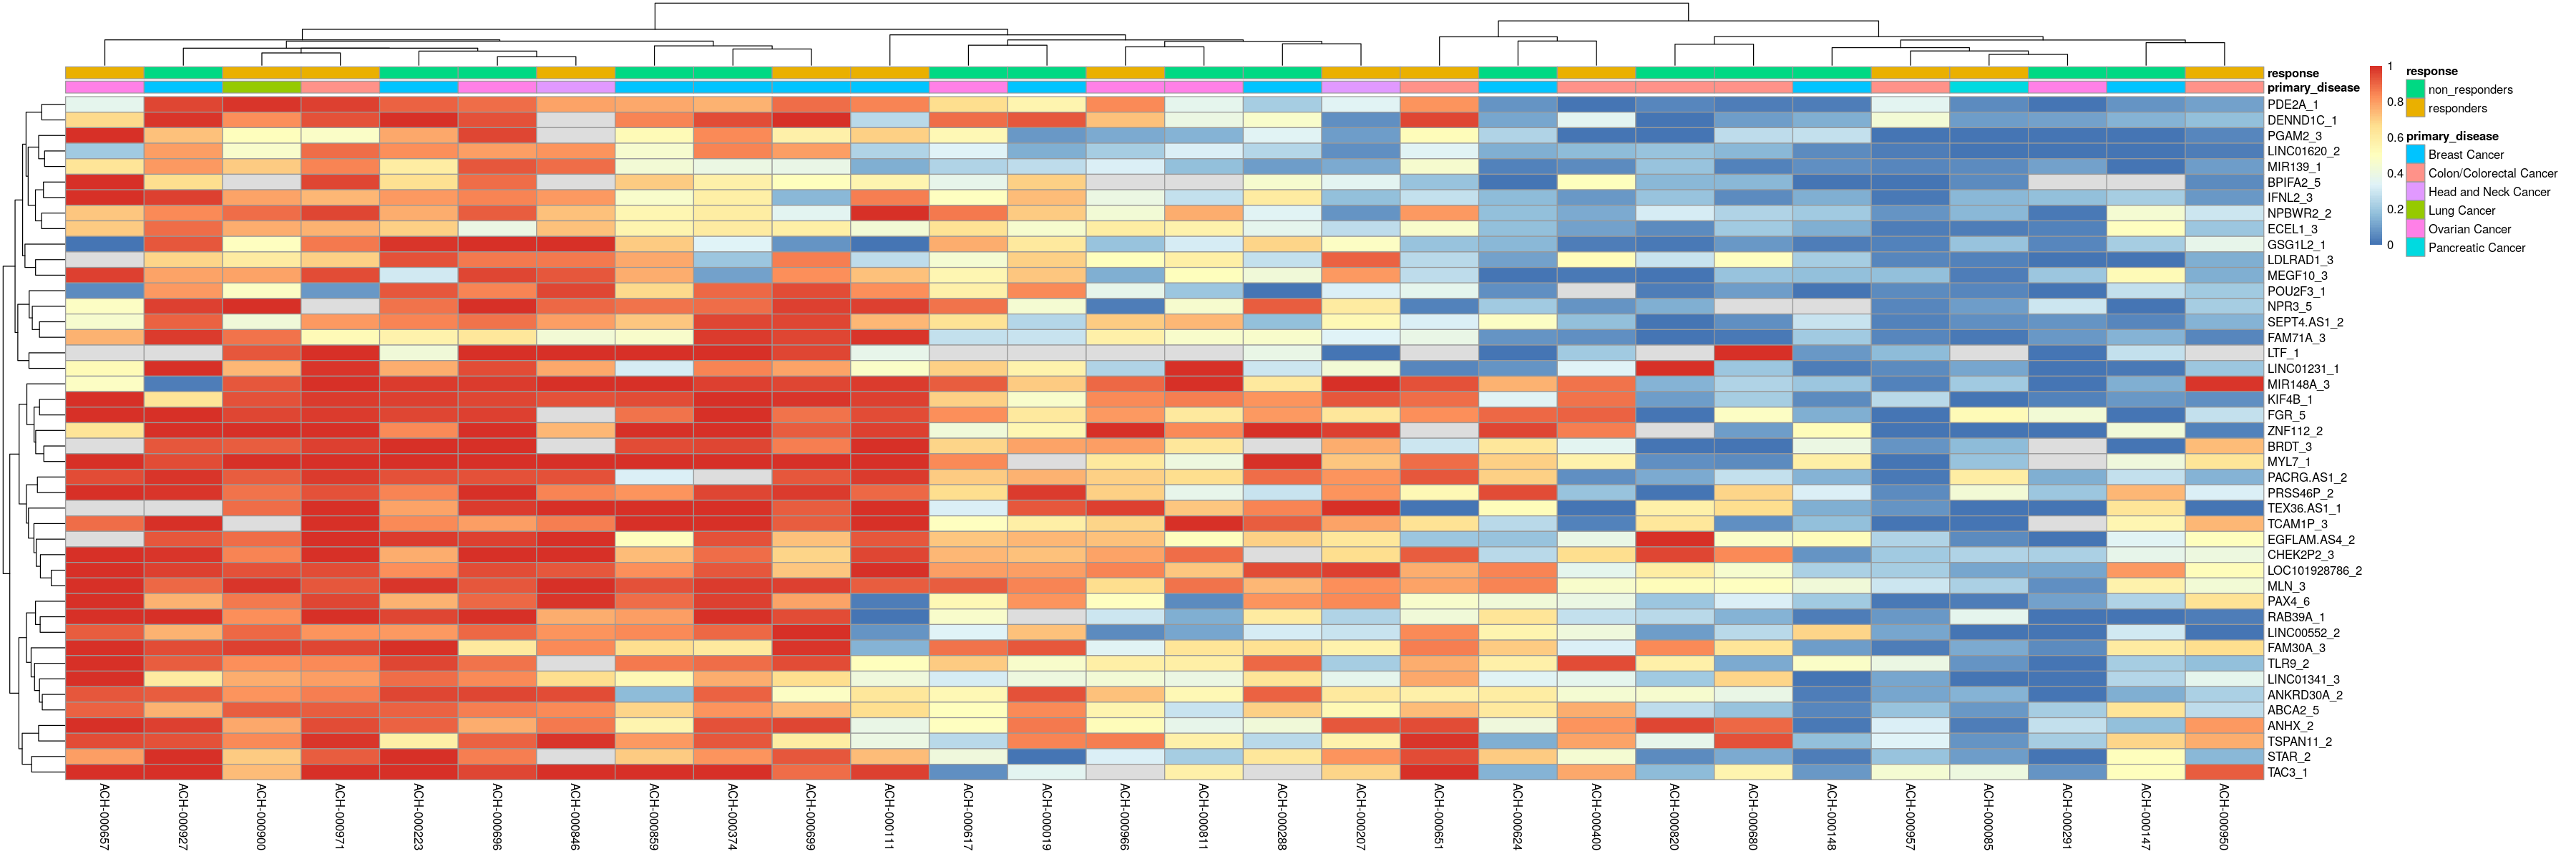

In [30]:
plot_data_heatmap(MOFAobject,
                 view = 'Methylations',
                 features = cpg.features,
                 denoise = FALSE,
                 factor = Methyl.f,
                  annotation_colors = ann_colors,
                 annotation_samples = c('primary_disease', 'response'))

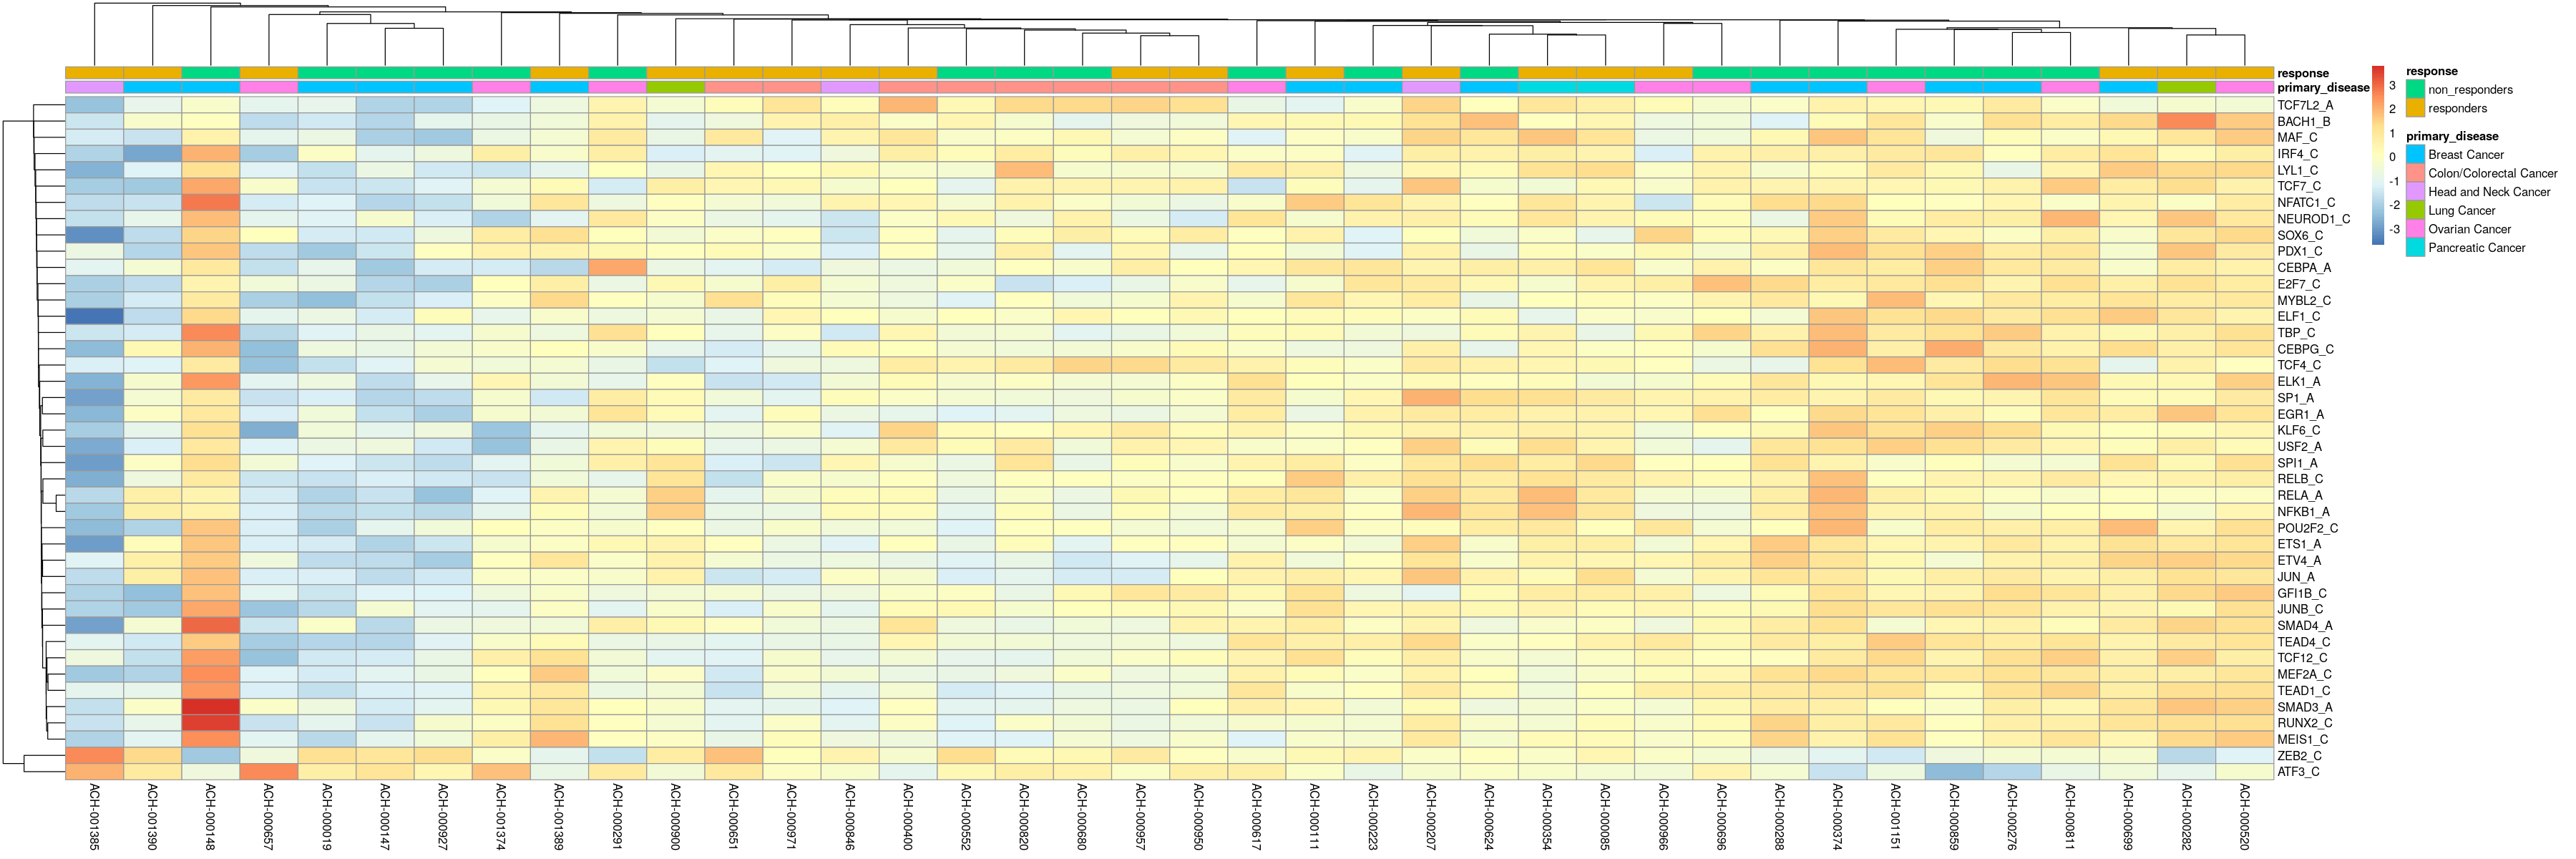

In [31]:
plot_data_heatmap(MOFAobject,
                 view = 'Activities',
                 features = act.features,
                 denoise = FALSE,
                 factor = Act.f,
                  annotation_colors = ann_colors,
                  clustering_method = 'single',
                 annotation_samples = c('primary_disease', 'response'))

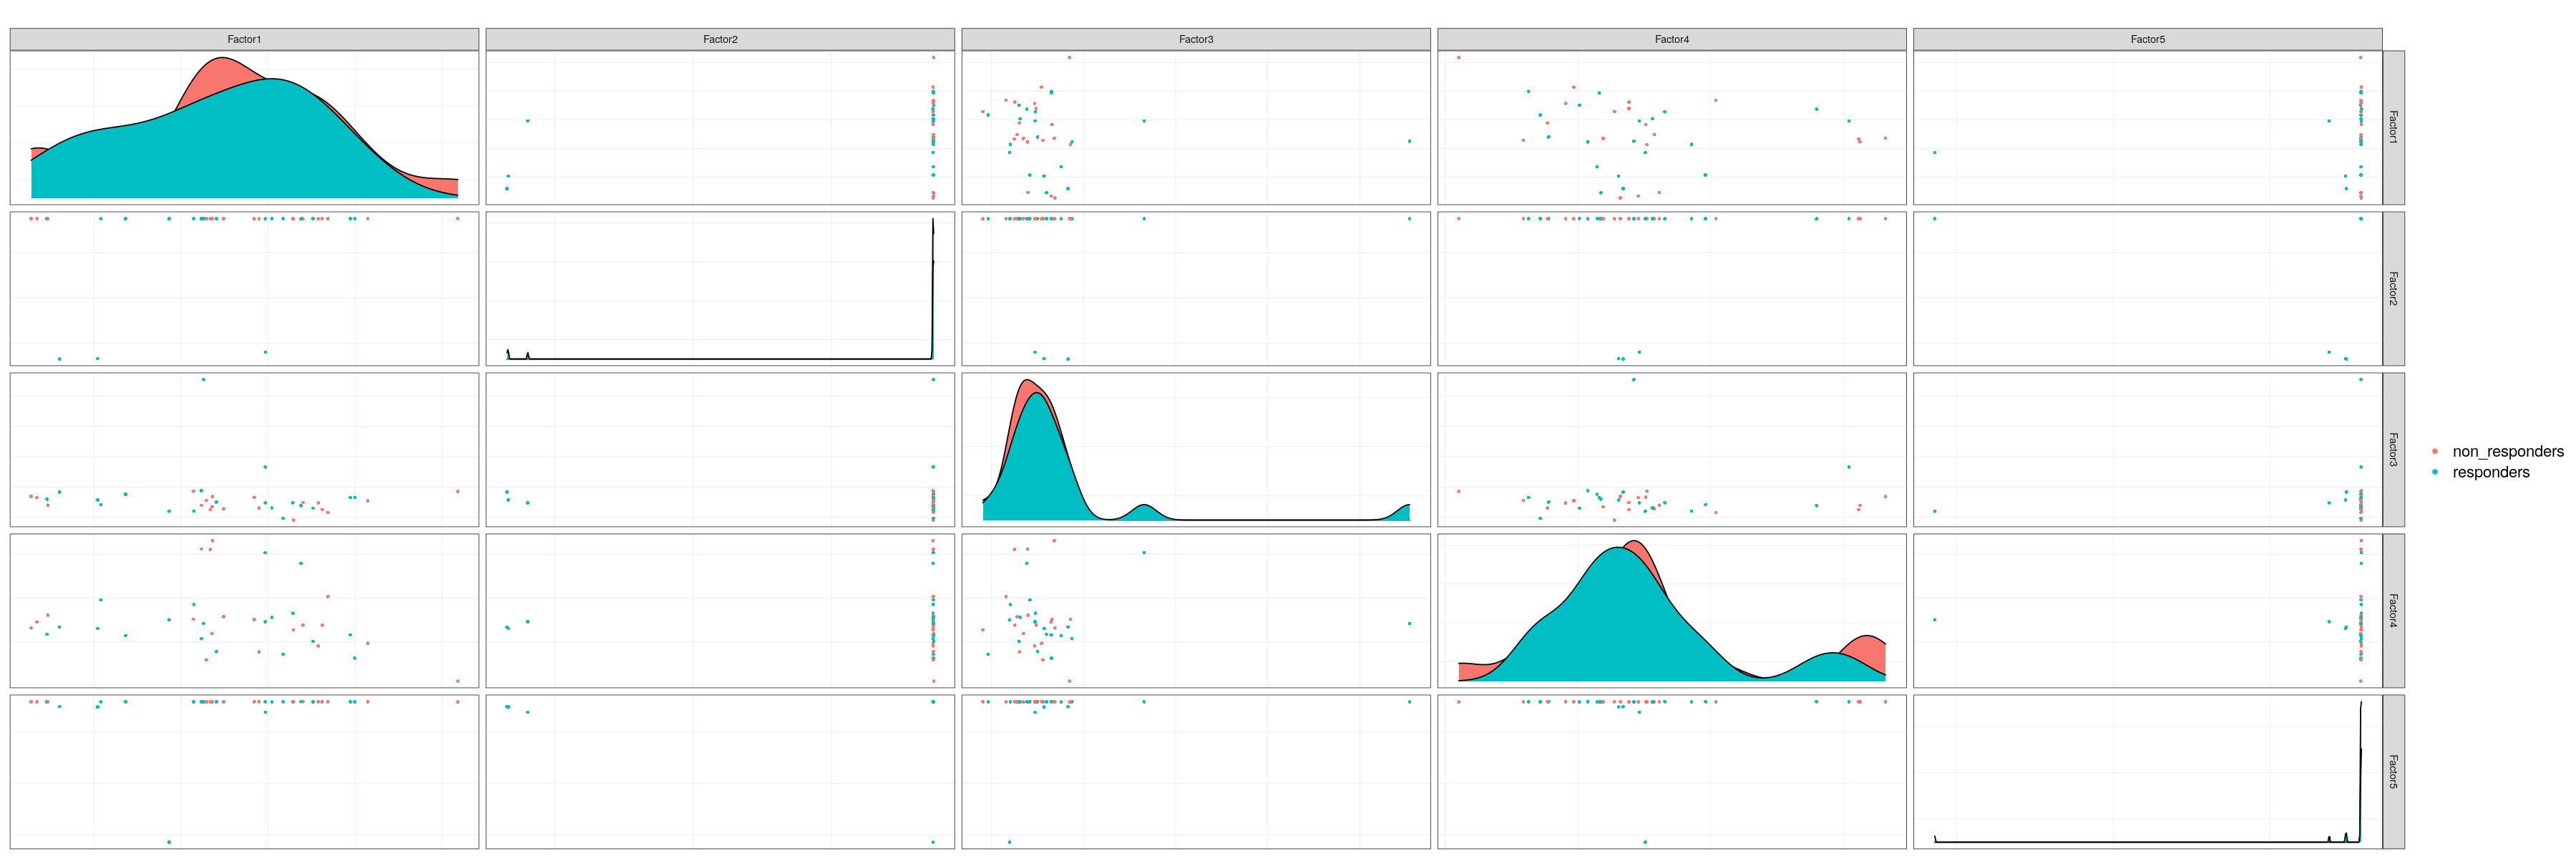

In [32]:
plot_factors(MOFAobject,
           factor = 1:5,
           color_by = 'response')

`geom_smooth()` using formula 'y ~ x'



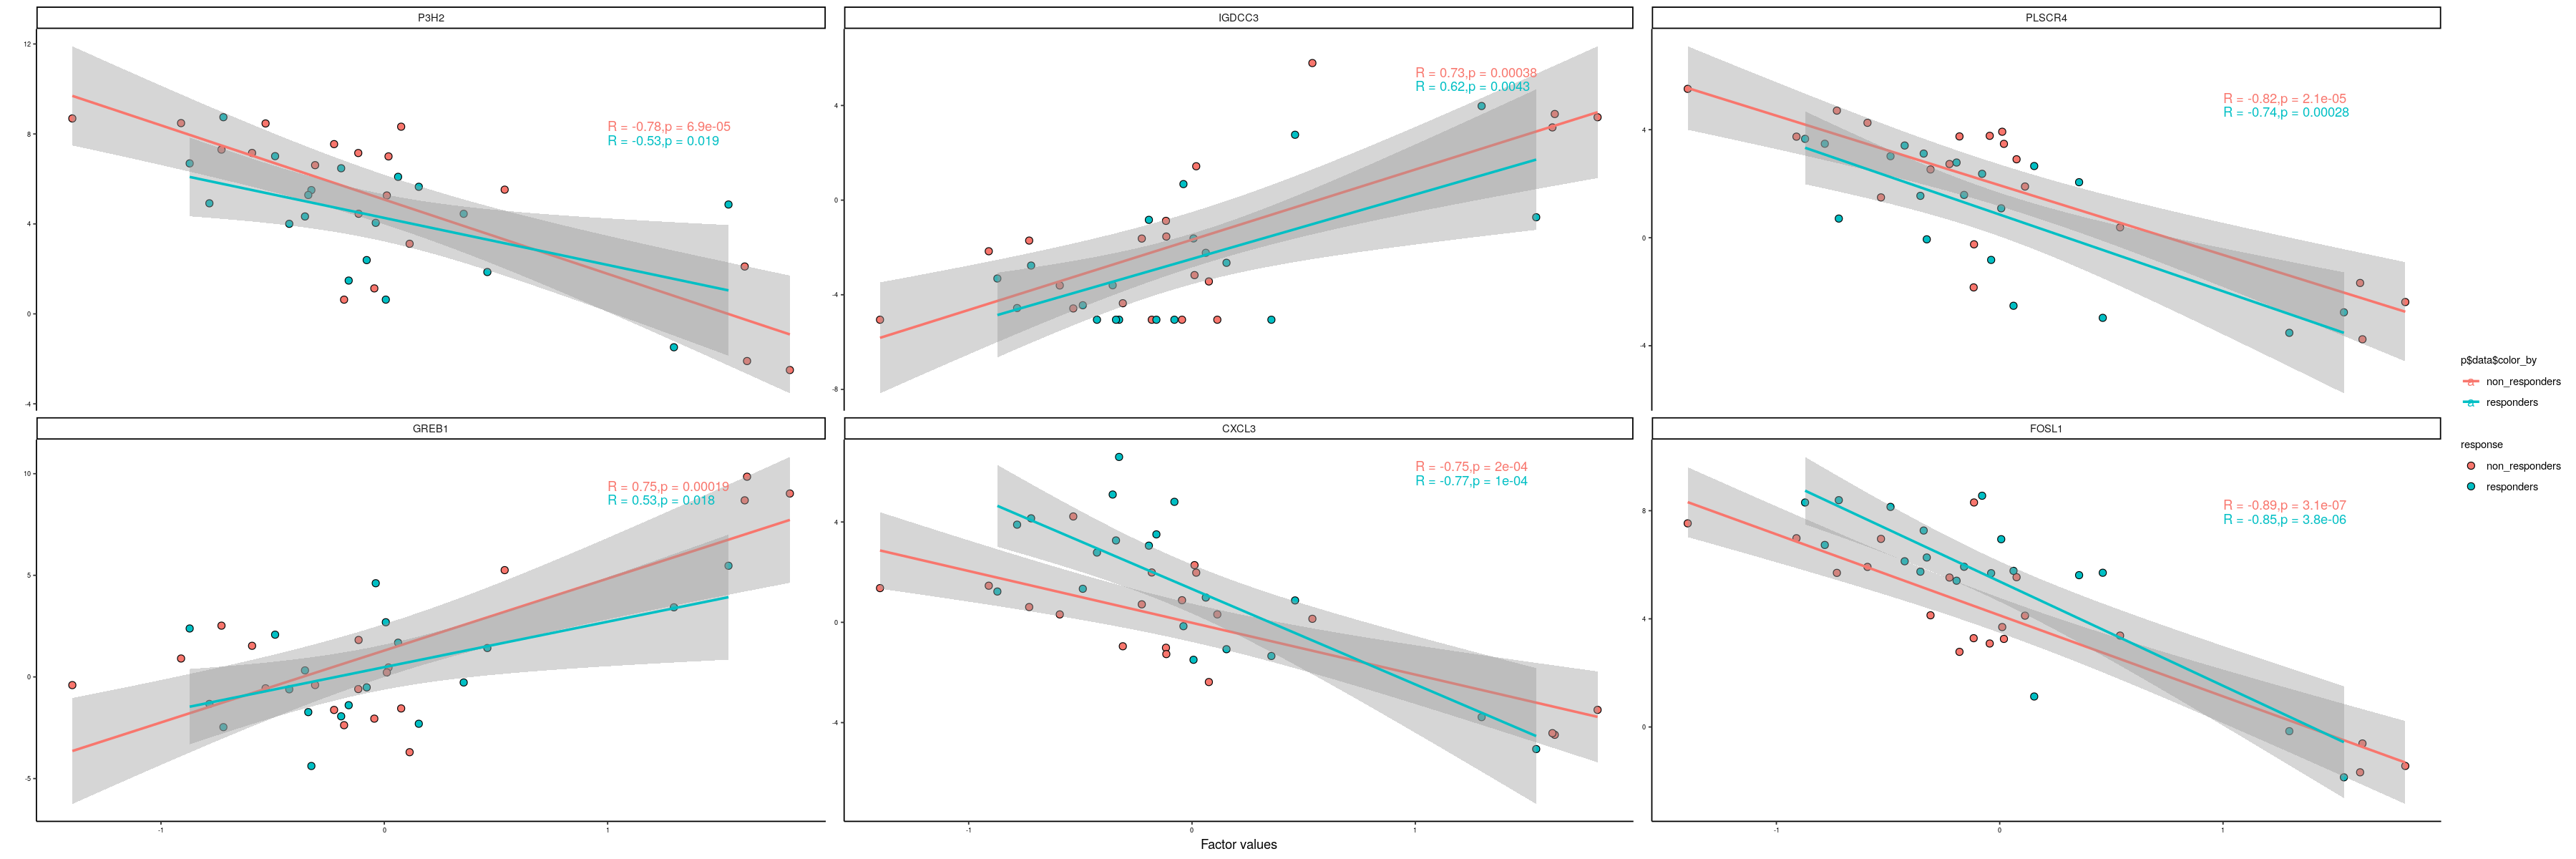

In [33]:
p = plot_data_scatter(MOFAobject,
                 view = 'mRNA',
                 factor = Act.f,
                 features = 6,
                 add_lm = FALSE,
                 color_by = 'response',
                 lm_per_group = FALSE)
p + stat_smooth(aes(color = p$data$color_by), method = 'lm', alpha = 0.4) +
    ggpubr::stat_cor(aes(color = p$data$color_by), method = "pearson", label.sep = ",",
                  output.type = "latex",  label.x = 1)

`geom_smooth()` using formula 'y ~ x'



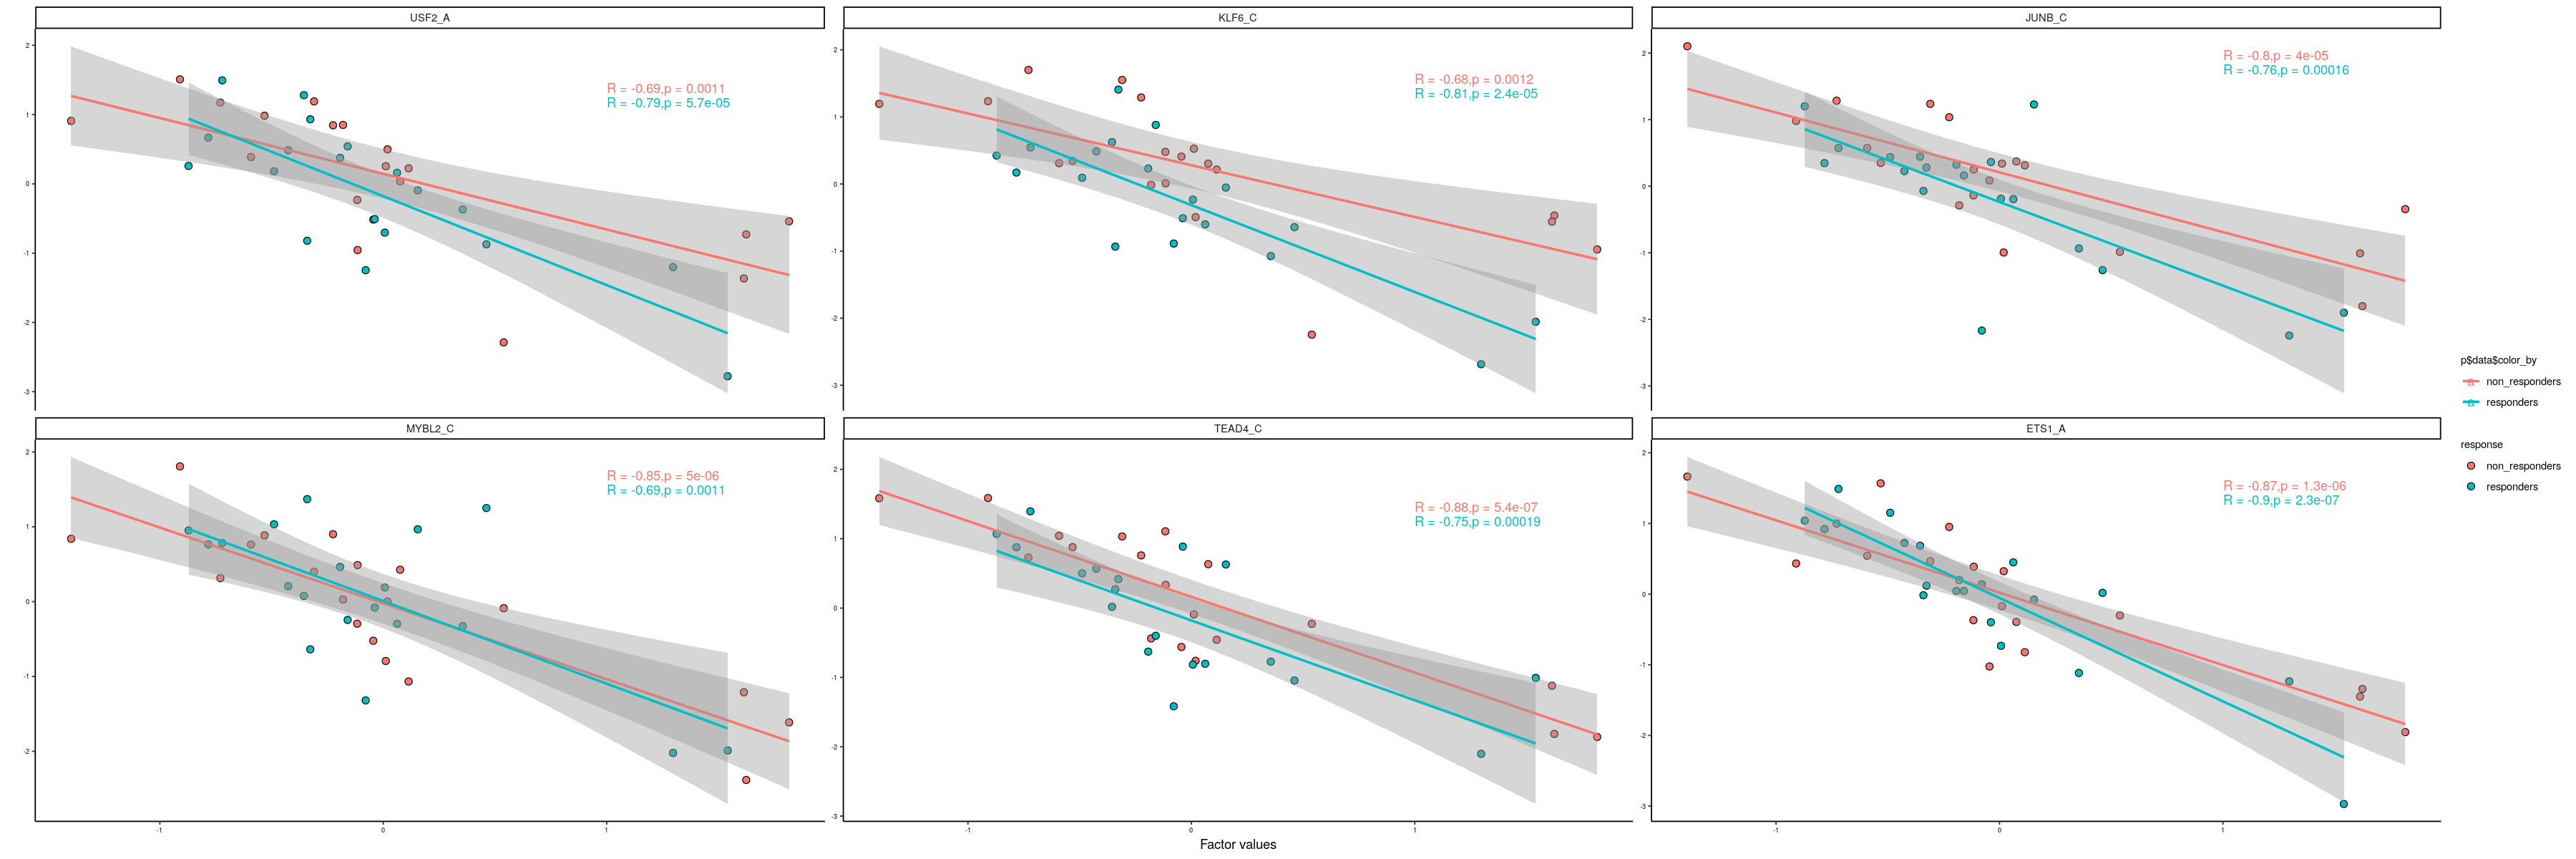

In [34]:
p = plot_data_scatter(MOFAobject,
                 view = 'Activities',
                 factor = Act.f,
                 features = 6,
                 add_lm = FALSE,
                 color_by = 'response',
                 lm_per_group = FALSE)
p + stat_smooth(aes(color = p$data$color_by), method = 'lm', alpha = 0.4) +
    ggpubr::stat_cor(aes(color = p$data$color_by), method = "pearson", label.sep = ",",
                  output.type = "latex",  label.x = 1)

`geom_smooth()` using formula 'y ~ x'



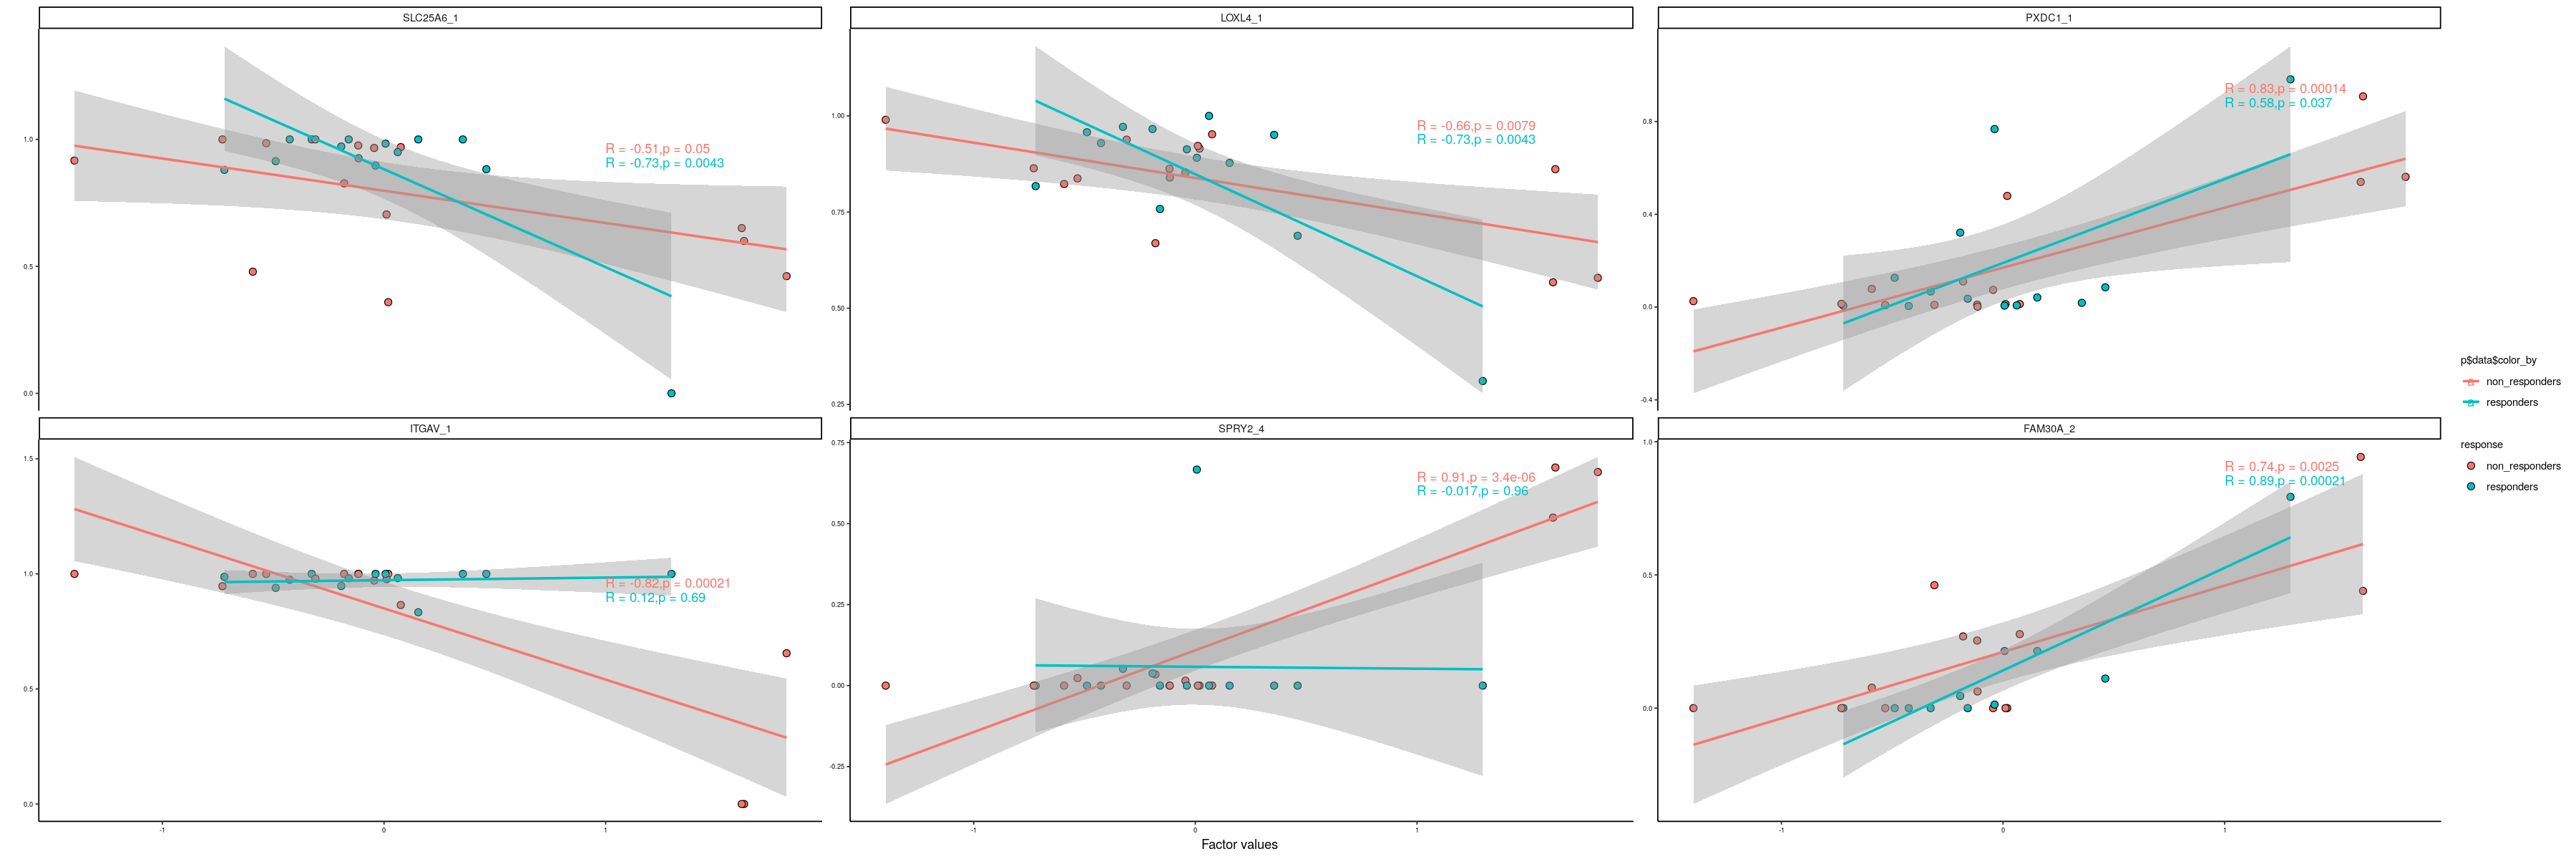

In [35]:
p = plot_data_scatter(MOFAobject,
                 view = 'Methylations',
                 factor = Act.f,
                 features = 6,
                 add_lm = FALSE,
                 color_by = 'response',
                 lm_per_group = FALSE)
p + stat_smooth(aes(color = p$data$color_by), method = 'lm', alpha = 0.4) +
    ggpubr::stat_cor(aes(color = p$data$color_by), method = "pearson", label.sep = ",",
                  output.type = "latex",  label.x = 1)

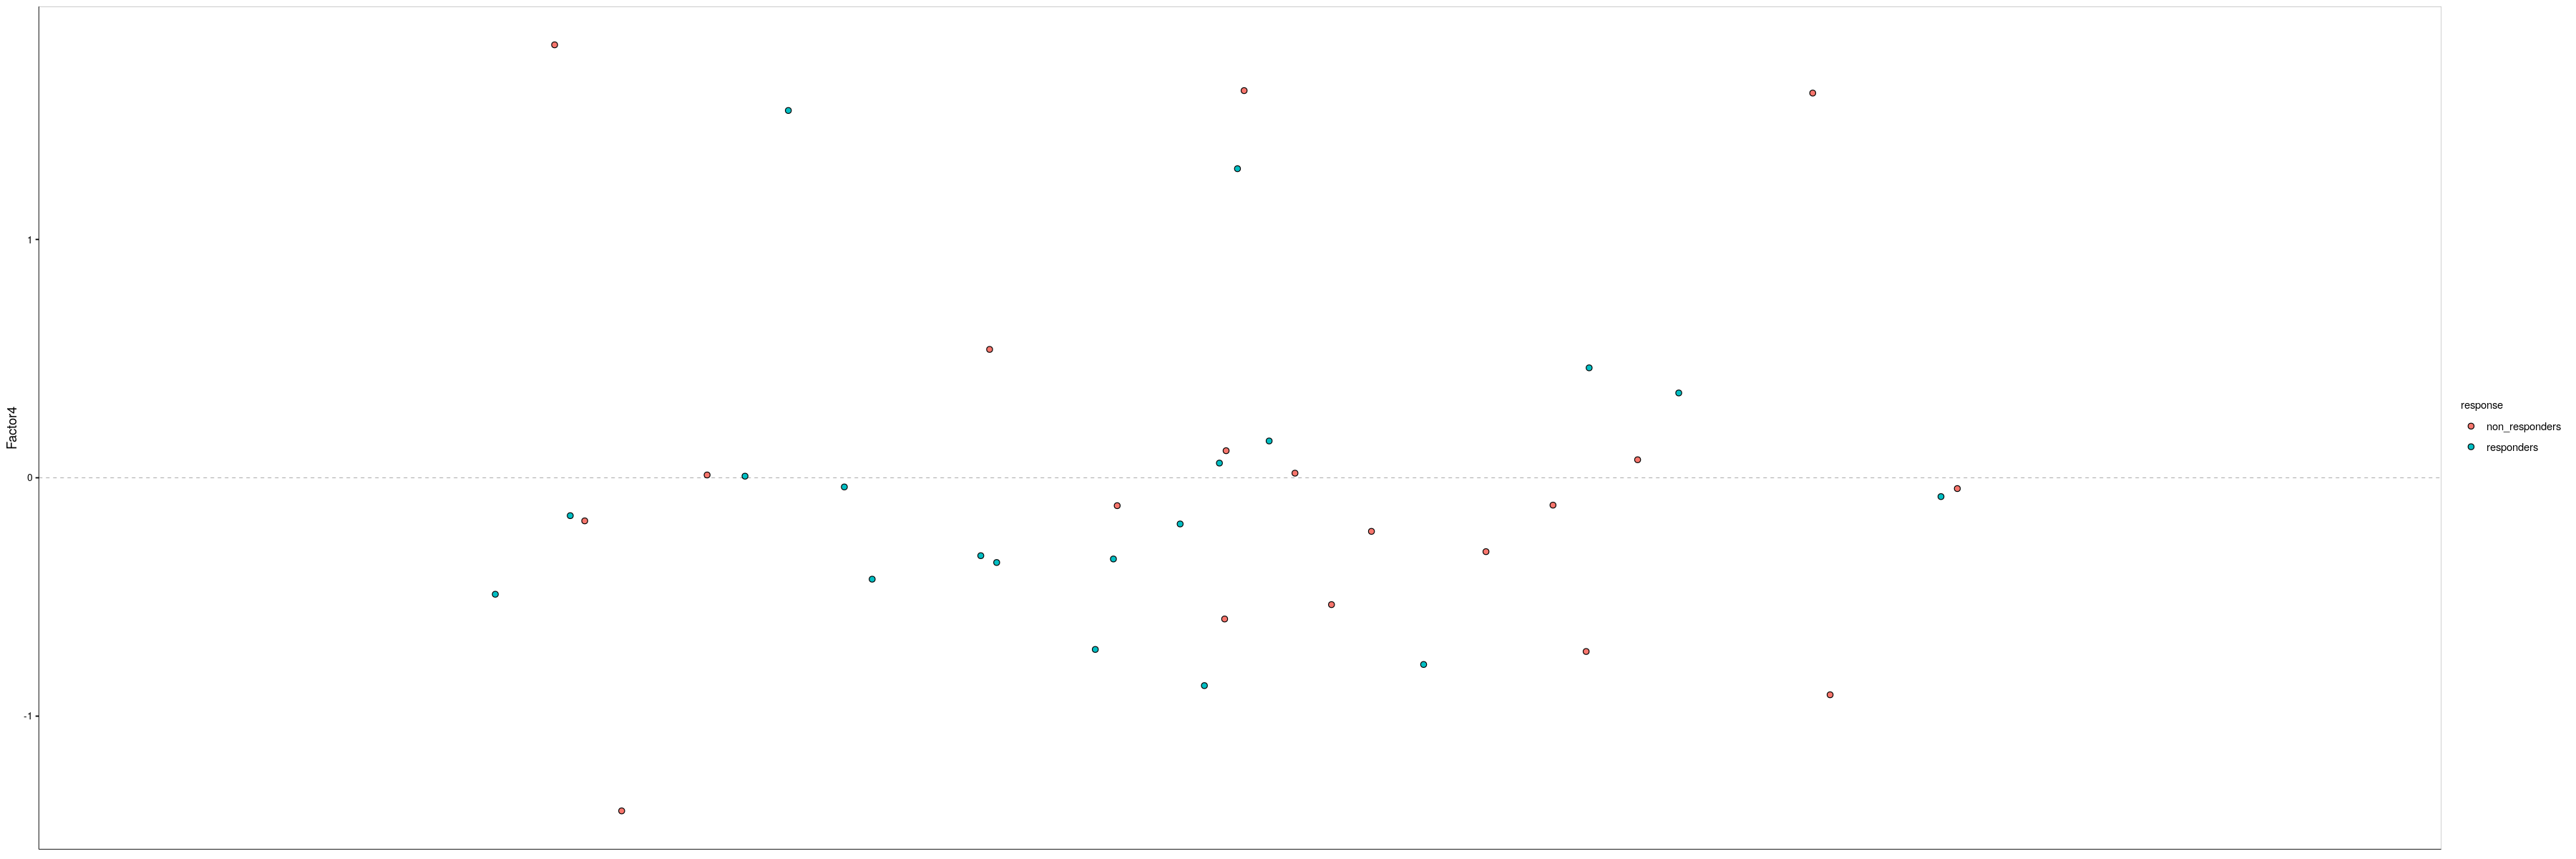

In [36]:
plot_factor(MOFAobject,
           factor = Act.f,
           color_by = 'response') #+
    #geom_mark_hull(aes(label = color_by, fill = color_by) ,concavity = 1.8)

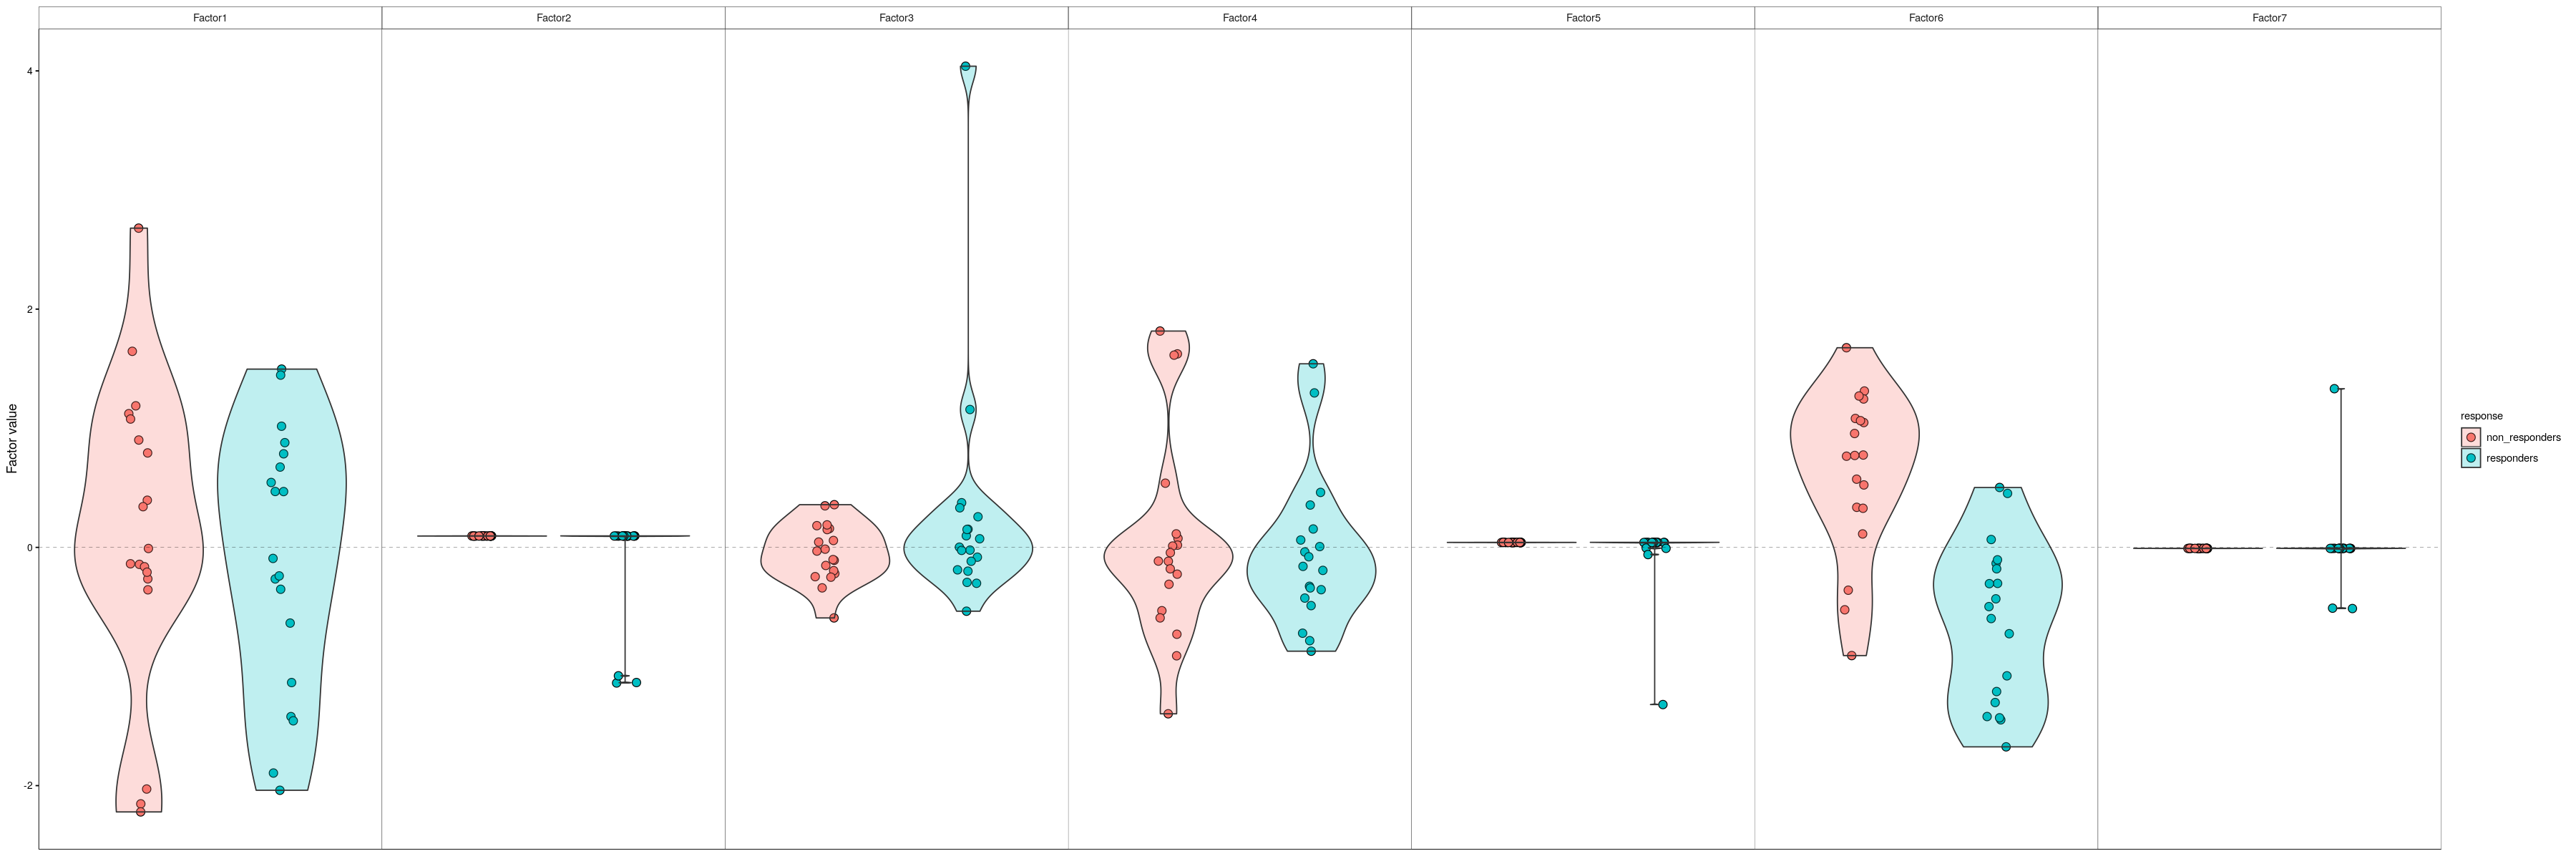

In [37]:

p <- plot_factor(MOFAobject, 
  factors = 1:7,
  color_by = "response",
  dot_size = 3,
  dodge = TRUE,
  legend = TRUE,
  add_violin = TRUE,
  violin_alpha = 0.25
)

#p + 
#  scale_color_manual(values=c("responders"="black", "non_responders"="red")) +
#  scale_fill_manual(values=c("responders"="black", "non_responders"="red")) +
#  ylim(c(-3,5)) + labs(title = '', color = 'response')
p
#print(p)

## Survival rate analysis
### TCGA data download

In [ ]:
#CancerProject = 'TCGA-OV'
#TCGAprefix = gsub('-','_', CancerProject)
#DataDirectory = paste0('/home/jupyter/db/GDC/', TCGAprefix)
#FileNameData = paste0(DataDirectory, "_","HTSeq_Counts",".rda")
#FileNameData = paste0(DataDirectory, "_","HTSeq_Counts",".rda")
#FileNameData = '/home/jupyter/projects/olaparib_resistance/TCGA_OV_START_countsds.rda'

In [ ]:
#query <- GDCquery(project = CancerProject,
#                  data.category = "Transcriptome Profiling",
#                  data.type = "Gene Expression Quantification", 
#                  workflow.type = "STAR - Counts")
#GDCdownload(query)


In [ ]:
#samplesDown <- getResults(query,cols = c("cases"))
#GDCdownload(query = query)

In [ ]:
#problems(GDCprepare(query))

In [ ]:
#dataPrep1 <- GDCprepare(query = query, 
#                        save = TRUE, 
#                        save.filename = FileNameData)

In [ ]:
#dataPrep <- TCGAanalyze_Preprocessing(object = dataPrep1, 
#                                      cor.cut = 0.6,
#                                      datatype = "STAR - Counts")
#dataNorm <- TCGAanalyze_Normalization(tabDF = dataPrep,
##                                      geneInfo = geneInfoHT,
 #                                     method = "gcContent")
#dataNorm <- TCGAanalyze_Normalization(tabDF = dataPrep,
#                                      geneInfo = geneInfoHT,
#                                      method = "geneLength")
#dataFilt <- TCGAanalyze_Filtering(tabDF = dataNorm,
#                                  method = "quantile", 
#                                  qnt.cut =  0.25)

In [ ]:
#load('/home/jupyter/projects/olaparib_resistance/TCGA_OV_STAR_countsds.rda')
#load('/home/jupyter/projects/olaparib_resistance/TCGA_BRCA_STAR_countsds.rda')
#data

In [489]:
dataClin1 = GDCquery_clinic(project = 'TCGA-OV', 'clinical')
dataClin2 = GDCquery_clinic(project = 'TCGA-BRCA', 'clinical')
#dataClin = rbind(dataClin1, dataClin2)
#dataClin

In [490]:
col_inter = colnames(dataClin1)[colnames(dataClin1) %in% colnames(dataClin2)]

In [491]:
dataClin = rbind(dataClin1[,col_inter], dataClin2[,col_inter])
head(dataClin)

submitter_id synchronous_malignancy days_to_diagnosis created_datetime
1 TCGA-23-1024 Not Reported           0                 NA              
2 TCGA-13-0911 Not Reported           0                 NA              
3 TCGA-29-2435 Not Reported           0                 NA              
4 TCGA-13-1408 Not Reported           0                 NA              
5 TCGA-13-0727 Not Reported           0                 NA              
6 TCGA-13-1505 Not Reported           0                 NA              
  last_known_disease_status tissue_or_organ_of_origin days_to_last_follow_up
1 not reported              Ovary                      468                  
2 not reported              Ovary                      843                  
3 not reported              Ovary                       34                  
4 not reported              Ovary                      180                  
5 not reported              Ovary                      462                  
6 not reported              Ovary                     1998                  
  age_at_diagnosis primary_diagnosis             
1 19052            Serous cystadenocarcinoma, NOS
2 20276            Serous cystadenocarcinoma, NOS
3 28779            Serous cystadenocarcinoma, NOS
4 21635            Serous cystadenocarcinoma, NOS
5 26185            Serous cystadenocarcinoma, NOS
6 23238            Serous cystadenocarcinoma, NOS
  updated_datetime                 ⋯ treatments_radiation_treatment_or_therapy
1 2019-08-08T17:17:05.697589-05:00 ⋯ no                                       
2 2019-08-08T17:16:28.780244-05:00 ⋯ no                                       
3 2019-08-08T17:18:29.076966-05:00 ⋯ not reported                             
4 2019-08-08T17:16:49.050624-05:00 ⋯ no                                       
5 2019-08-08T17:16:04.768020-05:00 ⋯ no                                       
6 2019-08-08T17:16:49.050624-05:00 ⋯ no                                       
  treatments_radiation_days_to_treatment_end
1 NA                                        
2 NA                                        
3 NA                                        
4 NA                                        
5 NA                                        
6 NA                                        
  treatments_radiation_days_to_treatment_start
1 NA                                          
2 NA                                          
3 NA                                          
4 NA                                          
5 NA                                          
6 NA                                          
  treatments_radiation_regimen_or_line_of_therapy
1 NA                                             
2 NA                                             
3 NA                                             
4 NA                                             
5 NA                                             
6 NA                                             
  treatments_radiation_treatment_effect
1 NA                                   
2 NA                                   
3 NA                                   
4 NA                                   
5 NA                                   
6 NA                                   
  treatments_radiation_initial_disease_status
1 NA                                         
2 NA                                         
3 NA                                         
4 NA                                         
5 NA                                         
6 NA                                         
  treatments_radiation_treatment_anatomic_site
1 NA                                          
2 NA                                          
3 NA                                          
4 NA                                          
5 NA                                          
6 NA                                          
  treatments_radiation_treatment_outcome bcr_patient_barcode disease
1 NA                                     TCGA-23-1024  

In [41]:
dataCounts = read.csv('TCGA_OV_BRCA.STAR.counts.csv', header = T, row.names = 1, check.names=FALSE)
head(dataCounts)

TCGA-13-1489-01A-01R-1565-13 TCGA-61-2101-01A-01R-1568-13
ENSG00000000003 5343                         3956                        
ENSG00000000005    1                            2                        
ENSG00000000419 4508                         4393                        
ENSG00000000457  716                         1086                        
ENSG00000000460  525                          817                        
ENSG00000000938   69                          184                        
                TCGA-61-1900-01A-01R-1567-13 TCGA-29-1784-01A-02R-1567-13
ENSG00000000003 8278                         5936                        
ENSG00000000005   17                            1                        
ENSG00000000419 4019                         4701                        
ENSG00000000457 1096                          842                        
ENSG00000000460 1104                          563                        
ENSG00000000938  166                          685                        
                TCGA-61-1725-01A-01R-1567-13 TCGA-24-1470-01A-01R-1566-13
ENSG00000000003 6360                         5088                        
ENSG00000000005   30                            8                        
ENSG00000000419 3405                         1552                        
ENSG00000000457  544                          992                        
ENSG00000000460  289                          786                        
ENSG00000000938  176                          747                        
                TCGA-24-1546-01A-01R-1566-13 TCGA-31-1956-01A-01R-1568-13
ENSG00000000003 2350                         1788                        
ENSG00000000005   24                            5                        
ENSG00000000419 3163                         1848                        
ENSG00000000457  547                          719                        
ENSG00000000460  204                          402                        
ENSG00000000938  857                         1376                        
                TCGA-13-0913-02A-01R-1564-13 TCGA-13-1477-01A-01R-1565-13 ⋯
ENSG00000000003 2305                         3537                         ⋯
ENSG00000000005    0                            0                         ⋯
ENSG00000000419 2197                         1666                         ⋯
ENSG00000000457  108                          588                         ⋯
ENSG00000000460   85                          148                         ⋯
ENSG00000000938   69                           68                         ⋯
                TCGA-A2-A0SU-01A-11R-A084-07 TCGA-E9-A1NI-01A-11R-A14D-07
ENSG00000000003 8928                          441                        
ENSG00000000005    7                            0                        
ENSG00000000419 1273                         2125                        
ENSG00000000457 1356                         1002                        
ENSG00000000460  289                          430                        
ENSG00000000938  308                          204                        
                TCGA-B6-A0RQ-01A-11R-A115-07 TCGA-E9-A1RF-01A-11R-A157-07
ENSG00000000003 6821                          674                        
ENSG00000000005   63                           41                        
ENSG00000000419 2106                         3721                        
ENSG00000000457 1419                         2539                        
ENSG00000000460  398                          866                        
ENSG00000000938  463                          904                        
                TCGA-A2-A0CX-01A-21R-A00Z-07 TCGA-E2-A158-11A-22R-A12D-07
ENSG00000000003 3226                         1816                        
ENSG00000000005    1                          682                        
ENSG00000000419 1901                          875                        
ENSG00000000457 1445                          489                        
ENSG00

In [ ]:
en_gs = rownames(dataCounts)
ensembl = useEnsembl(biomart = 'ensembl', dataset = 'hsapiens_gene_ensembl')
dataGS = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
     filters = 'ensembl_gene_id',
      values = en_gs,
      mart = ensembl,
      uniqueRows = TRUE
     )
inter_gs = rownames(dataCounts[rownames(dataCounts) %in% dataGS[,1], ])
head(inter_gs)

In [42]:
inter_gs = inter_gs[!inter_gs %in% c('ENSG00000230417', 'ENSG00000276085')]


In [43]:
dataCounts = dataCounts[inter_gs,]
dataGS = dataGS[dataGS[,1] %in% inter_gs,]
rownames(dataGS) = dataGS[,1]

In [44]:
TCGA_counts = cbind(dataCounts, dataGS['hgnc_symbol'])
TCGA_counts = TCGA_counts[nchar(TCGA_counts[['hgnc_symbol']]) > 0, ]
TCGA_counts = TCGA_counts[!duplicated(TCGA_counts['hgnc_symbol']),]
rownames(TCGA_counts) = TCGA_counts[['hgnc_symbol']]
TCGA_counts = TCGA_counts[,-dim(TCGA_counts)[2]]
#TCGA_counts

In [ ]:
#write.csv(TCGA_counts, 'TCGA_OV_BRCA.STAR_counts.GS.csv', quote = FALSE)

In [12]:
#dataFilt = read.csv(paste0(TCGAprefix,'.GS.exp.csv'), header = T, row.names = 1)
dataFilt = read.csv('TCGA_OV_BRCA.STAR_counts.GS.csv', header = T, row.names = 1, check.names=FALSE)
#dataFilt = t(dataFilt)
dim(dataFilt)

[1] 39729  1607

In [ ]:
head(dataFilt)

In [ ]:
load('/home/jupyter/Cell-death-signatures/data/Functional/DoRothEA.rdata')
regulon=viper_regulon
activity = viper(eset = dataFilt, regulon = regulon, nes = T, 
                   method = 'none' ,minsize = 4, eset.filter = F,cores = 4)
rownames(activity) = sapply(strsplit(rownames(activity)," -"), `[`, 1)

In [ ]:
activity.zscore = (activity - rowMeans(activity))/(rowSds(as.matrix(activity)))[row(activity)]
activity.zscore = activity.zscore[grepl('_A|_B|_C', rownames(activity.zscore)),]
#activity.zscore

In [ ]:
PathwayActivity = progeny(as.matrix(dataFilt), scale = TRUE, organism = 'Human')

In [259]:
head(weights.exp.dt)

feature factor  value     view
372  LYZ     Factor1 1.0000000 mRNA
1235 LOXL2   Factor1 0.8842249 mRNA
2100 SDC2    Factor1 0.8762414 mRNA
1702 ADAMTS1 Factor1 0.8674495 mRNA
1443 COL6A2  Factor1 0.8187263 mRNA
786  GNB4    Factor1 0.8140694 mRNA

In [13]:
nres_combn = crossing(non_responders = nres_id, TCGA_pid = colnames(dataFilt))
res_combn = crossing(responders = res_id, TCGA_pid = colnames(dataFilt))
exp.features.inter = rownames(dataFilt[rownames(dataFilt) %in% exp.features,])
exp.features.inter
TCGA_exp = t(dataFilt[exp.features.inter,])

[1] "LYZ"     "GNB4"    "LOXL2"   "COL6A2"  "ADAMTS1" "SDC2"

In [271]:
# my_filt = 0.8
# exp.features = weights.exp.dt[weights.exp.dt['value']> my_filt, 'feature']
# exp.features.inter = rownames(dataFilt[rownames(dataFilt) %in% exp.features,])
# TCGA_exp = t(dataFilt[exp.features.inter,])
# name_str_df = as.data.frame(t(sapply(strsplit(rownames(TCGA_exp), "-"), `[`, 1:3)))
# rownames(TCGA_exp) = str_c(name_str_df$V1,"-",name_str_df$V2,'-',name_str_df$V3)
# res_exp.inter['response'] = 1
# nres_exp.inter['response'] = 0
# marker_exp = rbind(res_exp.inter, nres_exp.inter)
# marker_exp$response= factor(marker_exp$response)
# model_scaler = preProcess(x = marker_exp[,1:6], method = c('center','scale'))
# marker_exp_scaled = predict(model_scaler, marker_exp[,1:6])
# marker_exp_scaled['response'] = marker_exp$response

In [399]:
mRNA.count = read.table('/home/jupyter/projects/olaparib_resistance/Olaparib.response.exp.csv', header = TRUE, row.names = 1, sep = ',')

# my_df

1 
2 
3 
4 
5 
6 
7 
8 
9 
10
11

In [423]:
set.seed(0)

## classification models

classification methods|name
----------------------|-----
1                     |Random Forest
2                     |Support Vector Machine
3                     |Siamese Neural Network

### 1. Random Forest

In [424]:
my_df = data.frame(matrix(nrow = 11, ncol = 0))
marker_count = c()

for(i in 1:8){
    my_filt = 0.1*i
    exp.features = weights.exp.dt[weights.exp.dt['value']> my_filt, 'feature']
    exp.features.inter = rownames(dataFilt[rownames(dataFilt) %in% exp.features,])
    TCGA_exp = t(dataFilt[exp.features.inter,])
    name_str_df = as.data.frame(t(sapply(strsplit(rownames(TCGA_exp), "-"), `[`, 1:3)))
    rownames(TCGA_exp) = str_c(name_str_df$V1,"-",name_str_df$V2,'-',name_str_df$V3)
    res_exp.inter = mRNA.count[rownames(mRNA.count) %in% res_id, colnames(mRNA.count) %in% exp.features.inter]
    res_exp.inter = res_exp.inter[,colnames(res_exp.inter) %in% colnames(TCGA_exp)]
    nres_exp.inter = mRNA.count[rownames(mRNA.count) %in% nres_id, colnames(mRNA.count) %in% exp.features.inter]
    nres_exp.inter = nres_exp.inter[,colnames(nres_exp.inter) %in% colnames(TCGA_exp)]
    res_exp.inter['response'] = 1
    nres_exp.inter['response'] = 0
    marker_count = c(marker_count, length(exp.features.inter))
    marker_exp = rbind(res_exp.inter, nres_exp.inter)
    marker_exp$response= factor(marker_exp$response)
    model_scaler = preProcess(x = marker_exp[,-(dim(marker_exp)[2])], method = c('center','scale'))
    marker_exp_scaled = predict(model_scaler, marker_exp[,-(dim(marker_exp)[2])])
    marker_exp_scaled['response'] = marker_exp$response
    df_train = sample_frac(marker_exp_scaled, size = 0.6)
    df_test = marker_exp_scaled[!rownames(marker_exp_scaled) %in% rownames(df_train),]
    set.seed(1)
    refractory_rf = randomForest(data = df_train,
                                 response ~ .,
                                 importance = TRUE
                                )
    actual = factor(df_test$response)
    predict = factor(predict(refractory_rf, df_test))
    acc = confusionMatrix(predict, actual, mode = 'everything', positive = '1')
    my_df = cbind(my_df,data.frame(acc$byClass))
}
my_df_colnames = c()
for(i in 1:8){
    my_df_colnames = c(my_df_colnames, sprintf('weights_%.2f', 0.1*i))
}
colnames(my_df) = my_df_colnames
acc_df = rbind(my_df,marker_count)
row.names(acc_df)[12] = 'counts'
# acc_df
# write.csv(acc_df, 'RF.acc.csv', quote =FALSE)

In [34]:
write.csv(marker_exp_scaled, 'MOFA.markers.exp.scaled.csv', quote = FALSE)

In [27]:
set.seed(1)
refractory_rf = randomForest(data = marker_exp_scaled,
                             response ~ .,
                             importance = TRUE
                            )

In [28]:
print(refractory_rf)


Call:
 randomForest(formula = response ~ ., data = marker_exp_scaled,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 34.21%
Confusion matrix:
   0  1 class.error
0 12  7   0.3684211
1  6 13   0.3157895


In [20]:
importance(refractory_rf)

0         1          MeanDecreaseAccuracy MeanDecreaseGini
ADAMTS1  2.788754 -1.0942548  0.8384363           1.259677        
COL6A2   3.000701  4.3462407  4.6634397           2.302680        
GNB4     7.642360  7.6888424 10.2139626           2.514875        
LOXL2   -0.467984 -1.9254253 -1.8849748           1.419650        
LYZ      2.040300  1.0051581  2.0435725           1.793099        
SDC2     5.063245  0.5188872  3.6323626           1.651234

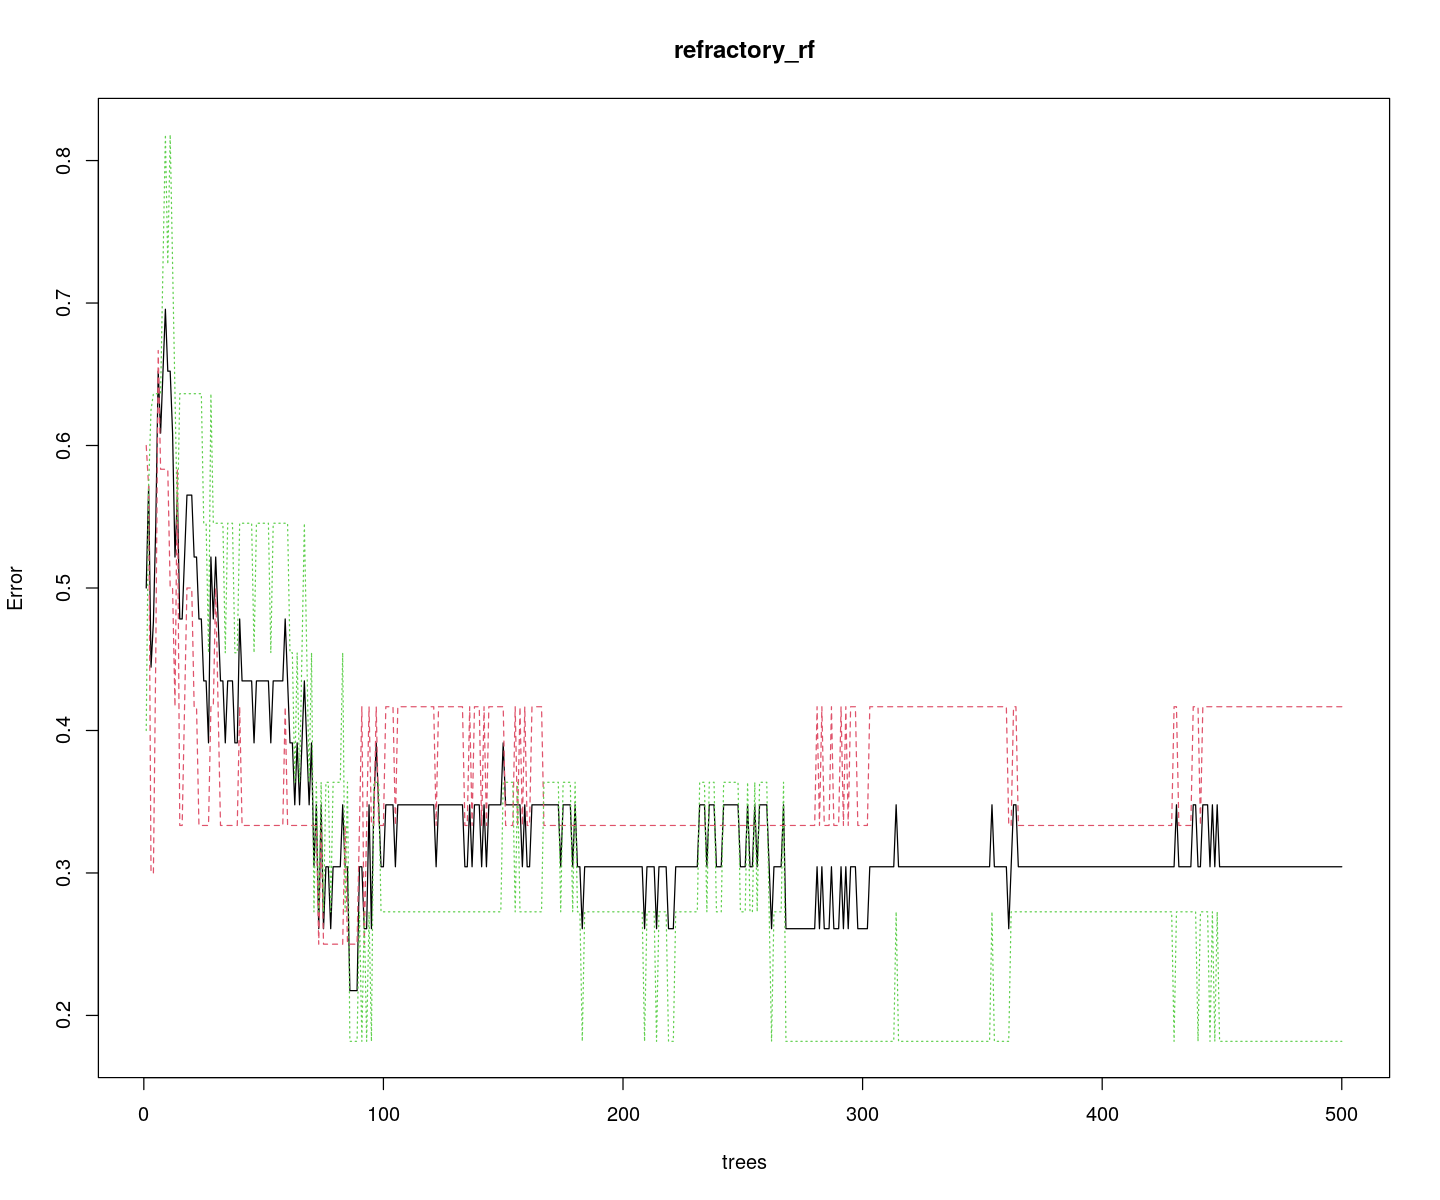

In [444]:
plot(refractory_rf)

### 2. Support Vector Machine

In [18]:
my_df = data.frame(matrix(nrow = 11, ncol = 0))
marker_count = c()

for(i in 1:8){
    my_filt = 0.1*i
    exp.features = weights.exp.dt[weights.exp.dt['value']> my_filt, 'feature']
    exp.features.inter = rownames(dataFilt[rownames(dataFilt) %in% exp.features,])
    TCGA_exp = t(dataFilt[exp.features.inter,])
    name_str_df = as.data.frame(t(sapply(strsplit(rownames(TCGA_exp), "-"), `[`, 1:3)))
    rownames(TCGA_exp) = str_c(name_str_df$V1,"-",name_str_df$V2,'-',name_str_df$V3)
    res_exp.inter = mRNA.count[rownames(mRNA.count) %in% res_id, colnames(mRNA.count) %in% exp.features.inter]
    res_exp.inter = res_exp.inter[,colnames(res_exp.inter) %in% colnames(TCGA_exp)]
    nres_exp.inter = mRNA.count[rownames(mRNA.count) %in% nres_id, colnames(mRNA.count) %in% exp.features.inter]
    nres_exp.inter = nres_exp.inter[,colnames(nres_exp.inter) %in% colnames(TCGA_exp)]
    res_exp.inter['response'] = 1
    nres_exp.inter['response'] = 0
    marker_count = c(marker_count, length(exp.features.inter))
    marker_exp = rbind(res_exp.inter, nres_exp.inter)
    marker_exp$response= factor(marker_exp$response)
    model_scaler = preProcess(x = marker_exp[,-(dim(marker_exp)[2])], method = c('center','scale'))
    marker_exp_scaled = predict(model_scaler, marker_exp[,-(dim(marker_exp)[2])])
    marker_exp_scaled['response'] = marker_exp$response
    marker_exp_scaled$response = as.numeric(as.character(marker_exp_scaled$response))
    df_train = sample_frac(marker_exp_scaled, size = 0.6)
    df_test = marker_exp_scaled[!rownames(marker_exp_scaled) %in% rownames(df_train),]
    
    my_tune_svm = tune.svm(data = marker_exp_scaled, response ~ .,
        gamma = 10^(-1:-5), cost = 10^(1:5))
    
    m <- svm(data = marker_exp_scaled, response ~ .,
             gamma = my_tune_svm$best.parameters$gamma, 
             cost = my_tune_svm$best.parameters$cost,
             type = 'C-classification',
             kernel = 'sigmoid',
             probability = TRUE)
    
    actual = factor(df_test$response)
    predict = factor(predict(m, df_test))
    #predict = factor(predict(refractory_rf, df_test))
    acc = confusionMatrix(predict, actual, mode = 'everything')
    my_df = cbind(my_df,data.frame(acc$byClass))
}
my_df_colnames = c()
for(i in 1:8){
    my_df_colnames = c(my_df_colnames, sprintf('weights_%.2f', 0.1*i))
}
colnames(my_df) = my_df_colnames
acc_df = rbind(my_df,marker_count)
row.names(acc_df)[12] = 'counts'
acc_df
# write.csv(acc_df, 'SVM.acc.csv', quote =FALSE)

weights_0.10 weights_0.20 weights_0.30 weights_0.40
Sensitivity            1.0000000    1.0000000    0.8333333    0.8333333 
Specificity            1.0000000    1.0000000    1.0000000    1.0000000 
Pos Pred Value         1.0000000    1.0000000    1.0000000    1.0000000 
Neg Pred Value         1.0000000    1.0000000    0.9000000    0.9000000 
Precision              1.0000000    1.0000000    1.0000000    1.0000000 
Recall                 1.0000000    1.0000000    0.8333333    0.8333333 
F1                     1.0000000    1.0000000    0.9090909    0.9090909 
Prevalence             0.5333333    0.4666667    0.4000000    0.4000000 
Detection Rate         0.5333333    0.4666667    0.3333333    0.3333333 
Detection Prevalence   0.5333333    0.4666667    0.3333333    0.3333333 
Balanced Accuracy      1.0000000    1.0000000    0.9166667    0.9166667 
counts               878.0000000  523.0000000  349.0000000  198.0000000 
                     weights_0.50 weights_0.60 weights_0.70 weights_0.80
Sensitivity           0.8333333    0.8750000    0.5714286   0.7500000   
Specificity           1.0000000    1.0000000    1.0000000   0.8571429   
Pos Pred Value        1.0000000    1.0000000    1.0000000   0.8571429   
Neg Pred Value        0.9000000    0.8750000    0.7272727   0.7500000   
Precision             1.0000000    1.0000000    1.0000000   0.8571429   
Recall                0.8333333    0.8750000    0.5714286   0.7500000   
F1                    0.9090909    0.9333333    0.7272727   0.8000000   
Prevalence            0.4000000    0.5333333    0.4666667   0.5333333   
Detection Rate        0.3333333    0.4666667    0.2666667   0.4000000   
Detection Prevalence  0.3333333    0.4666667    0.2666667   0.4666667   
Balanced Accuracy     0.9166667    0.9375000    0.7857143   0.8035714   
counts               96.0000000   40.0000000   21.0000000   6.0000000

In [19]:
summary(m)


Call:
svm(formula = response ~ ., data = marker_exp_scaled, gamma = my_tune_svm$best.parameters$gamma, 
    cost = my_tune_svm$best.parameters$cost, type = "C-classification", 
    kernel = "sigmoid", probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  sigmoid 
       cost:  10000 
     coef.0:  0 

Number of Support Vectors:  32

 ( 16 16 )


Number of Classes:  2 

Levels: 
 0 1




In [417]:
# marker_exp_scaled$response = as.numeric(as.character(marker_exp_scaled$response))
# my_tune_svm = tune.svm(data = marker_exp_scaled, response ~ .,
#         gamma = 10^(-1:-6), cost = 10^(1:6))

In [421]:
# my_tune_svm$best.parameters

gamma cost 
30 1e-06 1e+05

# GDSC evaluation

In [11]:
gdsc_df = read.csv('GDSC/GDSC.olaparib.testset.csv')
gdsc_df = gdsc_df[,2:8]
#gdsc_df

### SVM

In [16]:
actual = factor(gdsc_df$response)
predict = factor(predict(m, gdsc_df))
#predict = factor(predict(refractory_rf, df_test))
svm_acc = confusionMatrix(predict, actual, mode = 'everything')
# svm_acc = cbind(my_df,data.frame(acc$byClass))
svm_acc$byClass

Sensitivity          Specificity       Pos Pred Value 
          0.83544304           0.08860759           0.47826087 
      Neg Pred Value            Precision               Recall 
          0.35000000           0.47826087           0.83544304 
                  F1           Prevalence       Detection Rate 
          0.60829493           0.50000000           0.41772152 
Detection Prevalence    Balanced Accuracy 
          0.87341772           0.46202532

### RF

In [17]:
actual = factor(gdsc_df$response)
predict = factor(predict(refractory_rf, gdsc_df))
#predict = factor(predict(refractory_rf, df_test))
randomforest_acc = confusionMatrix(predict, actual, mode = 'everything')
# svm_acc = cbind(my_df,data.frame(acc$byClass))
randomforest_acc$byClass

Sensitivity          Specificity       Pos Pred Value 
          0.05063291           0.97468354           0.66666667 
      Neg Pred Value            Precision               Recall 
          0.50657895           0.66666667           0.05063291 
                  F1           Prevalence       Detection Rate 
          0.09411765           0.50000000           0.02531646 
Detection Prevalence    Balanced Accuracy 
          0.03797468           0.51265823

In [ ]:
TCGA_exp_scaled = predict(model_scaler, TCGA_exp)
#TCGA_exp_scaled

In [35]:
write.csv(TCGA_exp_scaled, 'TCGA_exp.MOFA.markers.scaled.csv', quote = FALSE)

In [451]:
rf_out = as.data.frame(predict(refractory_rf, TCGA_exp_scaled, 'prob'))
svm_out = predict(m, TCGA_exp_scaled, probability = TRUE)
svm_out_prob = as.data.frame(attr(svm_out, 'probabilities'), check.names = FALSE)

In [454]:
rownames(rf_out) = gsub('\\.','-',rownames(rf_out))
rownames(svm_out_prob) = gsub('\\.','-',rownames(svm_out_prob))
#rf_out

In [455]:
rf_res = rownames(rf_out[rf_out[,1]>0.7,])
rf_nres = rownames(rf_out[rf_out[,2]>0.7,])
svm_res = rownames(svm_out_prob[svm_out_prob[,1]>0.7,])
svm_nres = rownames(svm_out_prob[svm_out_prob[,2]>0.7,])

In [235]:
dataClin['siamese'] = 'others'
dataClin[dataClin[['submitter_id']] %in% siamese_res_id,]['siamese'] = 'responders.EXP'
dataClin[dataClin[['submitter_id']] %in% siamese_nres_id,]['siamese'] = 'non_responders.EXP'
#dataClin['siamese_predict'] = siamese_out['predict']

In [ ]:
for(i in 1:20){
    siamese_out = read.csv('siamese_out/Olaparib.MOFA.exp_markers.siamese.res.predict.csv', header = TRUE)
    model_class_score = 0.5 + 0.01* i
    siamese_out[siamese_out['predict'] < model_class_score,]['response'] = 'others'
    siamese_res_id = siamese_out[siamese_out['response'] == 'responders','X']
    siamese_nres_id = siamese_out[siamese_out['response'] == 'non_responders','X']
    dataClin['siamese'] = 'others'
    dataClin[dataClin[['submitter_id']] %in% siamese_res_id,]['siamese'] = 'responders.EXP'
    dataClin[dataClin[['submitter_id']] %in% siamese_nres_id,]['siamese'] = 'non_responders.EXP'
    print(length(siamese_res_id))
    print(length(siamese_nres_id))
    TCGAanalyze_survival(dataClin, 
                         'siamese',
                        filename = sprintf('./siamese_out/Olaparib.fig.TCGA.siamese.EXP_marker.survival.filter.%.2f.pdf', model_class_score))
    TCGAanalyze_survival(dataClin[dataClin['tissue_or_organ_of_origin'] != 'Ovary',], 
                         'siamese',
                        filename = sprintf('./siamese_out/Olaparib.fig.TCGA.siamese.EXP_marker.survival.filter.BRCA.%.2f.pdf', model_class_score))
    TCGAanalyze_survival(dataClin[dataClin['tissue_or_organ_of_origin'] == 'Ovary',], 
                         'siamese',
                        filename = sprintf('./siamese_out/Olaparib.fig.TCGA.siamese.EXP_marker.survival.filter.OV.%.2f.pdf', model_class_score))
    }

In [ ]:
library(RColorBrewer)
TCGAanalyze_survival(dataClin[dataClin['tissue_or_organ_of_origin'] != 'Ovary',], 
                     'siamese',
                     tables.theme = theme_cleantable(),
                     filename = sprintf('./siamese_out/Olaparib.fig.TCGA.siamese.EXP_marker.survival.filter.BRCA.%.2f.pdf', 
                                        model_class_score))

In [461]:
dataClin['random_forest.EXP'] = 'others'
dataClin['SVM.EXP'] = 'others'
dataClin[dataClin[['submitter_id']] %in% rf_res,]['random_forest.EXP'] = 'responders.EXP'
dataClin[dataClin[['submitter_id']] %in% rf_nres,]['random_forest.EXP'] = 'non_responders.EXP'
dataClin[dataClin[['submitter_id']] %in% svm_res,]['SVM.EXP'] = 'responders.EXP'
dataClin[dataClin[['submitter_id']] %in% svm_nres,]['SVM.EXP'] = 'non_responders.EXP'
#dataClin[dataClin[['SVM.EXP']] == 'responders.EXP',]


In [ ]:
mRNA.count = read.table('/home/jupyter/projects/olaparib_resistance/Olaparib.response.exp.csv', header = TRUE, row.names = 1, sep = ',')
res_exp.inter = mRNA.count[rownames(mRNA.count) %in% res_id, colnames(mRNA.count) %in% exp.features.inter]
res_exp.inter = res_exp.inter[,colnames(TCGA_exp)]
#head(res_exp.inter)

In [ ]:
nres_exp.inter = mRNA.count[rownames(mRNA.count) %in% nres_id, colnames(mRNA.count) %in% exp.features.inter]
nres_exp.inter = nres_exp.inter[,colnames(TCGA_exp)]
#nres_exp.inter

In [ ]:
length(act.features)
length(exp.features.inter)

In [ ]:
Act.features = rownames(activity.zscore)[rownames(activity.zscore) %in% act.features]
Act.features

In [ ]:
activity = t(activity.zscore)
#activity

In [ ]:
res_act.inter = activities[rownames(activities) %in% res_id, Act.features]
nres_act.inter = activities[rownames(activities) %in% nres_id, Act.features]
activity = activity[, act.features]
res_path.inter = pathway[rownames(pathway) %in% res_id,]
nres_path.inter = pathway[rownames(pathway) %in% nres_id,]
#nres_path.inter

In [85]:
res_exp_marker = t(as.matrix(data.frame(colMeans(res_exp.inter))))

In [86]:
nres_exp_marker = t(as.matrix(data.frame(colMeans(nres_exp.inter))))

In [101]:
nres_exp_marker

LYZ      GNB4     LOXL2    COL6A2   ADAMTS1 SDC2    
colMeans.nres_exp.inter. 17744.95 4453.396 24500.41 14501.84 6613    7932.947

In [104]:
cosine(as.numeric(TCGA_exp[1,]), as.numeric(nres_exp_marker[1,]))

[,1]     
[1,] 0.5036051

In [98]:
TCGA_exp_table = as.data.frame(TCGA_exp)
TCGA_exp_table['res_cosim'] = 0
TCGA_exp_table['nres_cosim'] = 0
for(i in seq(dim(TCGA_exp)[1])){
    res_Ecos_sim = cosine(as.numeric(TCGA_exp[i,]), as.numeric(res_exp_marker[1,]))
    nres_Ecos_sim = cosine(as.numeric(TCGA_exp[i,]), as.numeric(nres_exp_marker[1,]))
    TCGA_exp_table[i,]['res_cosim'] = res_Ecos_sim
    TCGA_exp_table[i,]['nres_cosim'] = nres_Ecos_sim
}
#TCGA_exp_table

In [ ]:
res_combn['EXP_cos_sim'] = 0
res_combn['Activity_cos_sim'] = 0
res_combn['Path_cos_sim'] = 0
res_combn['Activity_pearson'] = 0
res_combn['Activity_pearson_pval'] = 0
nres_combn['EXP_cos_sim'] = 0
nres_combn['Activity_cos_sim'] = 0
nres_combn['Path_cos_sim'] = 0
nres_combn['Activity_pearson'] = 0
nres_combn['Activity_pearson_pval'] = 0

for(i in seq(dim(res_combn)[1])){
    my_res_id = res_combn[[i,1]]
    TCGA_pid = res_combn[[i,2]]
    
    res_inter_exp = as.numeric(res_exp.inter[my_res_id,])
    TCGA_inter_exp = as.numeric(TCGA_exp[TCGA_pid,])
    Ecos_sim = cosine(res_inter_exp, TCGA_inter_exp)
    res_combn$EXP_cos_sim[i] = Ecos_sim
    
    
    res_inter_act = as.numeric(res_act.inter[my_res_id,])
    TCGA_inter_act = as.numeric(activity[TCGA_pid,])
    Acos_sim = cosine(res_inter_act, TCGA_inter_act)
    p_val = cor.test(res_inter_act,TCGA_inter_act, method = 'pearson')$p.value
    est = cor.test(res_inter_act,TCGA_inter_act, method = 'pearson')$estimate
    
    res_combn$Activity_cos_sim[i] = Acos_sim
    res_combn$Activity_pearson[i] = est
    res_combn$Activity_pearson_pval[i] = p_val
    
    res_inter_path = as.numeric(res_path.inter[my_res_id,])
    TCGA_inter_path = as.numeric(PathwayActivity[TCGA_pid,])
    Pcos_sim = cosine(res_inter_path, TCGA_inter_path)
    res_combn$Path_cos_sim[i] = Pcos_sim
    
}

for(i in seq(dim(nres_combn)[1])){
    my_nres_id = nres_combn[[i,1]]
    TCGA_pid = nres_combn[[i,2]]
    
    nres_inter_exp = as.numeric(nres_exp.inter[my_nres_id,])
    TCGA_inter_exp = as.numeric(TCGA_exp[TCGA_pid,])
    cos_sim = cosine(nres_inter_exp, TCGA_inter_exp)
    nres_combn$EXP_cos_sim[i] = cos_sim
    
    nres_inter_act = as.numeric(nres_act.inter[my_nres_id,])
    TCGA_inter_act = as.numeric(activity[TCGA_pid,])
    Acos_sim = cosine(nres_inter_act, TCGA_inter_act)
    p_val = cor.test(res_inter_act,TCGA_inter_act, method = 'pearson')$p.value
    est = cor.test(res_inter_act,TCGA_inter_act, method = 'pearson')$estimate
    
    nres_combn$Activity_cos_sim[i] = Acos_sim
    nres_combn$Activity_pearson[i] = est
    nres_combn$Activity_pearson_pval[i] = p_val
    
    nres_inter_path = as.numeric(nres_path.inter[my_nres_id,])
    TCGA_inter_path = as.numeric(PathwayActivity[TCGA_pid,])
    Pcos_sim = cosine(nres_inter_path, TCGA_inter_path)
    nres_combn$Path_cos_sim[i] = Pcos_sim
}


In [ ]:
write.csv(res_combn, 'Olaparib.responders.TCGA_OV.cos_sim.csv', quote = F)
write.csv(nres_combn, 'Olaparib.non_responders.TCGA_OV.cos_sim.csv', quote = F)

In [ ]:
head(res_combn)

In [ ]:
head(nres_combn)

In [38]:
options(repr.plot.width=10, repr.plot.height=8)

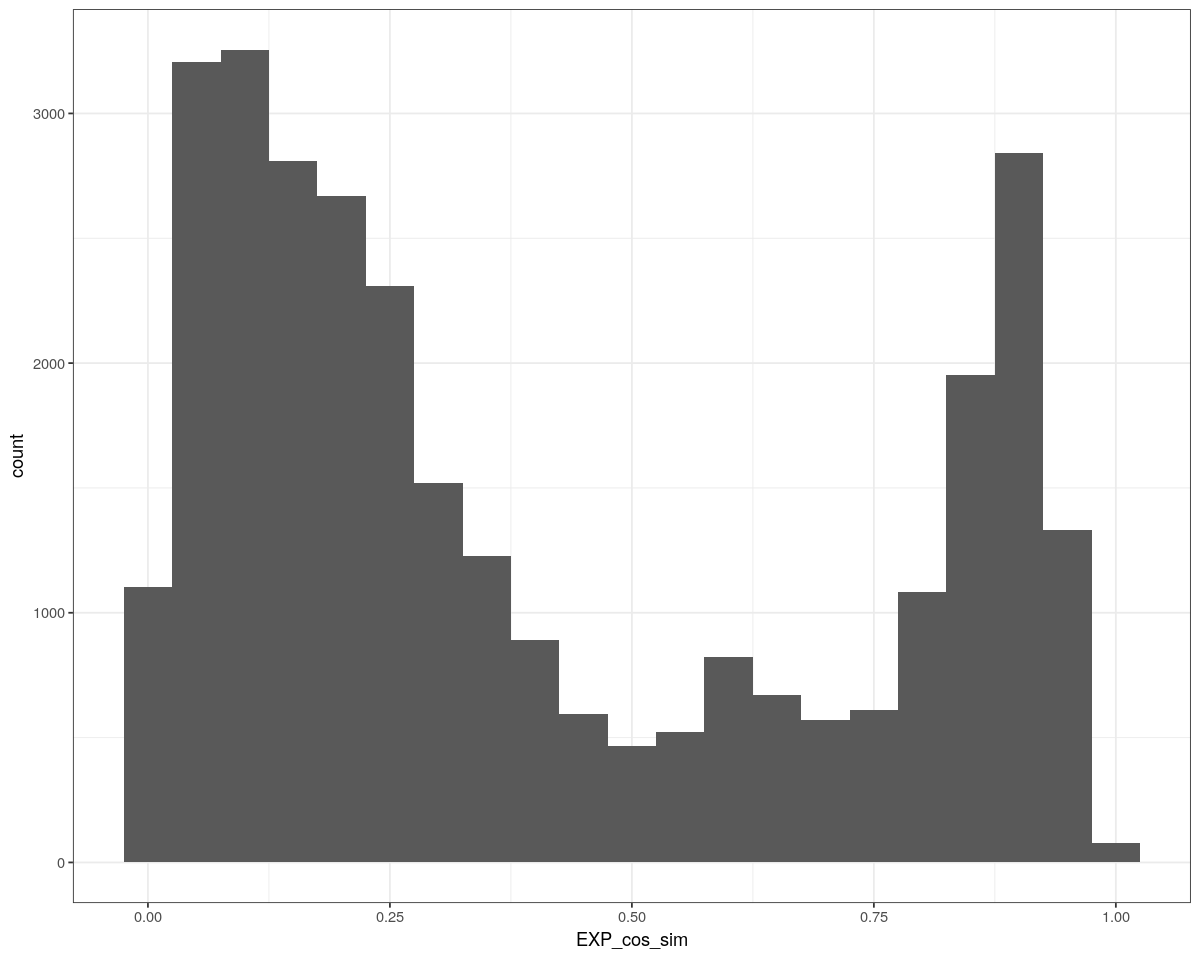

In [39]:
ggplot(res_combn, aes(x = EXP_cos_sim)) + geom_histogram(binwidth = 0.05) + theme_bw()

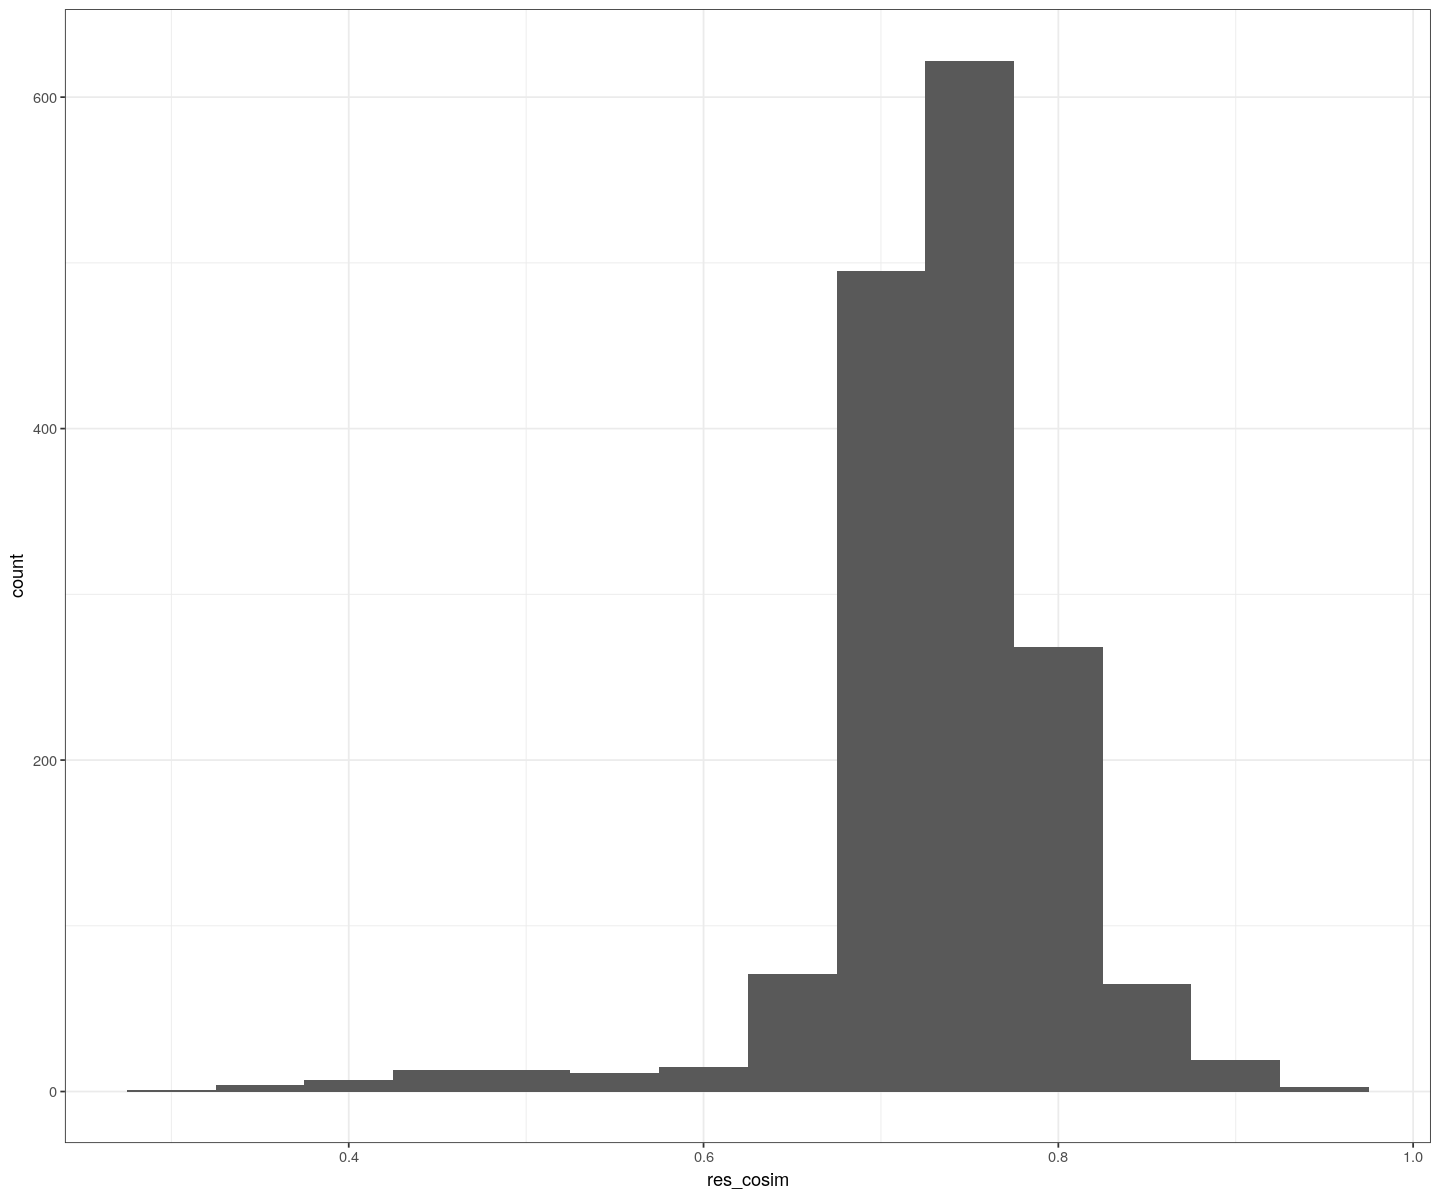

In [99]:
ggplot(TCGA_exp_table, aes(x = res_cosim)) + geom_histogram(binwidth = 0.05) + theme_bw()

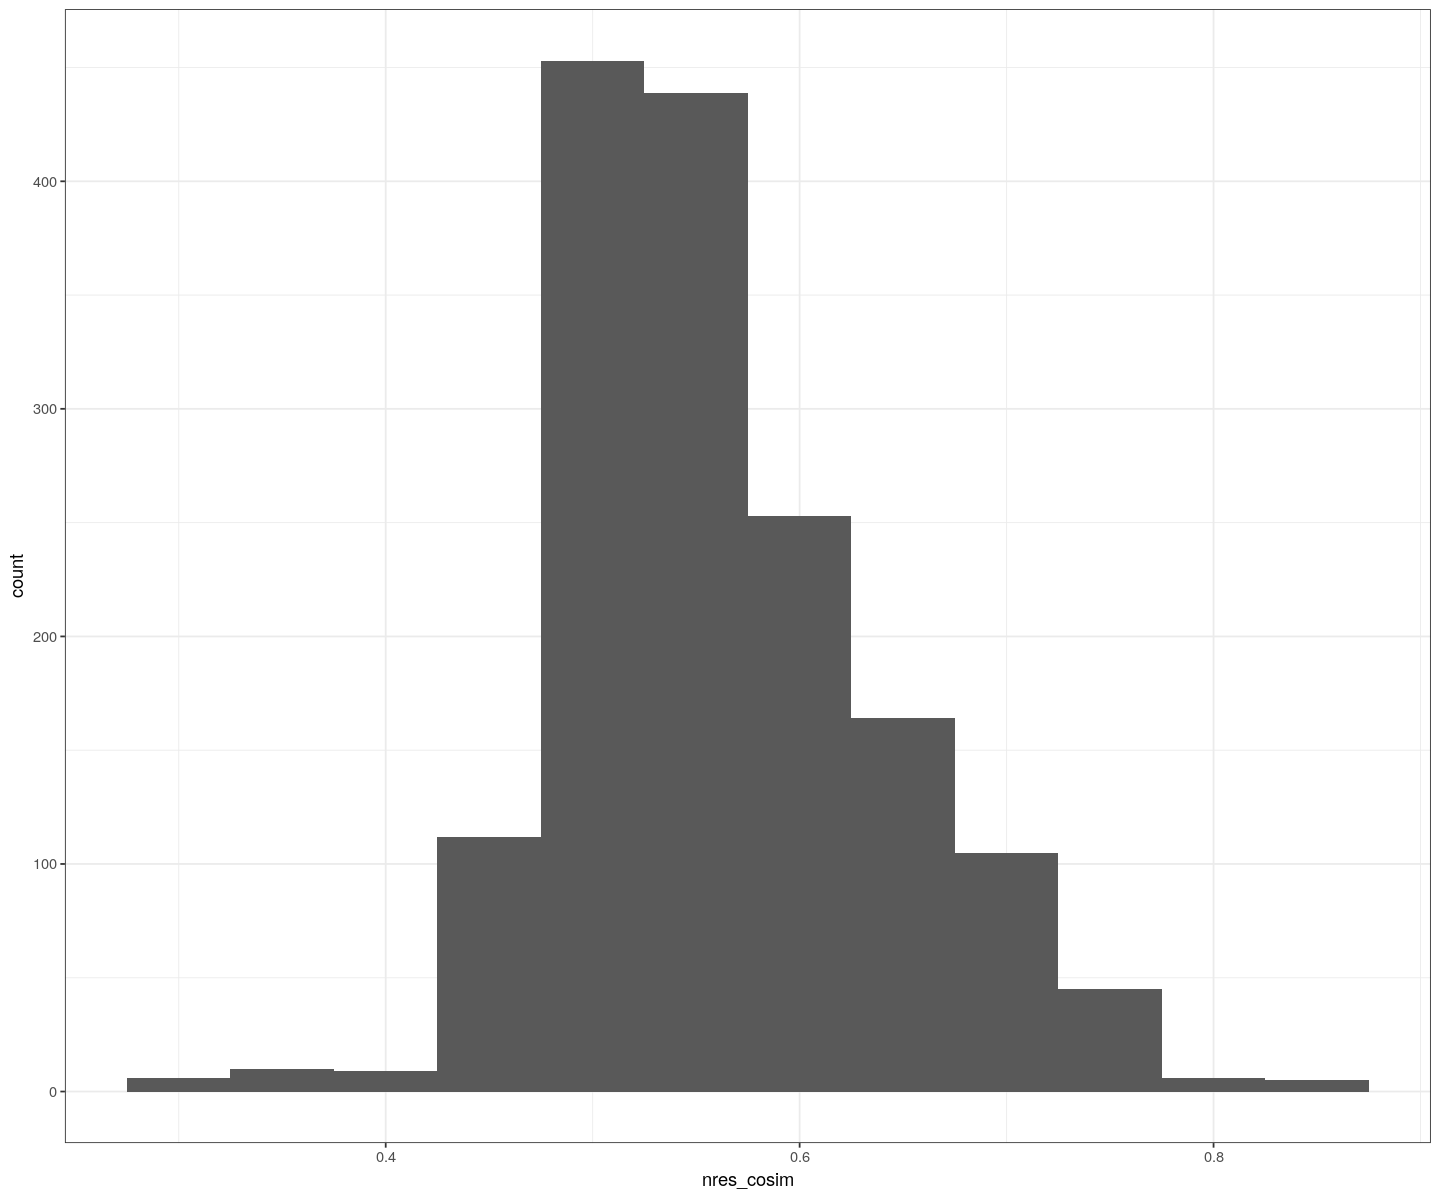

In [100]:
ggplot(TCGA_exp_table, aes(x = nres_cosim)) + geom_histogram(binwidth = 0.05) + theme_bw()

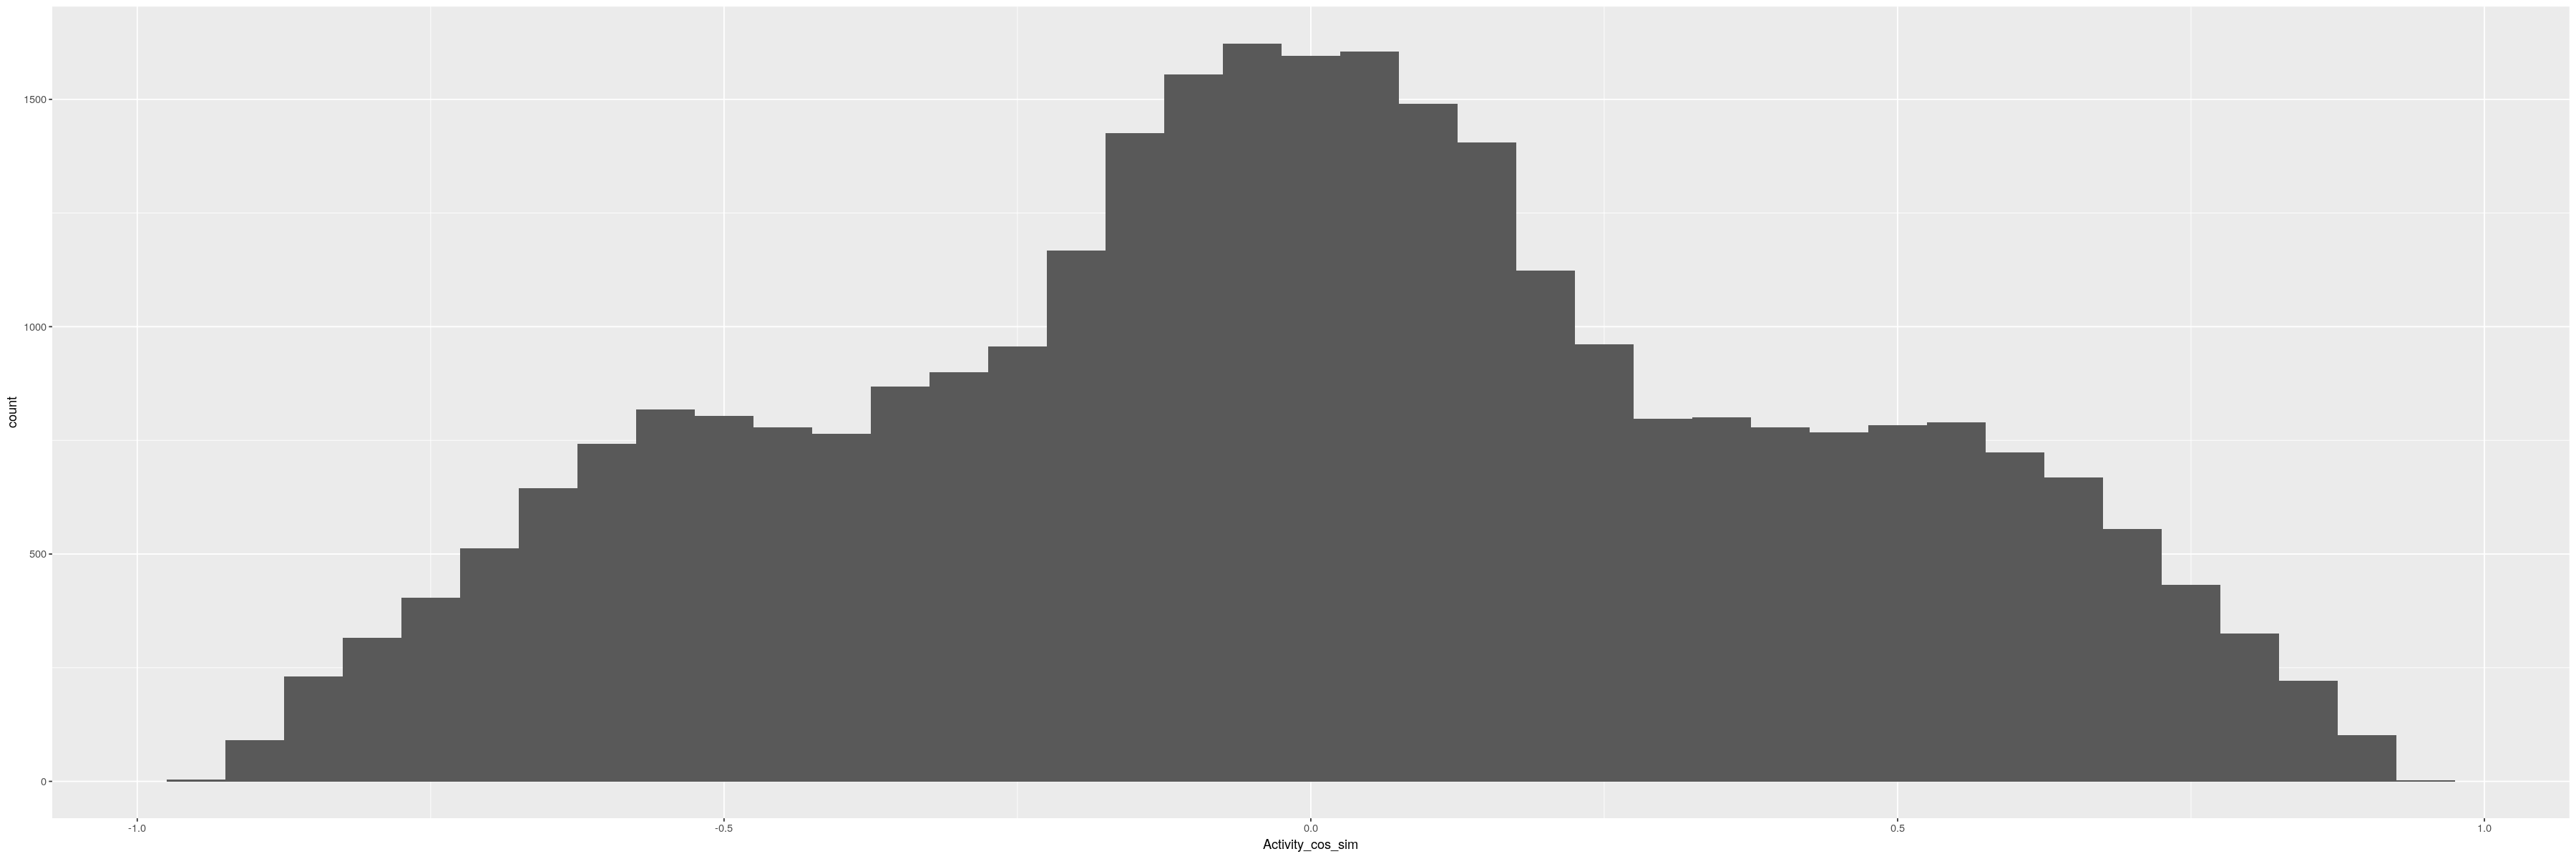

In [28]:
ggplot(res_combn, aes(x = Activity_cos_sim)) + geom_histogram(binwidth = 0.05)

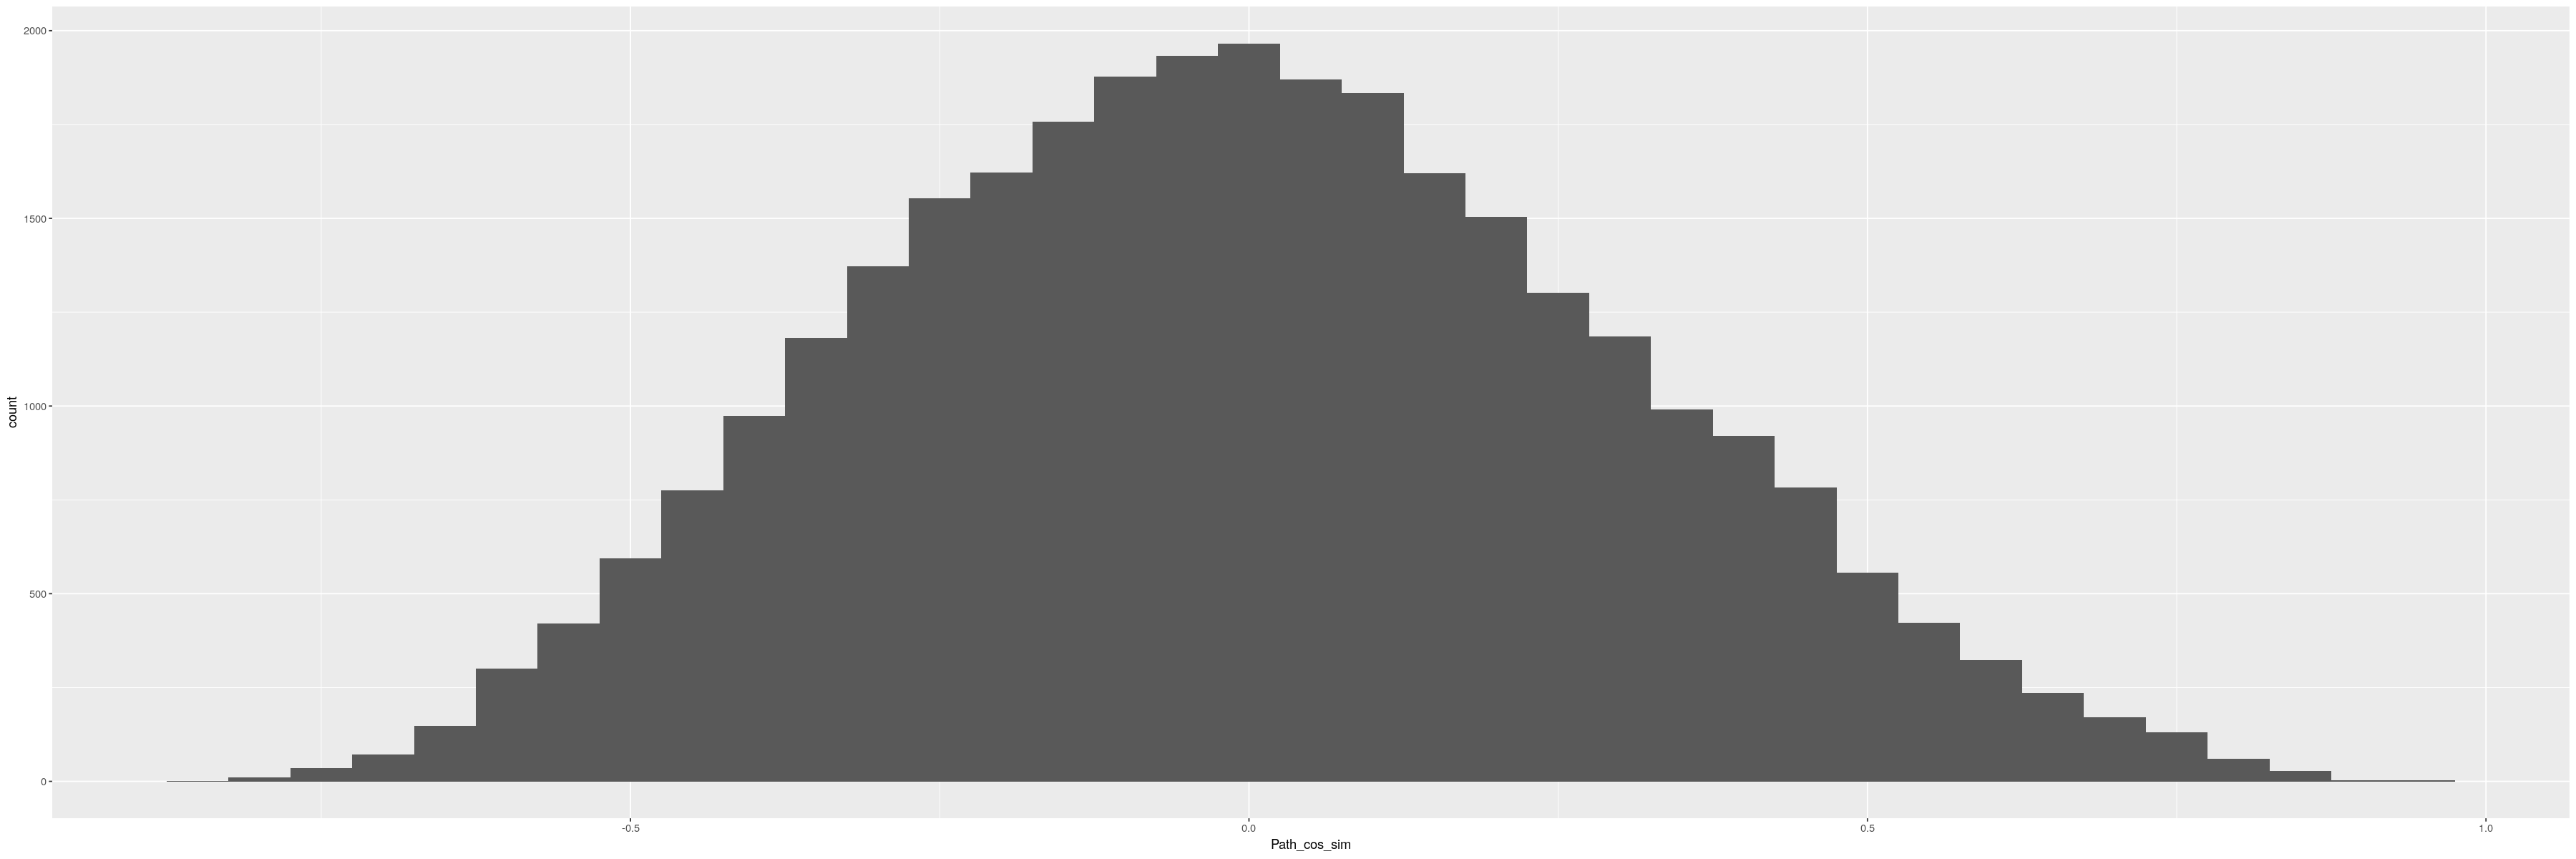

In [29]:
ggplot(res_combn, aes(x = Path_cos_sim)) + geom_histogram(binwidth = 0.05)

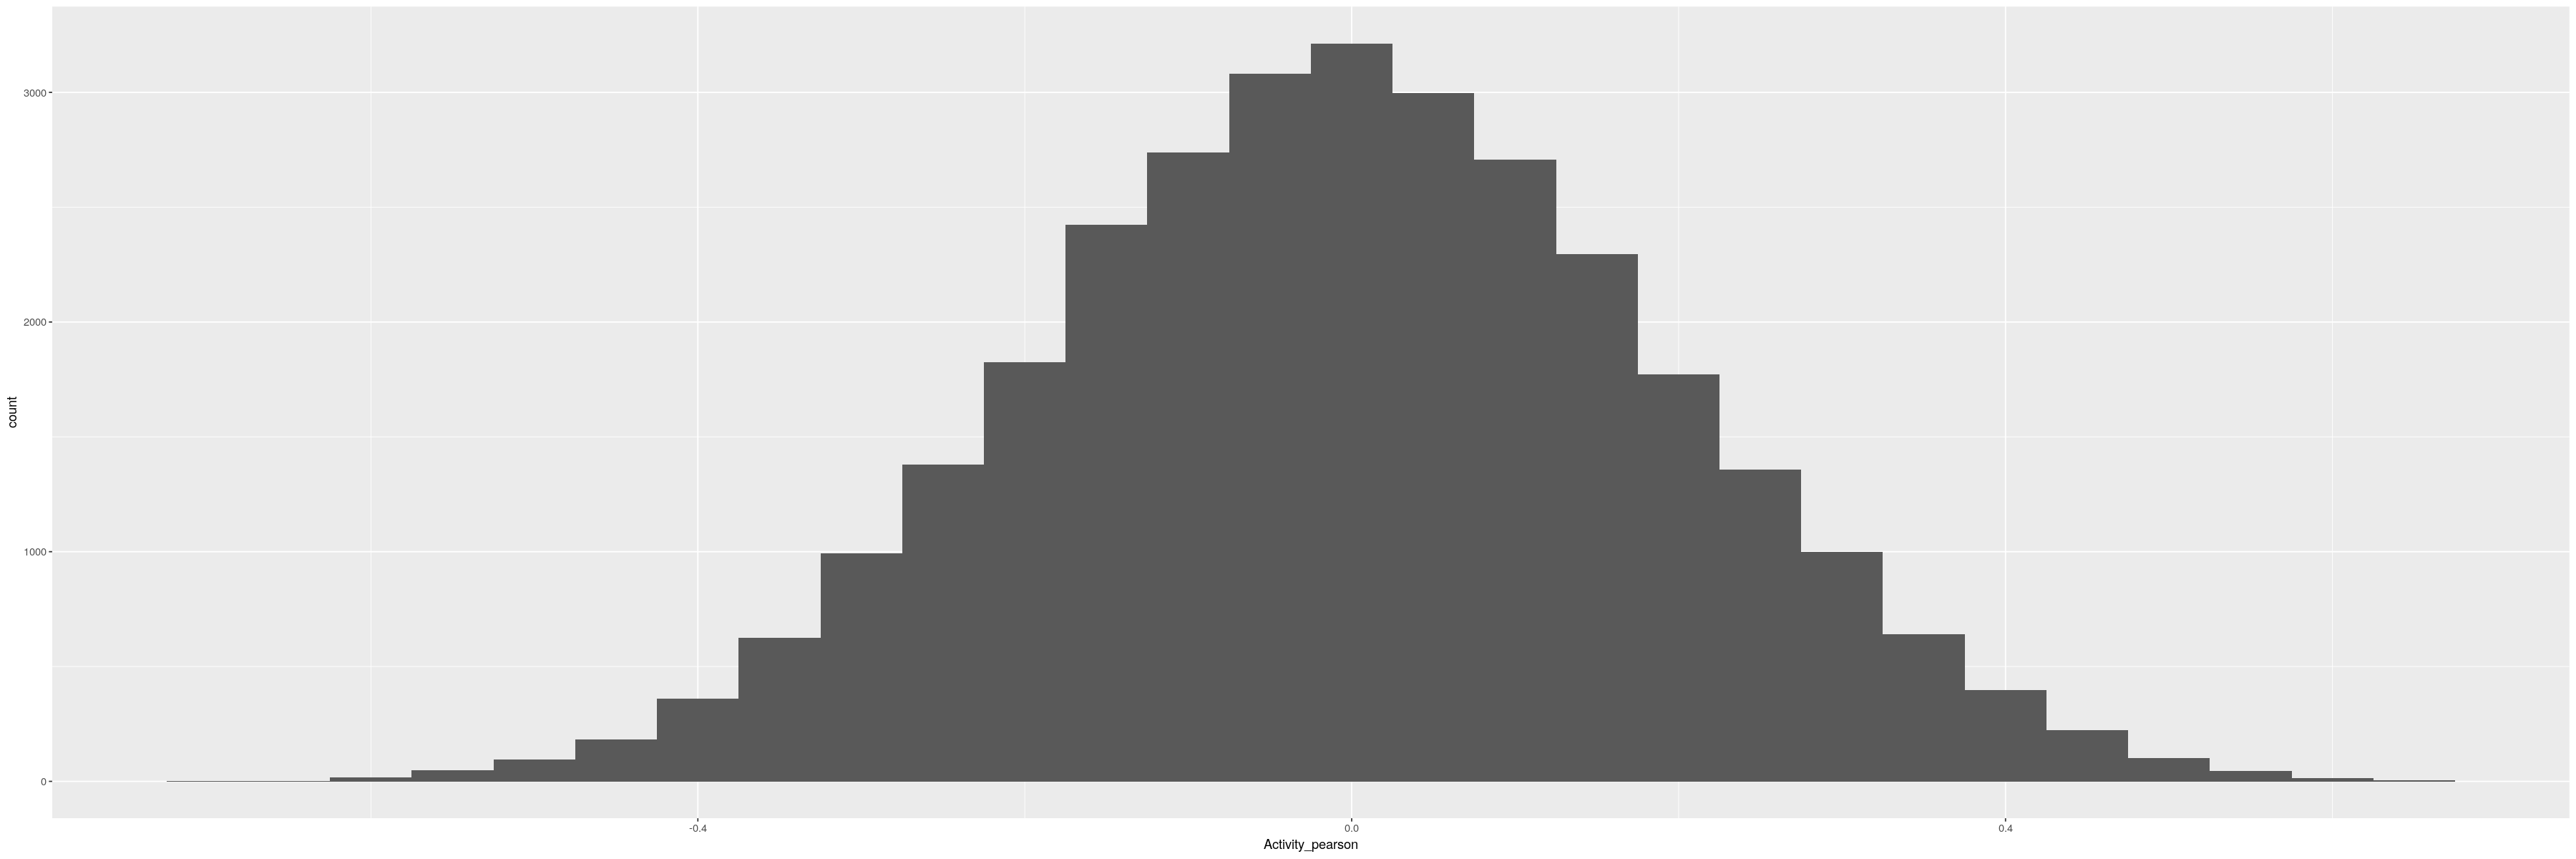

In [30]:
ggplot(res_combn, aes(x = Activity_pearson)) + geom_histogram(binwidth = 0.05)

In [31]:
dim(dataFilt)

[1] 39729  1607

In [32]:
length(make.unique(sort(res_combn[res_combn$EXP_cos_sim>=0.9,]$TCGA_pid)))

[1] 2646

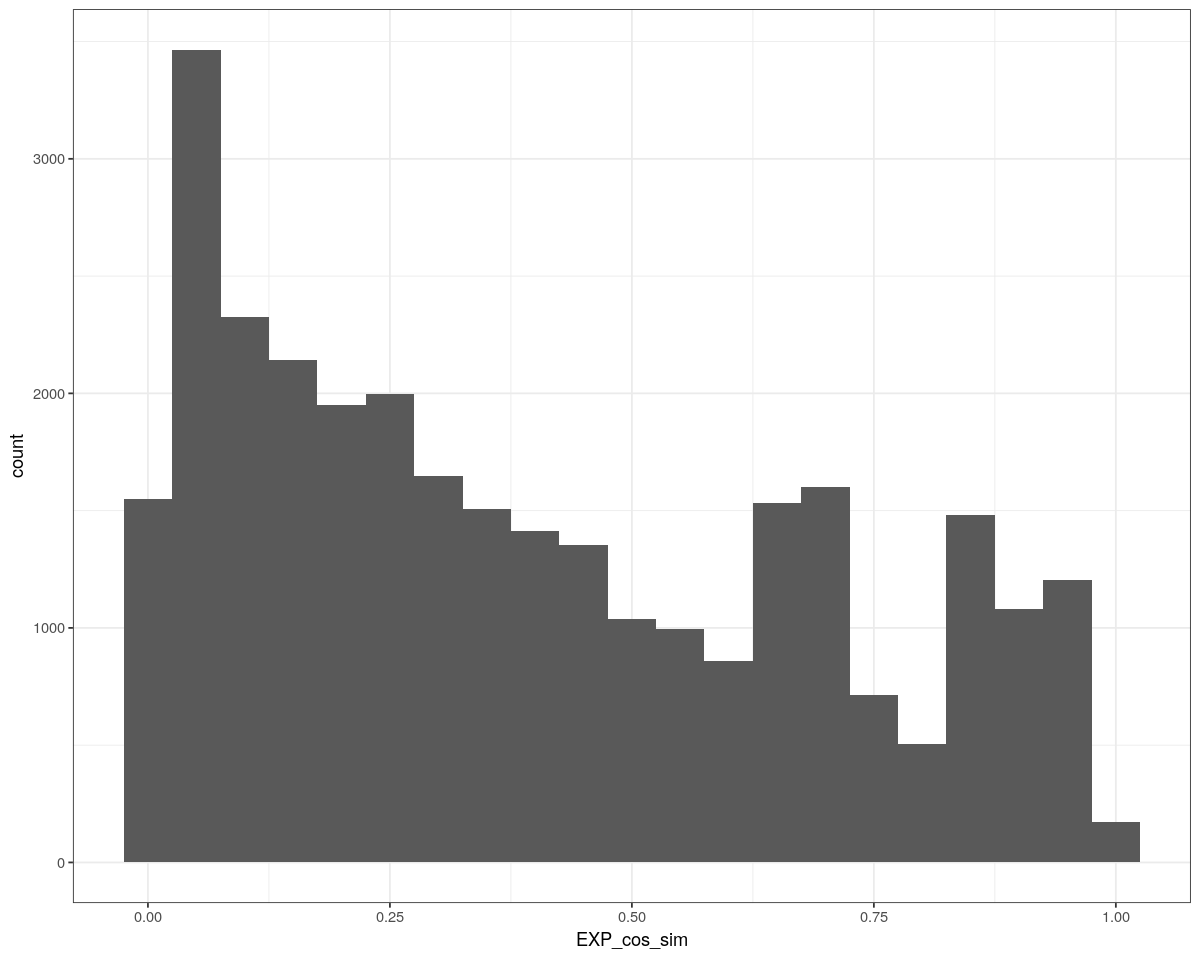

In [40]:
ggplot(nres_combn, aes(x = EXP_cos_sim)) + geom_histogram(binwidth = 0.05) + theme_bw()

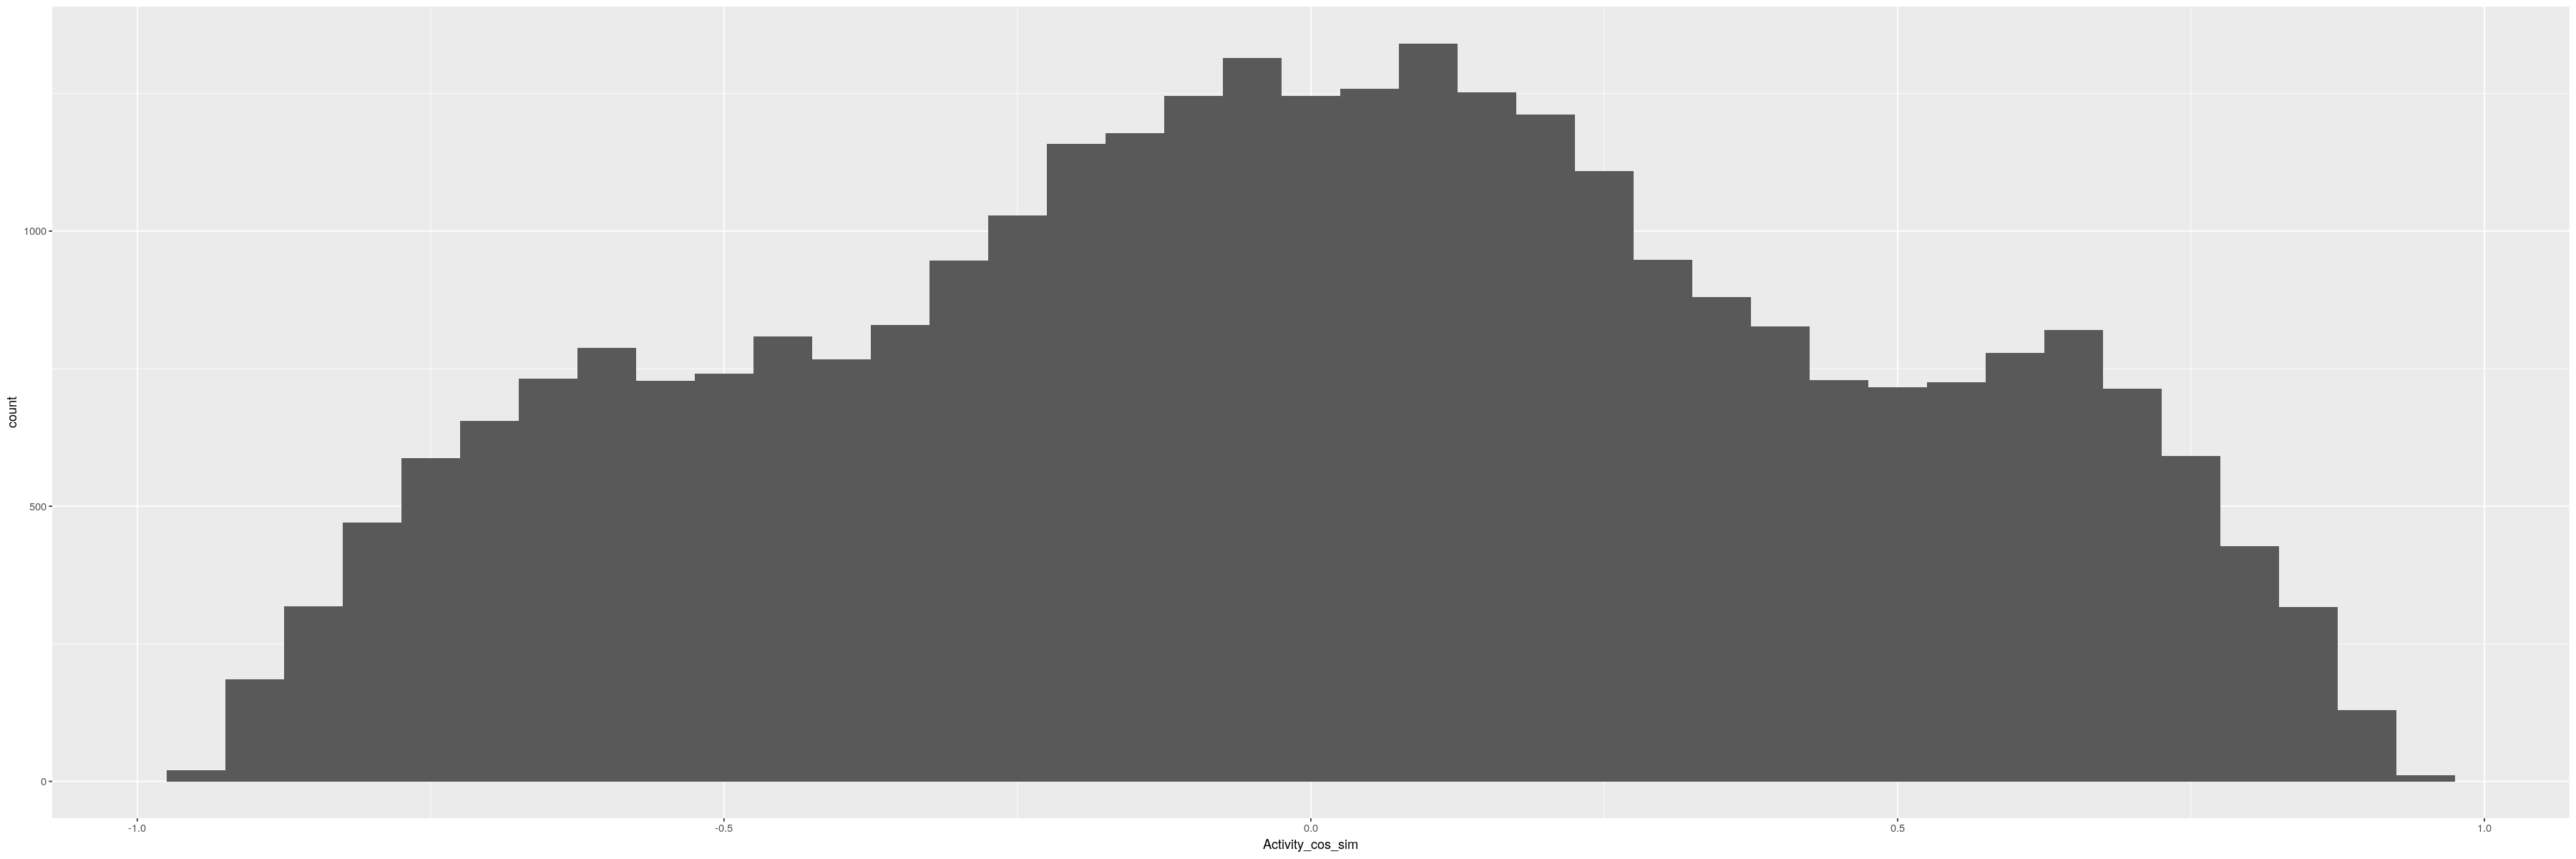

In [34]:
ggplot(nres_combn, aes(x = Activity_cos_sim)) + geom_histogram(binwidth = 0.05)

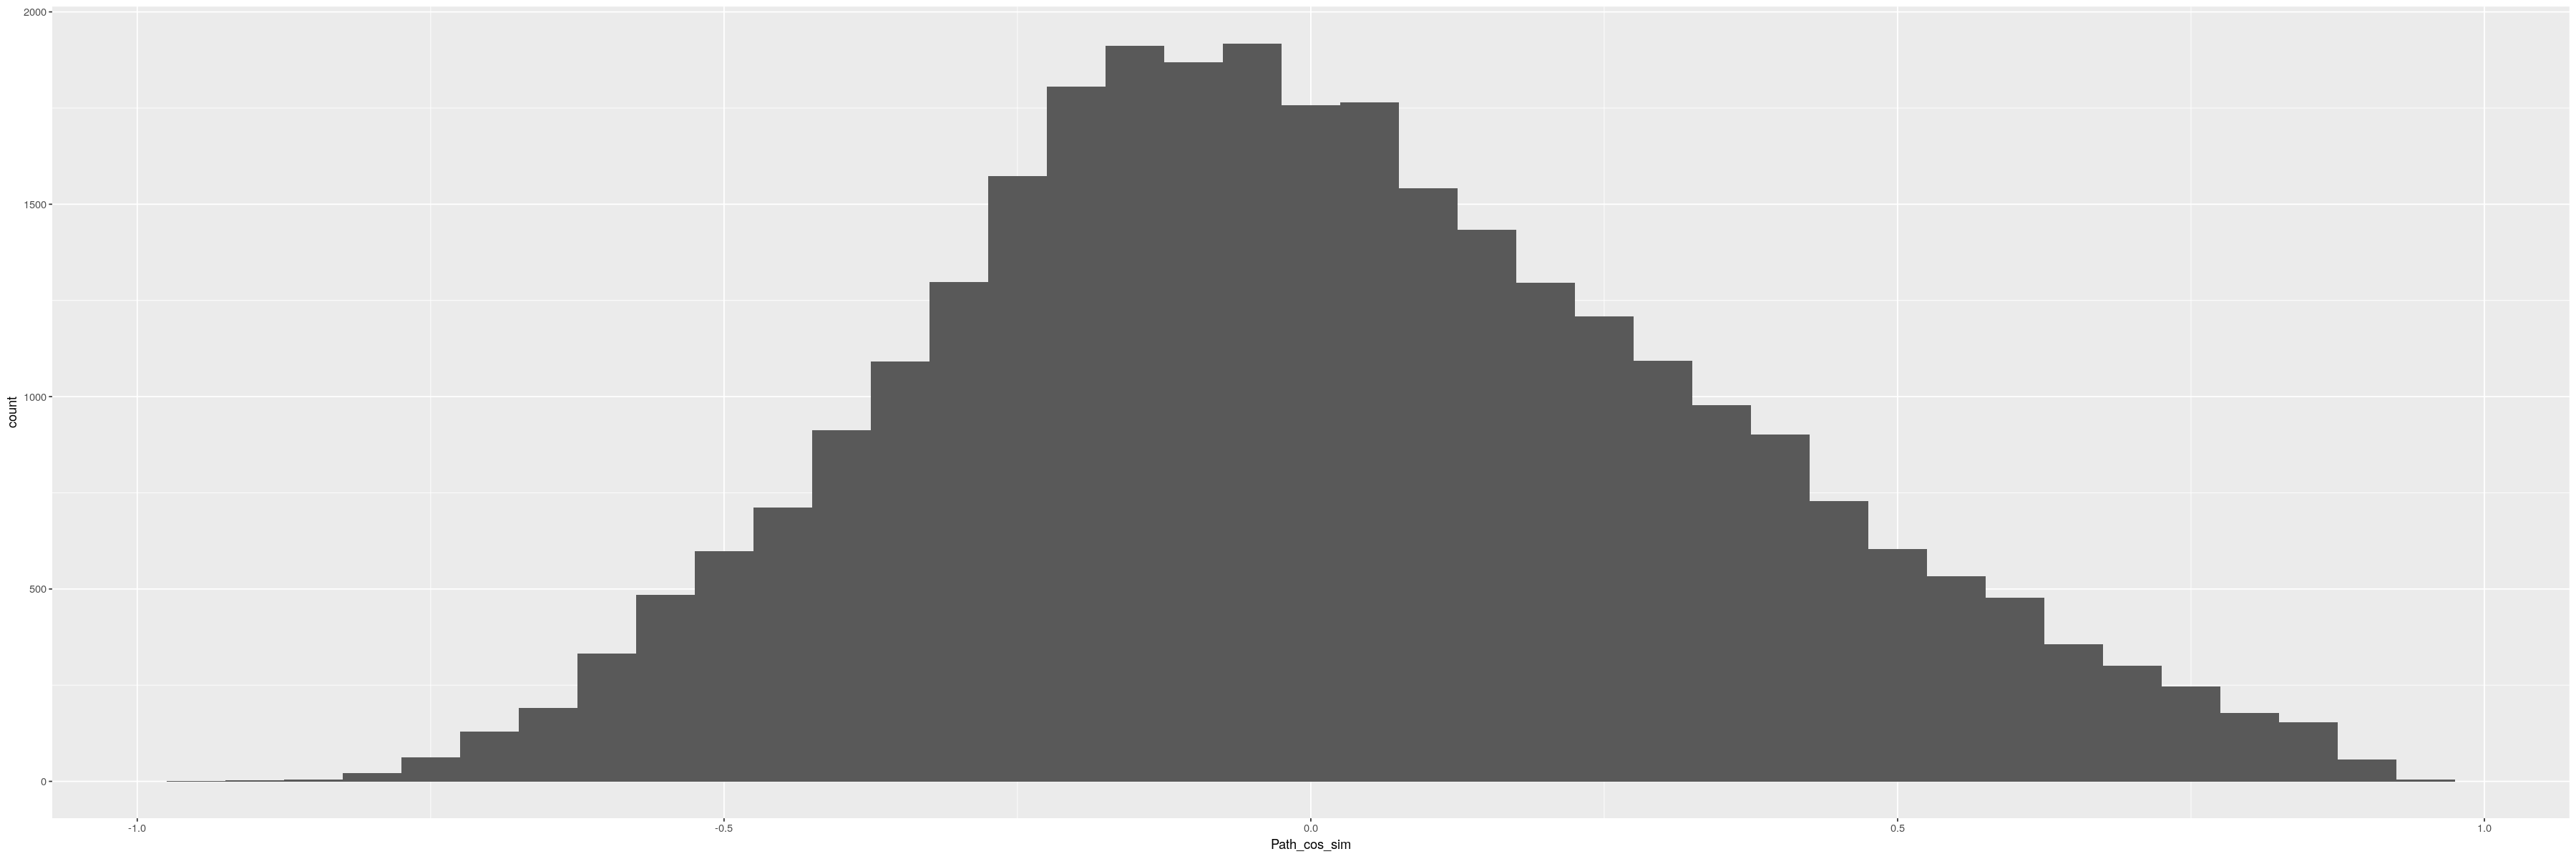

In [35]:
ggplot(nres_combn, aes(x = Path_cos_sim)) + geom_histogram(binwidth = 0.05)

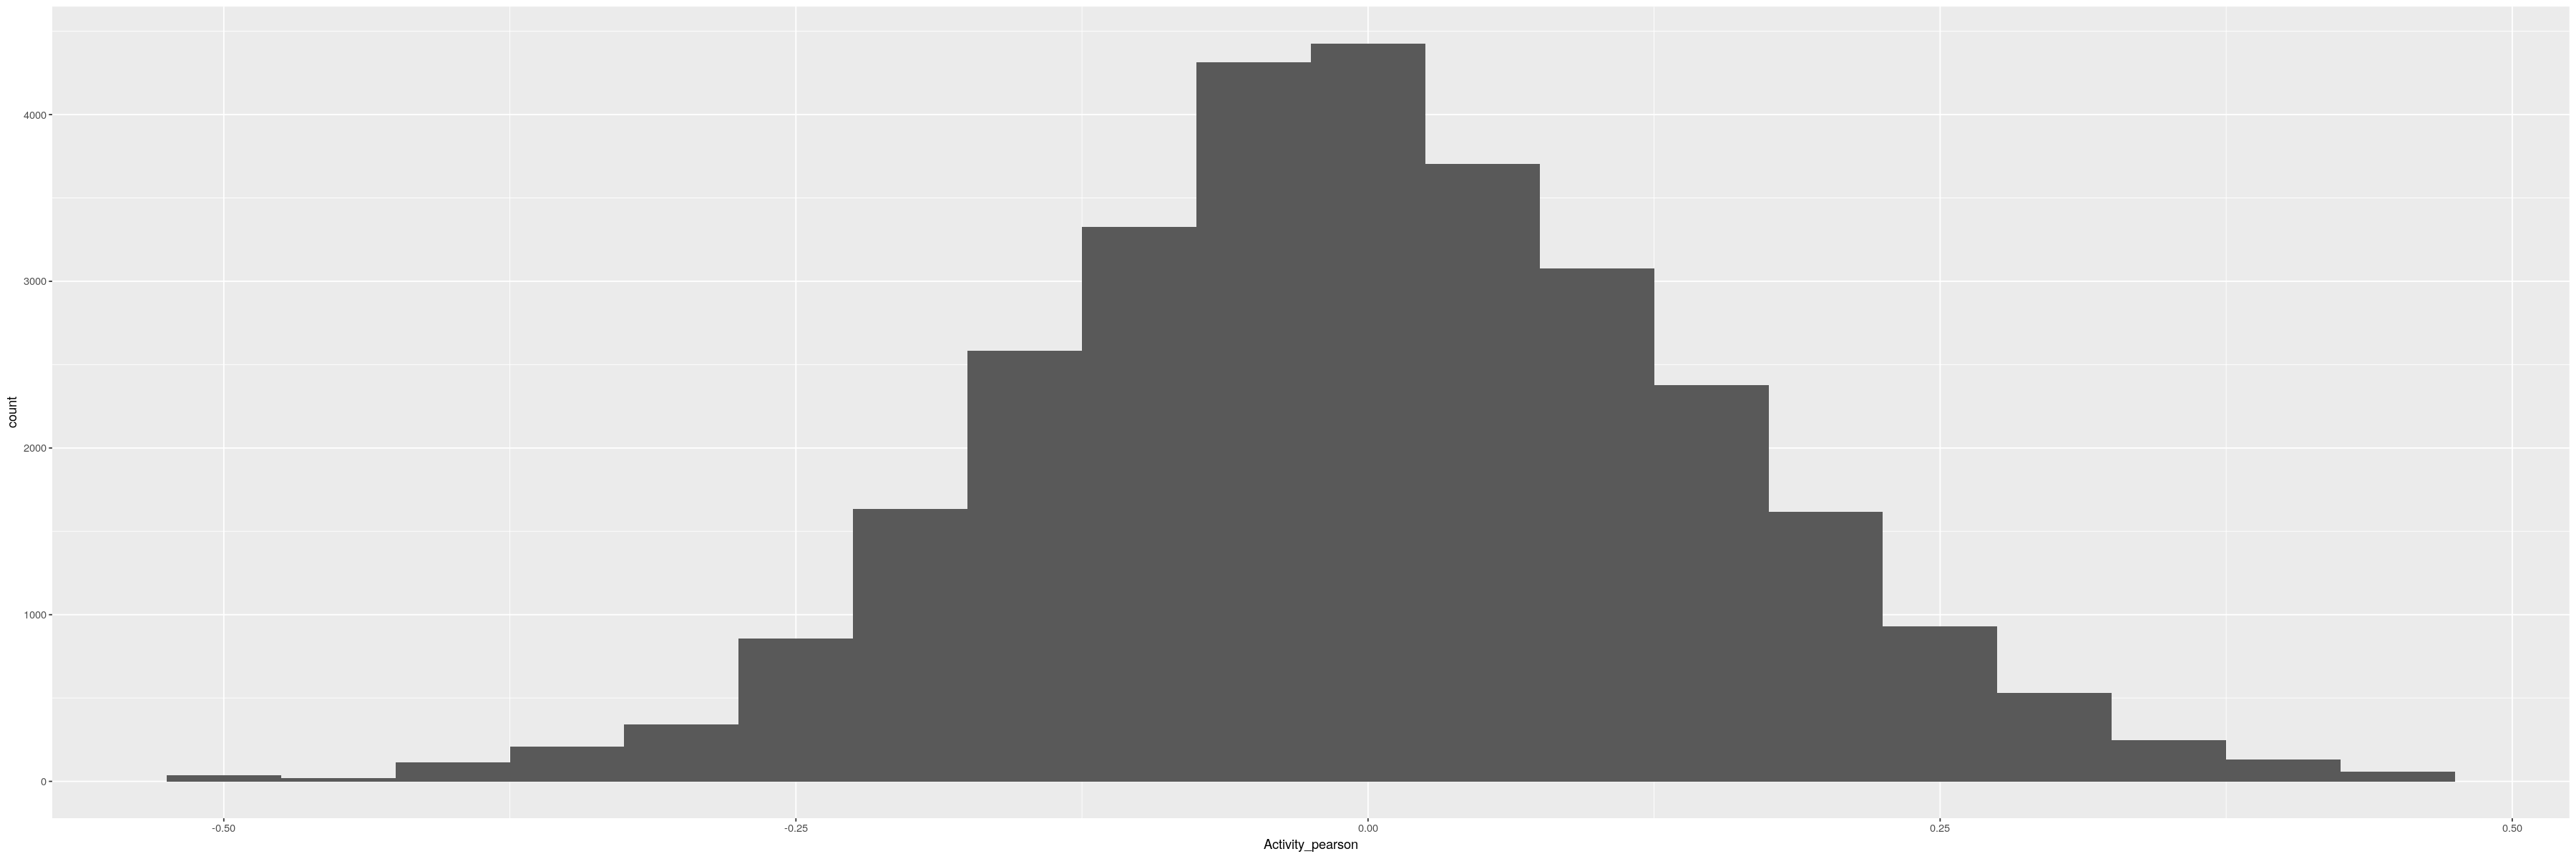

In [36]:
ggplot(nres_combn, aes(x = Activity_pearson)) + geom_histogram(binwidth = 0.05)

In [42]:
nres_exp_marker = unique(nres_combn[nres_combn['EXP_cos_sim'] > 0.95,]['TCGA_pid'])
res_exp_marker = unique(res_combn[res_combn['EXP_cos_sim'] > 0.95,]['TCGA_pid'])
nres_path_marker = unique(nres_combn[nres_combn['Path_cos_sim'] > 0.7,]['TCGA_pid'])
res_path_marker = unique(res_combn[res_combn['Path_cos_sim'] > 0.7,]['TCGA_pid'])
nres_act_marker = unique(nres_combn[nres_combn['Activity_cos_sim'] > 0.7,]['TCGA_pid'])
res_act_marker = unique(res_combn[res_combn['Activity_cos_sim'] > 0.7,]['TCGA_pid'])

In [43]:
nres_exp_marker_str = data.frame(t(sapply(strsplit(nres_exp_marker[['TCGA_pid']],"-"), `[`, 1:3)))
nres_exp_marker_sid = str_c(nres_exp_marker_str$X1,"-",nres_exp_marker_str$X2,'-',nres_exp_marker_str$X3)
res_exp_marker_str = data.frame(t(sapply(strsplit(res_exp_marker[['TCGA_pid']],"-"), `[`, 1:3)))
res_exp_marker_sid = str_c(res_exp_marker_str$X1,"-",res_exp_marker_str$X2,'-',res_exp_marker_str$X3)
nres_path_marker_str = data.frame(t(sapply(strsplit(nres_path_marker[['TCGA_pid']],"-"), `[`, 1:3)))
nres_path_marker_sid = str_c(nres_path_marker_str$X1,"-",nres_path_marker_str$X2,'-',nres_path_marker_str$X3)
res_path_marker_str = data.frame(t(sapply(strsplit(res_path_marker[['TCGA_pid']],"-"), `[`, 1:3)))
res_path_marker_sid = str_c(res_path_marker_str$X1,"-",res_path_marker_str$X2,'-',res_path_marker_str$X3)


In [44]:
nres_act_marker_str = data.frame(t(sapply(strsplit(nres_act_marker[['TCGA_pid']],"-"), `[`, 1:3)))
nres_act_marker_sid = str_c(nres_act_marker_str$X1,"-",nres_act_marker_str$X2,'-',nres_act_marker_str$X3)
res_act_marker_str = data.frame(t(sapply(strsplit(res_act_marker[['TCGA_pid']],"-"), `[`, 1:3)))
res_act_marker_sid = str_c(res_act_marker_str$X1,"-",res_act_marker_str$X2,'-',res_act_marker_str$X3)

In [65]:
dataClin['EXP_marker'] = 'others'
dataClin['Path_marker'] = 'others'

In [66]:
dataClin['Activity_marker'] = 'others'

In [67]:
nres_sid = dataClin[dataClin$submitter_id %in% nres_exp_marker_sid, ][['submitter_id']]
res_sid = dataClin[dataClin$submitter_id %in% res_exp_marker_sid, ][['submitter_id']]

In [68]:
inter_id = nres_sid[nres_sid %in% res_sid]

In [77]:
dataClin[dataClin$submitter_id %in% nres_exp_marker_sid,]['EXP_marker'] = 'non_responders.EXP'
dataClin[dataClin$submitter_id %in% res_exp_marker_sid,]['EXP_marker'] = 'responders.EXP'
dataClin[dataClin$submitter_id %in% inter_id,]['EXP_marker'] = 'intersect'
dataClin[dataClin$submitter_id %in% nres_path_marker_sid,]['Path_marker'] = 'non_responders.PATH'
dataClin[dataClin$submitter_id %in% res_path_marker_sid,]['Path_marker'] = 'responders.PATH'
#dataClin

In [78]:
dataClin[dataClin$submitter_id %in% nres_act_marker_sid,]['Activity_marker'] = 'non_responders.ACT'
dataClin[dataClin$submitter_id %in% res_act_marker_sid,]['Activity_marker'] = 'responders.ACT'

In [ ]:
TCGAanalyze_survival(dataClin, 
                     'EXP_marker',
                    filename = 'Olaparib.fig.TCGA.EXP_marker.survival.pdf')

File saved as: Olaparib.fig.TCGA.EXP_marker.survival.pdf



In [462]:
TCGAanalyze_survival(dataClin, 
                     'random_forest.EXP',
                    filename = 'Olaparib.fig.TCGA.randomForest.EXP_marker.survival.pdf')
TCGAanalyze_survival(dataClin, 
                     'SVM.EXP',
                    filename = 'Olaparib.fig.TCGA.SVM.EXP_marker.survival.pdf')

File saved as: Olaparib.fig.TCGA.randomForest.EXP_marker.survival.pdf

File saved as: Olaparib.fig.TCGA.SVM.EXP_marker.survival.pdf



In [ ]:
TCGAanalyze_survival(dataClin, 
                     'Path_marker',
                    filename = 'Path_marker.survival.pdf')

In [ ]:
TCGAanalyze_survival(dataClin, 
                     'Activity_marker',
                    filename = 'Activity_marker.survival.pdf')

In [463]:
save.image('Olaparib.refractory.TCGA.rda')

In [ ]:
write.csv(dataClin[dataClin['EXP_marker'] == 'responders.EXP',] %>% group_by(tissue_or_organ_of_origin) %>% tally(), 'TCGA.responders.counts.csv', quote = FALSE)
write.csv(dataClin[dataClin['EXP_marker'] == 'non_responders.EXP',] %>% group_by(tissue_or_organ_of_origin) %>% tally(), 'TCGA.non_responders.counts.csv', quote = FALSE)

In [47]:
dataClin['EXP_marker'] = 'non_responders.others'
dataClin[dataClin$submitter_id %in% nres_exp_marker_sid,]['EXP_marker'] = 'non_responders.EXP'
TCGAanalyze_survival(dataClin, 
                     'EXP_marker',
                    filename = 'Olaparib.fig.TCGA.EXP_marker.non_responders.survival.pdf')
dataClin['EXP_marker'] = 'responders.others'
dataClin[dataClin$submitter_id %in% res_exp_marker_sid,]['EXP_marker'] = 'responders.EXP'
TCGAanalyze_survival(dataClin, 
                     'EXP_marker',
                    filename = 'Olaparib.fig.TCGA.EXP_marker.responders.survival.pdf')

File saved as: Olaparib.fig.TCGA.EXP_marker.non_responders.survival.pdf

File saved as: Olaparib.fig.TCGA.EXP_marker.responders.survival.pdf

